<a href="https://colab.research.google.com/github/always-reach/GAN/blob/dcgan/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras import Sequential,datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,LeakyReLU,BatchNormalization,Reshape,Convolution2D,Dropout,MaxPooling2D,Activation,UpSampling2D
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [5]:
class DCGAN():
  def __init__(self):
    #mnist画像の幅
    self.image_row=28
    #mnist画像の高さ
    self.image_col=28
    #mnist画像のチャンネル数
    self.channels=1
    self.image_shape=(self.image_row,self.image_col,self.channels)
    #入力ノイズの次元数
    self.z_input_dim=100
    #最適化アルゴリズムはAdam
    optimizer=Adam()

    self.discriminator=self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=["accuracy"])

    self.generator=self.build_generator()
    self.combined=self.build_combined()
    self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)

  def build_discriminator(self):
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(3, 3), input_shape=self.image_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(64, (3, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))   
    model.summary()

    return model

  def build_generator(self):
    noise_shape=(self.z_input_dim,)
    model = Sequential()
    model.add(Dense(1024,input_shape=noise_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #入力のノイズデータが1次元のため、Reshapeで3次元データに変換
    model.add(Reshape(target_shape=(7,7,128),input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Convolution2D(filters=64,kernel_size=5,strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Convolution2D(filters=1,kernel_size=2,strides=1,padding='same',activation='tanh'))
    model.summary()
    
    return model

  def build_combined(self):
    self.discriminator.trainable=False
    model=Sequential([self.generator,self.discriminator])
    return model

  def train(self,epochs,batch_size=128,save_interval=100):
    print("training start")
    (x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()
    x_train=(x_train.astype(np.float32)-127.5)/127.5
    x_train=np.expand_dims(x_train,axis=3)

    half_batch=int(batch_size/2)

    for epoch in range(epochs):
      noise=np.random.normal(0,1,(half_batch,self.z_input_dim))
      gen_images=self.generator.predict(noise)
      index=np.random.randint(0,x_train.shape[0],half_batch)
      images=x_train[index]
      d_loss_real=self.discriminator.train_on_batch(images,np.ones((half_batch,1)))
      d_loss_fake=self.discriminator.train_on_batch(gen_images,np.zeros((half_batch,1)))

      d_loss=0.5*np.add(d_loss_real,d_loss_fake)

      noise=np.random.normal(0,1,(batch_size,self.z_input_dim))
      valid_y=np.array([1]*batch_size)
      g_loss=self.combined.train_on_batch(noise,valid_y)

      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

      if (epoch+1) % save_interval==0:
        plt.figure(figsize=(10,10))
        x = gen_images[:10]
        for i in range(10):
          plt.subplot(1,10, i+1)
          # 画像を見やすいように座標軸を非表示にする。
          plt.axis("off")
          # 画像を表示
          plt.imshow(x[i].reshape([28,28]), cmap='gray')
        plt.tight_layout()
        plt.show()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                      

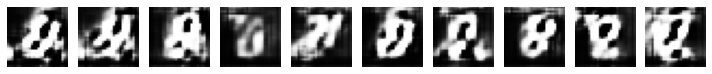

100 [D loss: 0.007070, acc.: 100.00%] [G loss: 0.028831]
101 [D loss: 0.038099, acc.: 99.22%] [G loss: 0.017424]
102 [D loss: 0.014898, acc.: 99.22%] [G loss: 0.004559]
103 [D loss: 0.031700, acc.: 99.22%] [G loss: 0.004095]
104 [D loss: 0.028505, acc.: 99.22%] [G loss: 0.001152]
105 [D loss: 0.070307, acc.: 98.44%] [G loss: 0.001513]
106 [D loss: 0.155052, acc.: 94.53%] [G loss: 0.003190]
107 [D loss: 0.089199, acc.: 97.66%] [G loss: 0.005603]
108 [D loss: 0.044271, acc.: 99.22%] [G loss: 0.007287]
109 [D loss: 0.067844, acc.: 98.44%] [G loss: 0.014251]
110 [D loss: 0.080549, acc.: 98.44%] [G loss: 0.037155]
111 [D loss: 0.105845, acc.: 95.31%] [G loss: 0.022088]
112 [D loss: 0.031217, acc.: 97.66%] [G loss: 0.030262]
113 [D loss: 0.147799, acc.: 92.97%] [G loss: 0.034936]
114 [D loss: 0.102601, acc.: 96.09%] [G loss: 0.056402]
115 [D loss: 0.087164, acc.: 97.66%] [G loss: 0.048875]
116 [D loss: 0.041781, acc.: 99.22%] [G loss: 0.098098]
117 [D loss: 0.188202, acc.: 93.75%] [G loss: 0

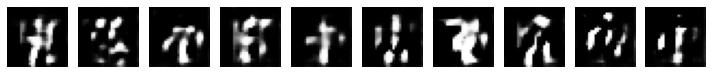

200 [D loss: 0.472172, acc.: 79.69%] [G loss: 1.684386]
201 [D loss: 0.428900, acc.: 83.59%] [G loss: 2.328995]
202 [D loss: 0.626499, acc.: 75.78%] [G loss: 1.698291]
203 [D loss: 0.664159, acc.: 72.66%] [G loss: 1.249024]
204 [D loss: 0.445585, acc.: 86.72%] [G loss: 1.669640]
205 [D loss: 0.411914, acc.: 78.12%] [G loss: 1.560399]
206 [D loss: 0.240998, acc.: 90.62%] [G loss: 1.695705]
207 [D loss: 0.120582, acc.: 97.66%] [G loss: 1.639872]
208 [D loss: 0.055308, acc.: 98.44%] [G loss: 1.320654]
209 [D loss: 0.044324, acc.: 98.44%] [G loss: 0.885796]
210 [D loss: 0.028310, acc.: 99.22%] [G loss: 0.661523]
211 [D loss: 0.034176, acc.: 99.22%] [G loss: 0.362729]
212 [D loss: 0.052824, acc.: 97.66%] [G loss: 0.209669]
213 [D loss: 0.030867, acc.: 99.22%] [G loss: 0.095444]
214 [D loss: 0.071747, acc.: 95.31%] [G loss: 0.069833]
215 [D loss: 0.050273, acc.: 98.44%] [G loss: 0.164168]
216 [D loss: 0.042022, acc.: 99.22%] [G loss: 0.305064]
217 [D loss: 0.058292, acc.: 98.44%] [G loss: 0.

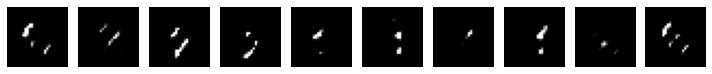

300 [D loss: 0.212495, acc.: 94.53%] [G loss: 1.006901]
301 [D loss: 0.172645, acc.: 96.09%] [G loss: 0.992680]
302 [D loss: 0.143485, acc.: 96.09%] [G loss: 0.992088]
303 [D loss: 0.147230, acc.: 95.31%] [G loss: 0.874523]
304 [D loss: 0.082005, acc.: 98.44%] [G loss: 0.690094]
305 [D loss: 0.074364, acc.: 99.22%] [G loss: 0.555654]
306 [D loss: 0.057783, acc.: 99.22%] [G loss: 0.496559]
307 [D loss: 0.042007, acc.: 99.22%] [G loss: 0.554049]
308 [D loss: 0.045747, acc.: 99.22%] [G loss: 0.473817]
309 [D loss: 0.049132, acc.: 99.22%] [G loss: 0.460336]
310 [D loss: 0.038851, acc.: 99.22%] [G loss: 0.460406]
311 [D loss: 0.057816, acc.: 98.44%] [G loss: 0.510138]
312 [D loss: 0.074713, acc.: 96.09%] [G loss: 0.459183]
313 [D loss: 0.062344, acc.: 96.88%] [G loss: 0.479240]
314 [D loss: 0.076561, acc.: 96.88%] [G loss: 0.472292]
315 [D loss: 0.083207, acc.: 97.66%] [G loss: 0.874138]
316 [D loss: 0.109390, acc.: 96.09%] [G loss: 1.065727]
317 [D loss: 0.217242, acc.: 91.41%] [G loss: 1.

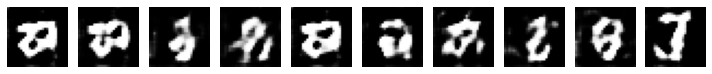

400 [D loss: 0.303060, acc.: 91.41%] [G loss: 1.331981]
401 [D loss: 0.194258, acc.: 94.53%] [G loss: 1.352022]
402 [D loss: 0.282016, acc.: 91.41%] [G loss: 1.209152]
403 [D loss: 0.418972, acc.: 83.59%] [G loss: 1.133474]
404 [D loss: 0.495266, acc.: 81.25%] [G loss: 1.350254]
405 [D loss: 0.498488, acc.: 78.12%] [G loss: 1.655739]
406 [D loss: 0.545958, acc.: 75.78%] [G loss: 1.455500]
407 [D loss: 0.796250, acc.: 71.88%] [G loss: 1.169887]
408 [D loss: 0.622550, acc.: 71.09%] [G loss: 1.117910]
409 [D loss: 0.672011, acc.: 66.41%] [G loss: 1.237667]
410 [D loss: 0.391675, acc.: 85.16%] [G loss: 1.428637]
411 [D loss: 0.562789, acc.: 80.47%] [G loss: 1.372265]
412 [D loss: 0.499754, acc.: 82.03%] [G loss: 1.067717]
413 [D loss: 0.301659, acc.: 89.06%] [G loss: 0.958619]
414 [D loss: 0.328866, acc.: 88.28%] [G loss: 0.926026]
415 [D loss: 0.264117, acc.: 92.19%] [G loss: 0.982779]
416 [D loss: 0.134942, acc.: 99.22%] [G loss: 1.252528]
417 [D loss: 0.158888, acc.: 95.31%] [G loss: 1.

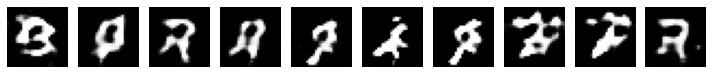

500 [D loss: 0.235741, acc.: 89.06%] [G loss: 2.328883]
501 [D loss: 0.295014, acc.: 87.50%] [G loss: 2.170488]
502 [D loss: 0.260460, acc.: 89.84%] [G loss: 1.794293]
503 [D loss: 0.279171, acc.: 89.84%] [G loss: 1.777531]
504 [D loss: 0.200283, acc.: 96.09%] [G loss: 2.008985]
505 [D loss: 0.189542, acc.: 94.53%] [G loss: 2.028607]
506 [D loss: 0.255513, acc.: 89.06%] [G loss: 2.041386]
507 [D loss: 0.349417, acc.: 85.94%] [G loss: 1.758779]
508 [D loss: 0.284665, acc.: 88.28%] [G loss: 1.637019]
509 [D loss: 0.238139, acc.: 88.28%] [G loss: 1.891256]
510 [D loss: 0.312870, acc.: 85.94%] [G loss: 2.160100]
511 [D loss: 0.200925, acc.: 91.41%] [G loss: 2.209966]
512 [D loss: 0.331763, acc.: 86.72%] [G loss: 1.881853]
513 [D loss: 0.280420, acc.: 89.84%] [G loss: 1.839313]
514 [D loss: 0.315740, acc.: 86.72%] [G loss: 1.338491]
515 [D loss: 0.301319, acc.: 85.16%] [G loss: 1.529680]
516 [D loss: 0.239183, acc.: 90.62%] [G loss: 2.007278]
517 [D loss: 0.440164, acc.: 82.03%] [G loss: 2.

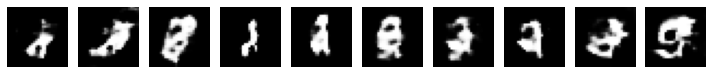

600 [D loss: 0.163940, acc.: 92.19%] [G loss: 2.412998]
601 [D loss: 0.153229, acc.: 95.31%] [G loss: 2.602435]
602 [D loss: 0.160336, acc.: 93.75%] [G loss: 2.365101]
603 [D loss: 0.153073, acc.: 92.19%] [G loss: 2.700213]
604 [D loss: 0.222331, acc.: 92.97%] [G loss: 2.870844]
605 [D loss: 0.199553, acc.: 94.53%] [G loss: 2.547803]
606 [D loss: 0.157078, acc.: 94.53%] [G loss: 2.262704]
607 [D loss: 0.181652, acc.: 93.75%] [G loss: 2.077695]
608 [D loss: 0.261701, acc.: 89.84%] [G loss: 1.785803]
609 [D loss: 0.195132, acc.: 93.75%] [G loss: 1.654138]
610 [D loss: 0.293105, acc.: 89.06%] [G loss: 1.715157]
611 [D loss: 0.207879, acc.: 92.19%] [G loss: 2.117521]
612 [D loss: 0.120557, acc.: 96.09%] [G loss: 2.067883]
613 [D loss: 0.162957, acc.: 95.31%] [G loss: 1.940422]
614 [D loss: 0.128615, acc.: 95.31%] [G loss: 2.067030]
615 [D loss: 0.151143, acc.: 92.97%] [G loss: 2.009640]
616 [D loss: 0.211864, acc.: 89.84%] [G loss: 1.594791]
617 [D loss: 0.266685, acc.: 85.16%] [G loss: 1.

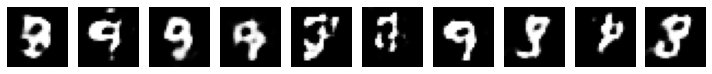

700 [D loss: 0.249955, acc.: 91.41%] [G loss: 2.261523]
701 [D loss: 0.203407, acc.: 92.19%] [G loss: 2.020250]
702 [D loss: 0.230095, acc.: 89.84%] [G loss: 1.531768]
703 [D loss: 0.225460, acc.: 92.19%] [G loss: 1.532805]
704 [D loss: 0.253333, acc.: 92.19%] [G loss: 1.874992]
705 [D loss: 0.193686, acc.: 92.97%] [G loss: 2.033792]
706 [D loss: 0.126386, acc.: 95.31%] [G loss: 2.330053]
707 [D loss: 0.106832, acc.: 96.88%] [G loss: 2.046048]
708 [D loss: 0.081610, acc.: 99.22%] [G loss: 2.221070]
709 [D loss: 0.106401, acc.: 96.09%] [G loss: 2.012324]
710 [D loss: 0.158572, acc.: 94.53%] [G loss: 1.580160]
711 [D loss: 0.134412, acc.: 95.31%] [G loss: 1.757043]
712 [D loss: 0.158509, acc.: 94.53%] [G loss: 2.071798]
713 [D loss: 0.172144, acc.: 92.19%] [G loss: 2.289552]
714 [D loss: 0.156342, acc.: 96.09%] [G loss: 2.348175]
715 [D loss: 0.137834, acc.: 96.09%] [G loss: 2.403613]
716 [D loss: 0.126373, acc.: 95.31%] [G loss: 2.267620]
717 [D loss: 0.087013, acc.: 98.44%] [G loss: 2.

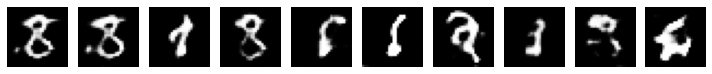

800 [D loss: 0.285784, acc.: 87.50%] [G loss: 0.974675]
801 [D loss: 0.283273, acc.: 87.50%] [G loss: 1.351774]
802 [D loss: 0.185668, acc.: 93.75%] [G loss: 2.290892]
803 [D loss: 0.199490, acc.: 91.41%] [G loss: 3.334577]
804 [D loss: 0.224573, acc.: 92.19%] [G loss: 2.939615]
805 [D loss: 0.253809, acc.: 87.50%] [G loss: 2.035471]
806 [D loss: 0.265696, acc.: 90.62%] [G loss: 1.853031]
807 [D loss: 0.151503, acc.: 92.97%] [G loss: 2.045992]
808 [D loss: 0.190591, acc.: 92.97%] [G loss: 2.675478]
809 [D loss: 0.128864, acc.: 96.09%] [G loss: 3.180962]
810 [D loss: 0.167282, acc.: 93.75%] [G loss: 3.734905]
811 [D loss: 0.084294, acc.: 96.88%] [G loss: 3.958628]
812 [D loss: 0.175642, acc.: 92.19%] [G loss: 3.431805]
813 [D loss: 0.130668, acc.: 96.88%] [G loss: 2.682105]
814 [D loss: 0.267177, acc.: 91.41%] [G loss: 2.692893]
815 [D loss: 0.144684, acc.: 92.97%] [G loss: 2.705789]
816 [D loss: 0.236090, acc.: 91.41%] [G loss: 2.590336]
817 [D loss: 0.236362, acc.: 90.62%] [G loss: 2.

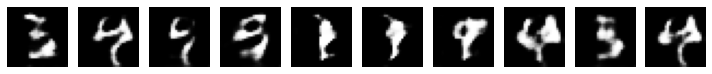

900 [D loss: 0.213273, acc.: 90.62%] [G loss: 1.105091]
901 [D loss: 0.111547, acc.: 96.88%] [G loss: 1.161952]
902 [D loss: 0.146289, acc.: 91.41%] [G loss: 1.199790]
903 [D loss: 0.121239, acc.: 93.75%] [G loss: 1.409037]
904 [D loss: 0.184961, acc.: 93.75%] [G loss: 0.971797]
905 [D loss: 0.130616, acc.: 95.31%] [G loss: 0.769620]
906 [D loss: 0.224838, acc.: 90.62%] [G loss: 0.944961]
907 [D loss: 0.099813, acc.: 97.66%] [G loss: 1.220153]
908 [D loss: 0.142471, acc.: 93.75%] [G loss: 1.375580]
909 [D loss: 0.118154, acc.: 97.66%] [G loss: 1.046427]
910 [D loss: 0.245625, acc.: 91.41%] [G loss: 0.836211]
911 [D loss: 0.217626, acc.: 90.62%] [G loss: 0.700986]
912 [D loss: 0.189163, acc.: 91.41%] [G loss: 0.889999]
913 [D loss: 0.116310, acc.: 96.88%] [G loss: 1.003416]
914 [D loss: 0.259088, acc.: 92.19%] [G loss: 0.917026]
915 [D loss: 0.207073, acc.: 92.19%] [G loss: 0.947320]
916 [D loss: 0.247929, acc.: 90.62%] [G loss: 0.617080]
917 [D loss: 0.333613, acc.: 85.16%] [G loss: 0.

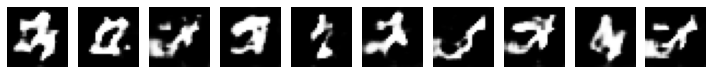

1000 [D loss: 0.166657, acc.: 92.97%] [G loss: 1.977876]
1001 [D loss: 0.119151, acc.: 96.09%] [G loss: 1.780478]
1002 [D loss: 0.194360, acc.: 92.19%] [G loss: 1.589441]
1003 [D loss: 0.152642, acc.: 91.41%] [G loss: 1.528408]
1004 [D loss: 0.083820, acc.: 97.66%] [G loss: 1.931367]
1005 [D loss: 0.222693, acc.: 91.41%] [G loss: 1.739030]
1006 [D loss: 0.161602, acc.: 94.53%] [G loss: 1.513006]
1007 [D loss: 0.167563, acc.: 92.19%] [G loss: 1.919289]
1008 [D loss: 0.172619, acc.: 92.97%] [G loss: 1.710037]
1009 [D loss: 0.089041, acc.: 96.09%] [G loss: 1.528824]
1010 [D loss: 0.274594, acc.: 89.84%] [G loss: 1.205060]
1011 [D loss: 0.136314, acc.: 96.09%] [G loss: 0.866298]
1012 [D loss: 0.206042, acc.: 92.97%] [G loss: 1.087368]
1013 [D loss: 0.148337, acc.: 93.75%] [G loss: 1.464645]
1014 [D loss: 0.283815, acc.: 89.06%] [G loss: 1.376860]
1015 [D loss: 0.214011, acc.: 91.41%] [G loss: 1.517310]
1016 [D loss: 0.171056, acc.: 93.75%] [G loss: 1.528352]
1017 [D loss: 0.316027, acc.: 8

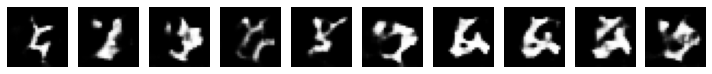

1100 [D loss: 0.125522, acc.: 94.53%] [G loss: 2.749932]
1101 [D loss: 0.149699, acc.: 95.31%] [G loss: 3.014273]
1102 [D loss: 0.096913, acc.: 96.09%] [G loss: 2.468480]
1103 [D loss: 0.146393, acc.: 93.75%] [G loss: 2.283643]
1104 [D loss: 0.124433, acc.: 93.75%] [G loss: 2.846117]
1105 [D loss: 0.058813, acc.: 98.44%] [G loss: 3.273319]
1106 [D loss: 0.129759, acc.: 96.09%] [G loss: 2.903342]
1107 [D loss: 0.040353, acc.: 100.00%] [G loss: 2.525343]
1108 [D loss: 0.206236, acc.: 93.75%] [G loss: 1.799643]
1109 [D loss: 0.215354, acc.: 92.19%] [G loss: 1.121810]
1110 [D loss: 0.214040, acc.: 89.06%] [G loss: 1.099205]
1111 [D loss: 0.110918, acc.: 94.53%] [G loss: 1.777693]
1112 [D loss: 0.080101, acc.: 96.09%] [G loss: 2.277689]
1113 [D loss: 0.073937, acc.: 97.66%] [G loss: 2.244279]
1114 [D loss: 0.092956, acc.: 96.88%] [G loss: 1.535416]
1115 [D loss: 0.070848, acc.: 96.88%] [G loss: 1.037350]
1116 [D loss: 0.118451, acc.: 94.53%] [G loss: 0.901642]
1117 [D loss: 0.090535, acc.: 

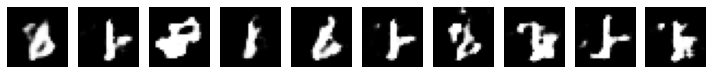

1200 [D loss: 0.119647, acc.: 96.88%] [G loss: 2.957316]
1201 [D loss: 0.128954, acc.: 95.31%] [G loss: 2.468044]
1202 [D loss: 0.082015, acc.: 96.09%] [G loss: 2.988212]
1203 [D loss: 0.146773, acc.: 95.31%] [G loss: 2.915618]
1204 [D loss: 0.102781, acc.: 96.88%] [G loss: 2.561449]
1205 [D loss: 0.257978, acc.: 89.84%] [G loss: 2.210813]
1206 [D loss: 0.123813, acc.: 96.09%] [G loss: 2.462516]
1207 [D loss: 0.164707, acc.: 92.97%] [G loss: 2.997579]
1208 [D loss: 0.073005, acc.: 97.66%] [G loss: 3.708010]
1209 [D loss: 0.186180, acc.: 93.75%] [G loss: 3.197402]
1210 [D loss: 0.075679, acc.: 96.88%] [G loss: 2.680275]
1211 [D loss: 0.170926, acc.: 93.75%] [G loss: 2.007482]
1212 [D loss: 0.179423, acc.: 92.19%] [G loss: 2.461067]
1213 [D loss: 0.189188, acc.: 92.19%] [G loss: 2.771466]
1214 [D loss: 0.161560, acc.: 95.31%] [G loss: 3.373571]
1215 [D loss: 0.076557, acc.: 98.44%] [G loss: 3.104251]
1216 [D loss: 0.127668, acc.: 92.97%] [G loss: 3.060252]
1217 [D loss: 0.089248, acc.: 9

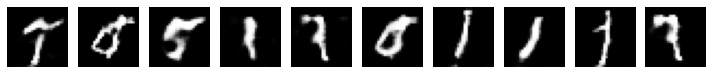

1300 [D loss: 0.196534, acc.: 91.41%] [G loss: 2.466056]
1301 [D loss: 0.224162, acc.: 91.41%] [G loss: 2.306230]
1302 [D loss: 0.155657, acc.: 94.53%] [G loss: 2.686464]
1303 [D loss: 0.190213, acc.: 92.19%] [G loss: 2.915979]
1304 [D loss: 0.168941, acc.: 92.97%] [G loss: 2.521039]
1305 [D loss: 0.259960, acc.: 89.06%] [G loss: 2.286829]
1306 [D loss: 0.263986, acc.: 89.06%] [G loss: 2.175958]
1307 [D loss: 0.158276, acc.: 91.41%] [G loss: 2.790298]
1308 [D loss: 0.140820, acc.: 93.75%] [G loss: 3.024064]
1309 [D loss: 0.115296, acc.: 95.31%] [G loss: 3.126616]
1310 [D loss: 0.198904, acc.: 92.97%] [G loss: 2.827392]
1311 [D loss: 0.145914, acc.: 94.53%] [G loss: 2.314247]
1312 [D loss: 0.129268, acc.: 96.09%] [G loss: 2.836237]
1313 [D loss: 0.126294, acc.: 93.75%] [G loss: 3.304332]
1314 [D loss: 0.130169, acc.: 95.31%] [G loss: 3.517322]
1315 [D loss: 0.146788, acc.: 96.88%] [G loss: 3.238260]
1316 [D loss: 0.112302, acc.: 96.09%] [G loss: 2.850315]
1317 [D loss: 0.167966, acc.: 9

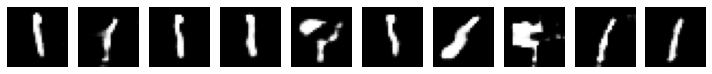

1400 [D loss: 0.225017, acc.: 89.06%] [G loss: 2.710470]
1401 [D loss: 0.194736, acc.: 92.19%] [G loss: 2.683563]
1402 [D loss: 0.137646, acc.: 93.75%] [G loss: 2.631451]
1403 [D loss: 0.114527, acc.: 96.09%] [G loss: 2.723022]
1404 [D loss: 0.182459, acc.: 95.31%] [G loss: 2.408898]
1405 [D loss: 0.118395, acc.: 96.09%] [G loss: 2.521920]
1406 [D loss: 0.254588, acc.: 89.06%] [G loss: 2.544968]
1407 [D loss: 0.256481, acc.: 88.28%] [G loss: 2.151421]
1408 [D loss: 0.190704, acc.: 92.19%] [G loss: 2.152376]
1409 [D loss: 0.116279, acc.: 95.31%] [G loss: 2.618122]
1410 [D loss: 0.159470, acc.: 93.75%] [G loss: 2.718267]
1411 [D loss: 0.129771, acc.: 96.09%] [G loss: 2.885407]
1412 [D loss: 0.090888, acc.: 96.88%] [G loss: 2.828445]
1413 [D loss: 0.162225, acc.: 94.53%] [G loss: 2.634219]
1414 [D loss: 0.162865, acc.: 93.75%] [G loss: 2.013098]
1415 [D loss: 0.177745, acc.: 92.97%] [G loss: 1.940108]
1416 [D loss: 0.134879, acc.: 97.66%] [G loss: 2.209618]
1417 [D loss: 0.128284, acc.: 9

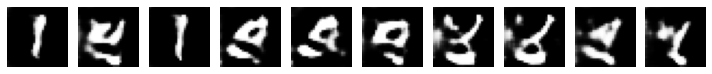

1500 [D loss: 0.129116, acc.: 94.53%] [G loss: 2.684672]
1501 [D loss: 0.159950, acc.: 92.19%] [G loss: 3.074032]
1502 [D loss: 0.158822, acc.: 93.75%] [G loss: 2.862162]
1503 [D loss: 0.329859, acc.: 86.72%] [G loss: 2.102388]
1504 [D loss: 0.155473, acc.: 94.53%] [G loss: 1.805323]
1505 [D loss: 0.173093, acc.: 94.53%] [G loss: 2.024618]
1506 [D loss: 0.130536, acc.: 95.31%] [G loss: 2.285238]
1507 [D loss: 0.182105, acc.: 91.41%] [G loss: 2.139459]
1508 [D loss: 0.051116, acc.: 97.66%] [G loss: 1.501236]
1509 [D loss: 0.057964, acc.: 98.44%] [G loss: 1.333189]
1510 [D loss: 0.047914, acc.: 98.44%] [G loss: 1.182646]
1511 [D loss: 0.049114, acc.: 98.44%] [G loss: 0.718130]
1512 [D loss: 0.019684, acc.: 100.00%] [G loss: 0.576696]
1513 [D loss: 0.051947, acc.: 98.44%] [G loss: 0.434159]
1514 [D loss: 0.101549, acc.: 96.09%] [G loss: 0.259816]
1515 [D loss: 0.039988, acc.: 99.22%] [G loss: 0.286726]
1516 [D loss: 0.079714, acc.: 97.66%] [G loss: 0.159602]
1517 [D loss: 0.060650, acc.: 

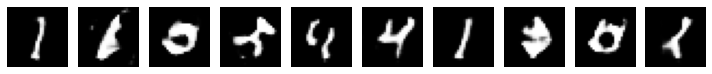

1600 [D loss: 0.114872, acc.: 96.09%] [G loss: 1.601884]
1601 [D loss: 0.139202, acc.: 94.53%] [G loss: 2.447692]
1602 [D loss: 0.091347, acc.: 98.44%] [G loss: 3.144652]
1603 [D loss: 0.092082, acc.: 96.09%] [G loss: 3.614151]
1604 [D loss: 0.147647, acc.: 94.53%] [G loss: 3.735628]
1605 [D loss: 0.144764, acc.: 95.31%] [G loss: 3.127972]
1606 [D loss: 0.164316, acc.: 94.53%] [G loss: 2.561578]
1607 [D loss: 0.182511, acc.: 93.75%] [G loss: 2.419318]
1608 [D loss: 0.167256, acc.: 92.19%] [G loss: 3.164288]
1609 [D loss: 0.187225, acc.: 92.97%] [G loss: 3.823688]
1610 [D loss: 0.102555, acc.: 94.53%] [G loss: 3.868156]
1611 [D loss: 0.209090, acc.: 92.19%] [G loss: 2.764525]
1612 [D loss: 0.170438, acc.: 92.97%] [G loss: 2.091239]
1613 [D loss: 0.185214, acc.: 91.41%] [G loss: 1.882388]
1614 [D loss: 0.205213, acc.: 91.41%] [G loss: 1.932275]
1615 [D loss: 0.091906, acc.: 96.88%] [G loss: 2.541425]
1616 [D loss: 0.109013, acc.: 96.88%] [G loss: 2.953758]
1617 [D loss: 0.220187, acc.: 9

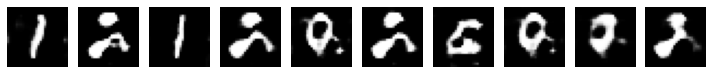

1700 [D loss: 0.097983, acc.: 96.09%] [G loss: 4.457206]
1701 [D loss: 0.294599, acc.: 91.41%] [G loss: 3.077914]
1702 [D loss: 0.177660, acc.: 92.19%] [G loss: 2.260133]
1703 [D loss: 0.206124, acc.: 92.19%] [G loss: 2.833792]
1704 [D loss: 0.066119, acc.: 96.88%] [G loss: 4.132586]
1705 [D loss: 0.146547, acc.: 95.31%] [G loss: 4.083952]
1706 [D loss: 0.135439, acc.: 96.09%] [G loss: 3.445922]
1707 [D loss: 0.115274, acc.: 96.88%] [G loss: 2.445187]
1708 [D loss: 0.096973, acc.: 96.88%] [G loss: 1.873038]
1709 [D loss: 0.238730, acc.: 89.06%] [G loss: 1.459474]
1710 [D loss: 0.118062, acc.: 94.53%] [G loss: 1.437221]
1711 [D loss: 0.175979, acc.: 93.75%] [G loss: 2.306483]
1712 [D loss: 0.074226, acc.: 99.22%] [G loss: 2.984218]
1713 [D loss: 0.141032, acc.: 94.53%] [G loss: 2.281274]
1714 [D loss: 0.140834, acc.: 94.53%] [G loss: 1.896556]
1715 [D loss: 0.136956, acc.: 94.53%] [G loss: 1.007138]
1716 [D loss: 0.128400, acc.: 95.31%] [G loss: 1.171454]
1717 [D loss: 0.051485, acc.: 9

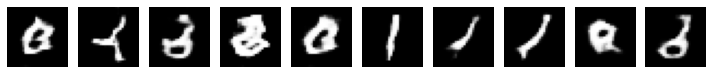

1800 [D loss: 0.082305, acc.: 96.09%] [G loss: 3.514270]
1801 [D loss: 0.173231, acc.: 94.53%] [G loss: 3.237535]
1802 [D loss: 0.109310, acc.: 95.31%] [G loss: 2.662963]
1803 [D loss: 0.144184, acc.: 92.19%] [G loss: 2.699289]
1804 [D loss: 0.119865, acc.: 96.09%] [G loss: 2.678416]
1805 [D loss: 0.094102, acc.: 96.09%] [G loss: 2.919631]
1806 [D loss: 0.115136, acc.: 96.88%] [G loss: 2.941293]
1807 [D loss: 0.092841, acc.: 96.09%] [G loss: 3.009607]
1808 [D loss: 0.116985, acc.: 94.53%] [G loss: 2.987898]
1809 [D loss: 0.119002, acc.: 95.31%] [G loss: 2.557570]
1810 [D loss: 0.091192, acc.: 95.31%] [G loss: 2.978153]
1811 [D loss: 0.118688, acc.: 96.09%] [G loss: 3.231091]
1812 [D loss: 0.103622, acc.: 96.09%] [G loss: 3.608873]
1813 [D loss: 0.059915, acc.: 98.44%] [G loss: 2.980073]
1814 [D loss: 0.078138, acc.: 94.53%] [G loss: 2.416176]
1815 [D loss: 0.134750, acc.: 96.09%] [G loss: 2.496532]
1816 [D loss: 0.084163, acc.: 97.66%] [G loss: 3.033593]
1817 [D loss: 0.114247, acc.: 9

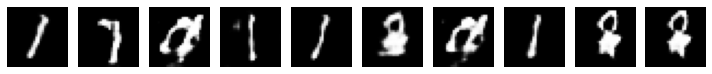

1900 [D loss: 0.107864, acc.: 97.66%] [G loss: 3.076262]
1901 [D loss: 0.187013, acc.: 93.75%] [G loss: 3.227393]
1902 [D loss: 0.061075, acc.: 98.44%] [G loss: 3.296135]
1903 [D loss: 0.069964, acc.: 97.66%] [G loss: 3.169445]
1904 [D loss: 0.081729, acc.: 95.31%] [G loss: 2.846117]
1905 [D loss: 0.138989, acc.: 92.19%] [G loss: 2.467270]
1906 [D loss: 0.143285, acc.: 93.75%] [G loss: 1.776849]
1907 [D loss: 0.136019, acc.: 96.09%] [G loss: 2.641337]
1908 [D loss: 0.126098, acc.: 95.31%] [G loss: 3.091462]
1909 [D loss: 0.132212, acc.: 95.31%] [G loss: 2.467702]
1910 [D loss: 0.108630, acc.: 96.88%] [G loss: 1.888664]
1911 [D loss: 0.157876, acc.: 93.75%] [G loss: 1.514726]
1912 [D loss: 0.199817, acc.: 90.62%] [G loss: 1.609310]
1913 [D loss: 0.209913, acc.: 92.19%] [G loss: 1.935763]
1914 [D loss: 0.195172, acc.: 91.41%] [G loss: 2.096976]
1915 [D loss: 0.370679, acc.: 86.72%] [G loss: 1.433123]
1916 [D loss: 0.111599, acc.: 95.31%] [G loss: 1.392848]
1917 [D loss: 0.103451, acc.: 9

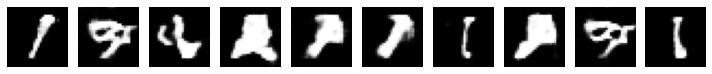

2000 [D loss: 0.089211, acc.: 96.09%] [G loss: 3.936071]
2001 [D loss: 0.050074, acc.: 97.66%] [G loss: 4.565330]
2002 [D loss: 0.086872, acc.: 96.09%] [G loss: 5.006131]
2003 [D loss: 0.078861, acc.: 95.31%] [G loss: 4.593925]
2004 [D loss: 0.070563, acc.: 96.88%] [G loss: 4.112028]
2005 [D loss: 0.037377, acc.: 99.22%] [G loss: 4.245320]
2006 [D loss: 0.044150, acc.: 98.44%] [G loss: 4.016458]
2007 [D loss: 0.069474, acc.: 96.09%] [G loss: 3.748861]
2008 [D loss: 0.104705, acc.: 95.31%] [G loss: 3.634773]
2009 [D loss: 0.035088, acc.: 99.22%] [G loss: 3.692858]
2010 [D loss: 0.136132, acc.: 93.75%] [G loss: 2.926739]
2011 [D loss: 0.078213, acc.: 97.66%] [G loss: 2.791294]
2012 [D loss: 0.164294, acc.: 92.19%] [G loss: 1.920054]
2013 [D loss: 0.089243, acc.: 96.09%] [G loss: 1.929491]
2014 [D loss: 0.102814, acc.: 96.88%] [G loss: 2.552250]
2015 [D loss: 0.250377, acc.: 92.97%] [G loss: 2.632995]
2016 [D loss: 0.255745, acc.: 91.41%] [G loss: 2.029133]
2017 [D loss: 0.111512, acc.: 9

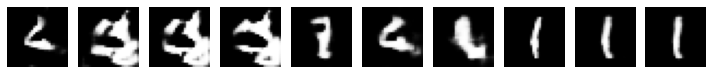

2100 [D loss: 0.114252, acc.: 96.09%] [G loss: 0.754270]
2101 [D loss: 0.266968, acc.: 89.84%] [G loss: 1.088419]
2102 [D loss: 0.126559, acc.: 95.31%] [G loss: 1.618486]
2103 [D loss: 0.036664, acc.: 99.22%] [G loss: 2.647900]
2104 [D loss: 0.040009, acc.: 100.00%] [G loss: 3.130140]
2105 [D loss: 0.186162, acc.: 91.41%] [G loss: 2.105792]
2106 [D loss: 0.108229, acc.: 96.09%] [G loss: 1.353486]
2107 [D loss: 0.151309, acc.: 93.75%] [G loss: 0.949679]
2108 [D loss: 0.093236, acc.: 95.31%] [G loss: 1.302515]
2109 [D loss: 0.103038, acc.: 96.88%] [G loss: 1.942043]
2110 [D loss: 0.085808, acc.: 97.66%] [G loss: 2.626749]
2111 [D loss: 0.159440, acc.: 93.75%] [G loss: 2.334484]
2112 [D loss: 0.236466, acc.: 89.06%] [G loss: 1.153050]
2113 [D loss: 0.168890, acc.: 91.41%] [G loss: 1.368046]
2114 [D loss: 0.078082, acc.: 96.88%] [G loss: 2.399232]
2115 [D loss: 0.091862, acc.: 96.09%] [G loss: 3.621726]
2116 [D loss: 0.134661, acc.: 94.53%] [G loss: 3.286931]
2117 [D loss: 0.096638, acc.: 

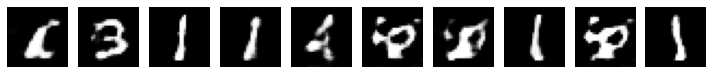

2200 [D loss: 0.122790, acc.: 96.88%] [G loss: 1.251702]
2201 [D loss: 0.059051, acc.: 97.66%] [G loss: 0.929245]
2202 [D loss: 0.134188, acc.: 92.97%] [G loss: 0.911968]
2203 [D loss: 0.095761, acc.: 97.66%] [G loss: 1.311290]
2204 [D loss: 0.102766, acc.: 95.31%] [G loss: 2.392556]
2205 [D loss: 0.104610, acc.: 95.31%] [G loss: 2.581596]
2206 [D loss: 0.188319, acc.: 95.31%] [G loss: 2.368392]
2207 [D loss: 0.100268, acc.: 97.66%] [G loss: 1.713387]
2208 [D loss: 0.082553, acc.: 96.09%] [G loss: 1.485300]
2209 [D loss: 0.045517, acc.: 99.22%] [G loss: 2.025752]
2210 [D loss: 0.076537, acc.: 96.88%] [G loss: 2.237841]
2211 [D loss: 0.157848, acc.: 92.19%] [G loss: 2.421080]
2212 [D loss: 0.111991, acc.: 95.31%] [G loss: 2.458340]
2213 [D loss: 0.142346, acc.: 94.53%] [G loss: 2.035159]
2214 [D loss: 0.115371, acc.: 95.31%] [G loss: 1.889144]
2215 [D loss: 0.129151, acc.: 93.75%] [G loss: 2.532622]
2216 [D loss: 0.083254, acc.: 95.31%] [G loss: 2.852767]
2217 [D loss: 0.134919, acc.: 9

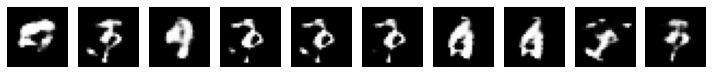

2300 [D loss: 0.108211, acc.: 96.09%] [G loss: 1.569078]
2301 [D loss: 0.130059, acc.: 95.31%] [G loss: 1.366241]
2302 [D loss: 0.202063, acc.: 92.19%] [G loss: 1.138283]
2303 [D loss: 0.138672, acc.: 92.97%] [G loss: 1.266780]
2304 [D loss: 0.174234, acc.: 93.75%] [G loss: 1.799180]
2305 [D loss: 0.134240, acc.: 97.66%] [G loss: 1.746598]
2306 [D loss: 0.170520, acc.: 93.75%] [G loss: 1.462285]
2307 [D loss: 0.092108, acc.: 94.53%] [G loss: 1.138925]
2308 [D loss: 0.167331, acc.: 92.97%] [G loss: 1.253734]
2309 [D loss: 0.100156, acc.: 96.09%] [G loss: 2.367866]
2310 [D loss: 0.084513, acc.: 96.88%] [G loss: 2.582293]
2311 [D loss: 0.120406, acc.: 95.31%] [G loss: 1.983875]
2312 [D loss: 0.250916, acc.: 91.41%] [G loss: 1.115699]
2313 [D loss: 0.158441, acc.: 94.53%] [G loss: 1.067037]
2314 [D loss: 0.105366, acc.: 96.88%] [G loss: 1.933246]
2315 [D loss: 0.145190, acc.: 93.75%] [G loss: 1.872624]
2316 [D loss: 0.101720, acc.: 96.09%] [G loss: 1.524780]
2317 [D loss: 0.106994, acc.: 9

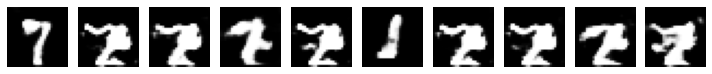

2400 [D loss: 0.071350, acc.: 97.66%] [G loss: 1.817841]
2401 [D loss: 0.077129, acc.: 97.66%] [G loss: 2.019155]
2402 [D loss: 0.082438, acc.: 97.66%] [G loss: 2.532454]
2403 [D loss: 0.045031, acc.: 99.22%] [G loss: 2.957441]
2404 [D loss: 0.207384, acc.: 91.41%] [G loss: 2.599036]
2405 [D loss: 0.127710, acc.: 94.53%] [G loss: 2.351861]
2406 [D loss: 0.104722, acc.: 96.88%] [G loss: 2.350733]
2407 [D loss: 0.039008, acc.: 98.44%] [G loss: 2.416051]
2408 [D loss: 0.241895, acc.: 94.53%] [G loss: 1.980488]
2409 [D loss: 0.156520, acc.: 94.53%] [G loss: 1.162586]
2410 [D loss: 0.102116, acc.: 97.66%] [G loss: 1.102260]
2411 [D loss: 0.109050, acc.: 94.53%] [G loss: 1.584159]
2412 [D loss: 0.133522, acc.: 91.41%] [G loss: 1.676442]
2413 [D loss: 0.105731, acc.: 94.53%] [G loss: 2.047228]
2414 [D loss: 0.168300, acc.: 93.75%] [G loss: 2.680735]
2415 [D loss: 0.080235, acc.: 96.09%] [G loss: 2.595730]
2416 [D loss: 0.179368, acc.: 94.53%] [G loss: 2.459929]
2417 [D loss: 0.073120, acc.: 9

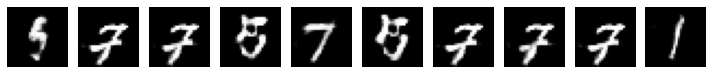

2500 [D loss: 0.078695, acc.: 96.09%] [G loss: 5.643946]
2501 [D loss: 0.136545, acc.: 92.97%] [G loss: 4.177993]
2502 [D loss: 0.170935, acc.: 93.75%] [G loss: 3.398481]
2503 [D loss: 0.083728, acc.: 96.88%] [G loss: 3.023077]
2504 [D loss: 0.138541, acc.: 94.53%] [G loss: 3.388164]
2505 [D loss: 0.059675, acc.: 98.44%] [G loss: 4.399116]
2506 [D loss: 0.084891, acc.: 98.44%] [G loss: 4.456429]
2507 [D loss: 0.181760, acc.: 94.53%] [G loss: 3.836599]
2508 [D loss: 0.143880, acc.: 93.75%] [G loss: 1.984298]
2509 [D loss: 0.159527, acc.: 94.53%] [G loss: 3.108664]
2510 [D loss: 0.167357, acc.: 92.19%] [G loss: 4.172569]
2511 [D loss: 0.097641, acc.: 95.31%] [G loss: 4.820775]
2512 [D loss: 0.151113, acc.: 95.31%] [G loss: 4.248614]
2513 [D loss: 0.182974, acc.: 92.19%] [G loss: 3.851106]
2514 [D loss: 0.180130, acc.: 92.19%] [G loss: 3.853185]
2515 [D loss: 0.130276, acc.: 93.75%] [G loss: 5.228090]
2516 [D loss: 0.147199, acc.: 92.19%] [G loss: 5.095493]
2517 [D loss: 0.165449, acc.: 9

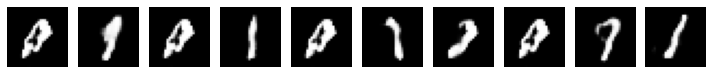

2600 [D loss: 0.071921, acc.: 96.88%] [G loss: 2.794720]
2601 [D loss: 0.127497, acc.: 94.53%] [G loss: 3.044980]
2602 [D loss: 0.050895, acc.: 96.88%] [G loss: 3.806117]
2603 [D loss: 0.098433, acc.: 95.31%] [G loss: 3.684817]
2604 [D loss: 0.064001, acc.: 98.44%] [G loss: 3.325112]
2605 [D loss: 0.117359, acc.: 96.09%] [G loss: 3.215804]
2606 [D loss: 0.054827, acc.: 97.66%] [G loss: 3.130915]
2607 [D loss: 0.153031, acc.: 92.19%] [G loss: 3.395362]
2608 [D loss: 0.068788, acc.: 96.09%] [G loss: 3.695119]
2609 [D loss: 0.084505, acc.: 98.44%] [G loss: 3.659323]
2610 [D loss: 0.079975, acc.: 97.66%] [G loss: 3.601863]
2611 [D loss: 0.104303, acc.: 96.09%] [G loss: 2.646003]
2612 [D loss: 0.184081, acc.: 91.41%] [G loss: 2.419464]
2613 [D loss: 0.140011, acc.: 96.09%] [G loss: 2.868191]
2614 [D loss: 0.149557, acc.: 94.53%] [G loss: 3.371057]
2615 [D loss: 0.075199, acc.: 97.66%] [G loss: 3.685418]
2616 [D loss: 0.123166, acc.: 93.75%] [G loss: 3.586570]
2617 [D loss: 0.091906, acc.: 9

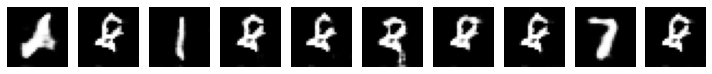

2700 [D loss: 0.080894, acc.: 96.88%] [G loss: 2.367550]
2701 [D loss: 0.128986, acc.: 94.53%] [G loss: 2.156247]
2702 [D loss: 0.077604, acc.: 96.88%] [G loss: 1.670719]
2703 [D loss: 0.108132, acc.: 96.09%] [G loss: 1.138305]
2704 [D loss: 0.081904, acc.: 95.31%] [G loss: 1.007651]
2705 [D loss: 0.088322, acc.: 96.09%] [G loss: 1.129432]
2706 [D loss: 0.079162, acc.: 98.44%] [G loss: 1.264890]
2707 [D loss: 0.139146, acc.: 93.75%] [G loss: 1.881848]
2708 [D loss: 0.031415, acc.: 99.22%] [G loss: 1.682109]
2709 [D loss: 0.123831, acc.: 95.31%] [G loss: 1.132330]
2710 [D loss: 0.141372, acc.: 94.53%] [G loss: 0.782846]
2711 [D loss: 0.110787, acc.: 94.53%] [G loss: 1.202461]
2712 [D loss: 0.112372, acc.: 93.75%] [G loss: 1.319533]
2713 [D loss: 0.096164, acc.: 96.09%] [G loss: 1.384102]
2714 [D loss: 0.163276, acc.: 94.53%] [G loss: 1.223433]
2715 [D loss: 0.153884, acc.: 94.53%] [G loss: 0.738660]
2716 [D loss: 0.231732, acc.: 86.72%] [G loss: 0.923266]
2717 [D loss: 0.117027, acc.: 9

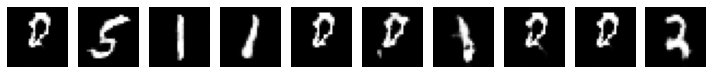

2800 [D loss: 0.166572, acc.: 92.97%] [G loss: 3.824288]
2801 [D loss: 0.094517, acc.: 96.09%] [G loss: 4.523572]
2802 [D loss: 0.031372, acc.: 98.44%] [G loss: 6.315545]
2803 [D loss: 0.139802, acc.: 93.75%] [G loss: 6.525712]
2804 [D loss: 0.088289, acc.: 96.88%] [G loss: 5.741831]
2805 [D loss: 0.121546, acc.: 95.31%] [G loss: 4.847745]
2806 [D loss: 0.090925, acc.: 94.53%] [G loss: 4.310455]
2807 [D loss: 0.111752, acc.: 95.31%] [G loss: 4.525326]
2808 [D loss: 0.078866, acc.: 96.88%] [G loss: 4.803436]
2809 [D loss: 0.088846, acc.: 96.88%] [G loss: 5.631779]
2810 [D loss: 0.095684, acc.: 96.09%] [G loss: 5.388510]
2811 [D loss: 0.126485, acc.: 93.75%] [G loss: 5.255941]
2812 [D loss: 0.116096, acc.: 95.31%] [G loss: 4.122489]
2813 [D loss: 0.142745, acc.: 94.53%] [G loss: 4.684843]
2814 [D loss: 0.162377, acc.: 93.75%] [G loss: 4.580441]
2815 [D loss: 0.051183, acc.: 99.22%] [G loss: 5.153338]
2816 [D loss: 0.059962, acc.: 97.66%] [G loss: 5.899035]
2817 [D loss: 0.200001, acc.: 9

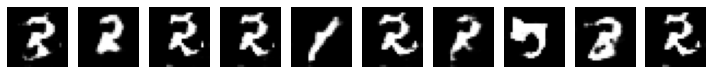

2900 [D loss: 0.124241, acc.: 93.75%] [G loss: 2.537237]
2901 [D loss: 0.094729, acc.: 95.31%] [G loss: 2.908904]
2902 [D loss: 0.135961, acc.: 94.53%] [G loss: 3.050195]
2903 [D loss: 0.131069, acc.: 95.31%] [G loss: 2.369307]
2904 [D loss: 0.128841, acc.: 94.53%] [G loss: 2.067870]
2905 [D loss: 0.091775, acc.: 95.31%] [G loss: 2.571870]
2906 [D loss: 0.076503, acc.: 96.09%] [G loss: 3.247285]
2907 [D loss: 0.154095, acc.: 93.75%] [G loss: 2.376504]
2908 [D loss: 0.097387, acc.: 95.31%] [G loss: 2.561341]
2909 [D loss: 0.083575, acc.: 96.88%] [G loss: 3.119300]
2910 [D loss: 0.057573, acc.: 98.44%] [G loss: 3.360856]
2911 [D loss: 0.092519, acc.: 96.09%] [G loss: 2.257177]
2912 [D loss: 0.089139, acc.: 95.31%] [G loss: 1.920367]
2913 [D loss: 0.105797, acc.: 96.88%] [G loss: 1.591872]
2914 [D loss: 0.082889, acc.: 96.09%] [G loss: 2.198377]
2915 [D loss: 0.109988, acc.: 96.09%] [G loss: 2.450765]
2916 [D loss: 0.129432, acc.: 95.31%] [G loss: 2.890566]
2917 [D loss: 0.048835, acc.: 9

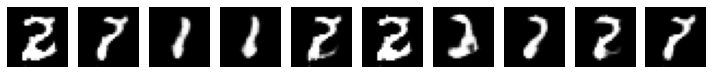

3000 [D loss: 0.105397, acc.: 96.09%] [G loss: 3.295692]
3001 [D loss: 0.059534, acc.: 97.66%] [G loss: 3.624518]
3002 [D loss: 0.077716, acc.: 96.88%] [G loss: 4.382885]
3003 [D loss: 0.066347, acc.: 97.66%] [G loss: 4.330544]
3004 [D loss: 0.060599, acc.: 97.66%] [G loss: 3.564955]
3005 [D loss: 0.150495, acc.: 95.31%] [G loss: 2.304051]
3006 [D loss: 0.145296, acc.: 95.31%] [G loss: 3.623376]
3007 [D loss: 0.038564, acc.: 99.22%] [G loss: 5.959528]
3008 [D loss: 0.131602, acc.: 96.09%] [G loss: 6.211245]
3009 [D loss: 0.145801, acc.: 96.09%] [G loss: 6.054091]
3010 [D loss: 0.078289, acc.: 95.31%] [G loss: 5.112617]
3011 [D loss: 0.070755, acc.: 96.88%] [G loss: 4.714420]
3012 [D loss: 0.053660, acc.: 97.66%] [G loss: 4.368356]
3013 [D loss: 0.106763, acc.: 96.09%] [G loss: 2.777538]
3014 [D loss: 0.238872, acc.: 93.75%] [G loss: 3.056940]
3015 [D loss: 0.091730, acc.: 96.88%] [G loss: 4.049758]
3016 [D loss: 0.139993, acc.: 96.09%] [G loss: 4.341051]
3017 [D loss: 0.117794, acc.: 9

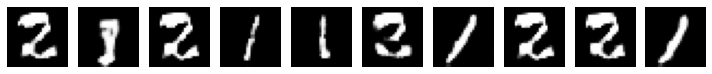

3100 [D loss: 0.139974, acc.: 95.31%] [G loss: 2.867928]
3101 [D loss: 0.057910, acc.: 98.44%] [G loss: 2.936547]
3102 [D loss: 0.116121, acc.: 96.09%] [G loss: 2.133500]
3103 [D loss: 0.130408, acc.: 93.75%] [G loss: 2.330071]
3104 [D loss: 0.065279, acc.: 97.66%] [G loss: 2.837714]
3105 [D loss: 0.099183, acc.: 97.66%] [G loss: 2.634793]
3106 [D loss: 0.029045, acc.: 99.22%] [G loss: 3.211038]
3107 [D loss: 0.046879, acc.: 99.22%] [G loss: 3.026443]
3108 [D loss: 0.093872, acc.: 96.09%] [G loss: 2.715823]
3109 [D loss: 0.116946, acc.: 95.31%] [G loss: 2.079518]
3110 [D loss: 0.061845, acc.: 98.44%] [G loss: 2.115261]
3111 [D loss: 0.099411, acc.: 96.88%] [G loss: 1.797752]
3112 [D loss: 0.076178, acc.: 97.66%] [G loss: 1.973981]
3113 [D loss: 0.110987, acc.: 96.88%] [G loss: 2.304302]
3114 [D loss: 0.198076, acc.: 93.75%] [G loss: 2.425972]
3115 [D loss: 0.146112, acc.: 92.97%] [G loss: 2.422653]
3116 [D loss: 0.107217, acc.: 96.09%] [G loss: 2.738847]
3117 [D loss: 0.131482, acc.: 9

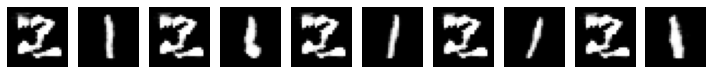

3200 [D loss: 0.046142, acc.: 99.22%] [G loss: 2.428588]
3201 [D loss: 0.043429, acc.: 99.22%] [G loss: 2.764009]
3202 [D loss: 0.169021, acc.: 92.97%] [G loss: 2.109512]
3203 [D loss: 0.063699, acc.: 98.44%] [G loss: 1.906766]
3204 [D loss: 0.123268, acc.: 96.09%] [G loss: 2.501484]
3205 [D loss: 0.168717, acc.: 95.31%] [G loss: 3.097172]
3206 [D loss: 0.150117, acc.: 93.75%] [G loss: 3.349511]
3207 [D loss: 0.101732, acc.: 95.31%] [G loss: 1.854671]
3208 [D loss: 0.147454, acc.: 95.31%] [G loss: 1.110281]
3209 [D loss: 0.181413, acc.: 92.19%] [G loss: 1.214917]
3210 [D loss: 0.154886, acc.: 93.75%] [G loss: 1.479572]
3211 [D loss: 0.053646, acc.: 98.44%] [G loss: 2.840218]
3212 [D loss: 0.072010, acc.: 96.09%] [G loss: 3.698917]
3213 [D loss: 0.154371, acc.: 95.31%] [G loss: 3.635824]
3214 [D loss: 0.158959, acc.: 95.31%] [G loss: 3.338755]
3215 [D loss: 0.152405, acc.: 93.75%] [G loss: 2.473238]
3216 [D loss: 0.092768, acc.: 96.09%] [G loss: 2.950017]
3217 [D loss: 0.096247, acc.: 9

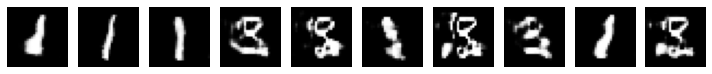

3300 [D loss: 0.137879, acc.: 93.75%] [G loss: 1.380042]
3301 [D loss: 0.124823, acc.: 95.31%] [G loss: 1.679320]
3302 [D loss: 0.068217, acc.: 97.66%] [G loss: 2.623768]
3303 [D loss: 0.053111, acc.: 98.44%] [G loss: 3.117355]
3304 [D loss: 0.034939, acc.: 98.44%] [G loss: 3.570133]
3305 [D loss: 0.262372, acc.: 92.19%] [G loss: 1.718672]
3306 [D loss: 0.231167, acc.: 89.84%] [G loss: 1.037646]
3307 [D loss: 0.213834, acc.: 89.84%] [G loss: 1.605097]
3308 [D loss: 0.133247, acc.: 96.09%] [G loss: 4.680194]
3309 [D loss: 0.108641, acc.: 95.31%] [G loss: 6.228597]
3310 [D loss: 0.116340, acc.: 93.75%] [G loss: 6.021946]
3311 [D loss: 0.191401, acc.: 92.19%] [G loss: 5.117930]
3312 [D loss: 0.211250, acc.: 90.62%] [G loss: 5.125756]
3313 [D loss: 0.073981, acc.: 97.66%] [G loss: 6.341103]
3314 [D loss: 0.163453, acc.: 92.97%] [G loss: 6.504554]
3315 [D loss: 0.091882, acc.: 96.88%] [G loss: 6.350998]
3316 [D loss: 0.088016, acc.: 96.88%] [G loss: 5.443483]
3317 [D loss: 0.115362, acc.: 9

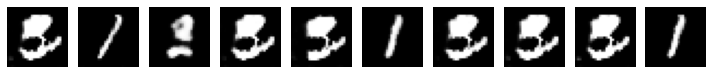

3400 [D loss: 0.048201, acc.: 98.44%] [G loss: 3.734078]
3401 [D loss: 0.081806, acc.: 96.09%] [G loss: 3.373338]
3402 [D loss: 0.029699, acc.: 99.22%] [G loss: 3.669116]
3403 [D loss: 0.097838, acc.: 96.88%] [G loss: 3.078610]
3404 [D loss: 0.096223, acc.: 96.88%] [G loss: 2.589607]
3405 [D loss: 0.110776, acc.: 95.31%] [G loss: 2.834136]
3406 [D loss: 0.086214, acc.: 96.88%] [G loss: 3.613157]
3407 [D loss: 0.071120, acc.: 96.09%] [G loss: 3.681451]
3408 [D loss: 0.030570, acc.: 98.44%] [G loss: 4.677976]
3409 [D loss: 0.059993, acc.: 98.44%] [G loss: 4.473564]
3410 [D loss: 0.060267, acc.: 98.44%] [G loss: 5.094605]
3411 [D loss: 0.104334, acc.: 95.31%] [G loss: 4.660911]
3412 [D loss: 0.083766, acc.: 95.31%] [G loss: 3.353500]
3413 [D loss: 0.104881, acc.: 96.09%] [G loss: 3.603436]
3414 [D loss: 0.037711, acc.: 99.22%] [G loss: 4.565488]
3415 [D loss: 0.052008, acc.: 98.44%] [G loss: 4.786096]
3416 [D loss: 0.054767, acc.: 97.66%] [G loss: 4.133699]
3417 [D loss: 0.033180, acc.: 9

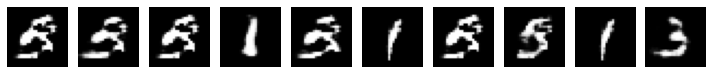

3500 [D loss: 0.036678, acc.: 98.44%] [G loss: 6.572649]
3501 [D loss: 0.044432, acc.: 98.44%] [G loss: 5.593204]
3502 [D loss: 0.112938, acc.: 96.09%] [G loss: 4.106496]
3503 [D loss: 0.076640, acc.: 96.88%] [G loss: 4.337404]
3504 [D loss: 0.049320, acc.: 98.44%] [G loss: 4.776085]
3505 [D loss: 0.081417, acc.: 98.44%] [G loss: 5.438371]
3506 [D loss: 0.039184, acc.: 98.44%] [G loss: 4.775463]
3507 [D loss: 0.097127, acc.: 96.09%] [G loss: 3.327092]
3508 [D loss: 0.074699, acc.: 96.88%] [G loss: 3.253882]
3509 [D loss: 0.039676, acc.: 99.22%] [G loss: 3.937502]
3510 [D loss: 0.085847, acc.: 96.09%] [G loss: 4.666456]
3511 [D loss: 0.033510, acc.: 98.44%] [G loss: 5.267044]
3512 [D loss: 0.055286, acc.: 98.44%] [G loss: 6.102677]
3513 [D loss: 0.071708, acc.: 96.88%] [G loss: 5.849219]
3514 [D loss: 0.064054, acc.: 97.66%] [G loss: 5.016698]
3515 [D loss: 0.116080, acc.: 96.88%] [G loss: 3.552156]
3516 [D loss: 0.161307, acc.: 93.75%] [G loss: 2.673366]
3517 [D loss: 0.049913, acc.: 9

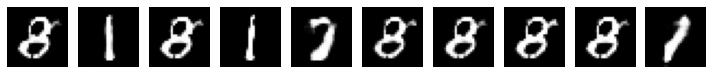

3600 [D loss: 0.141200, acc.: 94.53%] [G loss: 3.294657]
3601 [D loss: 0.042552, acc.: 97.66%] [G loss: 4.375916]
3602 [D loss: 0.058539, acc.: 97.66%] [G loss: 5.055351]
3603 [D loss: 0.120777, acc.: 95.31%] [G loss: 4.439415]
3604 [D loss: 0.086126, acc.: 96.09%] [G loss: 3.397975]
3605 [D loss: 0.101495, acc.: 94.53%] [G loss: 2.731449]
3606 [D loss: 0.084672, acc.: 96.09%] [G loss: 2.627682]
3607 [D loss: 0.044535, acc.: 98.44%] [G loss: 2.878832]
3608 [D loss: 0.078473, acc.: 95.31%] [G loss: 2.741859]
3609 [D loss: 0.148035, acc.: 94.53%] [G loss: 2.061177]
3610 [D loss: 0.050969, acc.: 98.44%] [G loss: 1.519421]
3611 [D loss: 0.134731, acc.: 94.53%] [G loss: 1.949754]
3612 [D loss: 0.044158, acc.: 99.22%] [G loss: 2.934997]
3613 [D loss: 0.054178, acc.: 96.88%] [G loss: 3.626455]
3614 [D loss: 0.094272, acc.: 96.09%] [G loss: 2.963337]
3615 [D loss: 0.080099, acc.: 96.09%] [G loss: 2.402302]
3616 [D loss: 0.144862, acc.: 94.53%] [G loss: 2.355212]
3617 [D loss: 0.030331, acc.: 9

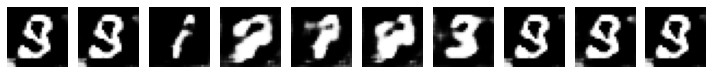

3700 [D loss: 0.049999, acc.: 96.88%] [G loss: 5.224532]
3701 [D loss: 0.140910, acc.: 93.75%] [G loss: 5.019430]
3702 [D loss: 0.098071, acc.: 95.31%] [G loss: 3.542571]
3703 [D loss: 0.060578, acc.: 97.66%] [G loss: 3.335221]
3704 [D loss: 0.060628, acc.: 97.66%] [G loss: 3.773753]
3705 [D loss: 0.033133, acc.: 99.22%] [G loss: 4.615648]
3706 [D loss: 0.087028, acc.: 96.88%] [G loss: 5.059498]
3707 [D loss: 0.133874, acc.: 95.31%] [G loss: 4.242110]
3708 [D loss: 0.125516, acc.: 95.31%] [G loss: 3.374555]
3709 [D loss: 0.101254, acc.: 94.53%] [G loss: 4.119223]
3710 [D loss: 0.019258, acc.: 100.00%] [G loss: 5.144112]
3711 [D loss: 0.051804, acc.: 98.44%] [G loss: 5.141902]
3712 [D loss: 0.076271, acc.: 96.09%] [G loss: 4.804019]
3713 [D loss: 0.082532, acc.: 95.31%] [G loss: 4.562780]
3714 [D loss: 0.058580, acc.: 96.88%] [G loss: 3.829379]
3715 [D loss: 0.030343, acc.: 98.44%] [G loss: 3.024542]
3716 [D loss: 0.073018, acc.: 97.66%] [G loss: 3.128516]
3717 [D loss: 0.051742, acc.: 

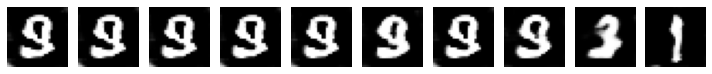

3800 [D loss: 0.105668, acc.: 93.75%] [G loss: 1.768950]
3801 [D loss: 0.056321, acc.: 97.66%] [G loss: 2.630455]
3802 [D loss: 0.061038, acc.: 97.66%] [G loss: 2.762899]
3803 [D loss: 0.059915, acc.: 96.88%] [G loss: 2.428640]
3804 [D loss: 0.123451, acc.: 96.88%] [G loss: 1.755087]
3805 [D loss: 0.084718, acc.: 95.31%] [G loss: 1.401143]
3806 [D loss: 0.070670, acc.: 97.66%] [G loss: 1.991675]
3807 [D loss: 0.047787, acc.: 97.66%] [G loss: 2.394326]
3808 [D loss: 0.062090, acc.: 98.44%] [G loss: 2.589475]
3809 [D loss: 0.041784, acc.: 97.66%] [G loss: 2.498103]
3810 [D loss: 0.013373, acc.: 100.00%] [G loss: 3.514761]
3811 [D loss: 0.047854, acc.: 96.88%] [G loss: 3.737644]
3812 [D loss: 0.049055, acc.: 98.44%] [G loss: 3.203954]
3813 [D loss: 0.098184, acc.: 95.31%] [G loss: 2.426086]
3814 [D loss: 0.041143, acc.: 99.22%] [G loss: 2.272030]
3815 [D loss: 0.041346, acc.: 99.22%] [G loss: 1.852172]
3816 [D loss: 0.060307, acc.: 98.44%] [G loss: 2.004128]
3817 [D loss: 0.029726, acc.: 

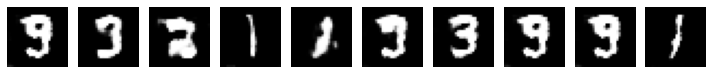

3900 [D loss: 0.038802, acc.: 98.44%] [G loss: 1.726382]
3901 [D loss: 0.120742, acc.: 96.88%] [G loss: 2.865430]
3902 [D loss: 0.021829, acc.: 99.22%] [G loss: 5.039711]
3903 [D loss: 0.012995, acc.: 99.22%] [G loss: 6.966008]
3904 [D loss: 0.034344, acc.: 98.44%] [G loss: 7.039195]
3905 [D loss: 0.090210, acc.: 96.88%] [G loss: 6.422540]
3906 [D loss: 0.036758, acc.: 98.44%] [G loss: 4.120633]
3907 [D loss: 0.037704, acc.: 98.44%] [G loss: 3.110766]
3908 [D loss: 0.183662, acc.: 96.09%] [G loss: 2.984133]
3909 [D loss: 0.025340, acc.: 99.22%] [G loss: 4.568879]
3910 [D loss: 0.069017, acc.: 98.44%] [G loss: 5.421026]
3911 [D loss: 0.048801, acc.: 98.44%] [G loss: 4.907735]
3912 [D loss: 0.024222, acc.: 99.22%] [G loss: 4.643388]
3913 [D loss: 0.034098, acc.: 98.44%] [G loss: 4.246974]
3914 [D loss: 0.096152, acc.: 96.88%] [G loss: 3.327477]
3915 [D loss: 0.016093, acc.: 99.22%] [G loss: 3.432671]
3916 [D loss: 0.030925, acc.: 98.44%] [G loss: 3.729705]
3917 [D loss: 0.029868, acc.: 9

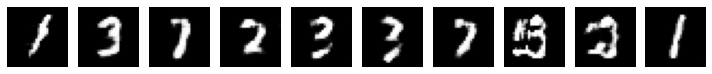

4000 [D loss: 0.017163, acc.: 100.00%] [G loss: 2.726475]
4001 [D loss: 0.128781, acc.: 94.53%] [G loss: 4.880242]
4002 [D loss: 0.136768, acc.: 96.09%] [G loss: 6.414826]
4003 [D loss: 0.124002, acc.: 93.75%] [G loss: 7.250013]
4004 [D loss: 0.043181, acc.: 99.22%] [G loss: 8.862417]
4005 [D loss: 0.071906, acc.: 97.66%] [G loss: 8.787443]
4006 [D loss: 0.096611, acc.: 95.31%] [G loss: 7.346306]
4007 [D loss: 0.054555, acc.: 98.44%] [G loss: 6.396871]
4008 [D loss: 0.128903, acc.: 93.75%] [G loss: 5.546632]
4009 [D loss: 0.087510, acc.: 95.31%] [G loss: 5.575871]
4010 [D loss: 0.120533, acc.: 96.88%] [G loss: 4.556018]
4011 [D loss: 0.078606, acc.: 97.66%] [G loss: 3.645368]
4012 [D loss: 0.137428, acc.: 96.09%] [G loss: 2.450463]
4013 [D loss: 0.135391, acc.: 96.88%] [G loss: 3.267808]
4014 [D loss: 0.023264, acc.: 99.22%] [G loss: 5.576740]
4015 [D loss: 0.112886, acc.: 96.09%] [G loss: 5.117502]
4016 [D loss: 0.111312, acc.: 96.09%] [G loss: 3.535077]
4017 [D loss: 0.208342, acc.: 

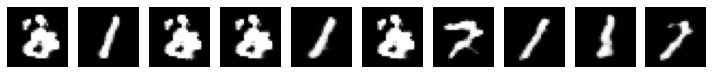

4100 [D loss: 0.043597, acc.: 98.44%] [G loss: 4.230731]
4101 [D loss: 0.090324, acc.: 96.09%] [G loss: 4.142894]
4102 [D loss: 0.193660, acc.: 89.84%] [G loss: 3.233720]
4103 [D loss: 0.147991, acc.: 93.75%] [G loss: 4.182915]
4104 [D loss: 0.178735, acc.: 89.06%] [G loss: 6.606704]
4105 [D loss: 0.062073, acc.: 96.88%] [G loss: 8.799362]
4106 [D loss: 0.191836, acc.: 91.41%] [G loss: 8.794432]
4107 [D loss: 0.135676, acc.: 94.53%] [G loss: 7.923442]
4108 [D loss: 0.103307, acc.: 96.09%] [G loss: 6.887823]
4109 [D loss: 0.153042, acc.: 91.41%] [G loss: 5.512500]
4110 [D loss: 0.091577, acc.: 96.09%] [G loss: 5.790504]
4111 [D loss: 0.038897, acc.: 99.22%] [G loss: 6.022194]
4112 [D loss: 0.041551, acc.: 99.22%] [G loss: 5.618717]
4113 [D loss: 0.060954, acc.: 97.66%] [G loss: 4.588405]
4114 [D loss: 0.018900, acc.: 100.00%] [G loss: 4.527597]
4115 [D loss: 0.023761, acc.: 99.22%] [G loss: 3.814448]
4116 [D loss: 0.105013, acc.: 96.09%] [G loss: 3.006293]
4117 [D loss: 0.067762, acc.: 

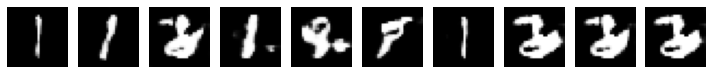

4200 [D loss: 0.054207, acc.: 96.88%] [G loss: 5.933600]
4201 [D loss: 0.092166, acc.: 96.09%] [G loss: 3.983046]
4202 [D loss: 0.119271, acc.: 95.31%] [G loss: 2.640723]
4203 [D loss: 0.206109, acc.: 94.53%] [G loss: 2.279237]
4204 [D loss: 0.029714, acc.: 99.22%] [G loss: 3.277991]
4205 [D loss: 0.079117, acc.: 96.88%] [G loss: 3.390701]
4206 [D loss: 0.053386, acc.: 98.44%] [G loss: 3.193353]
4207 [D loss: 0.052694, acc.: 98.44%] [G loss: 3.160124]
4208 [D loss: 0.117114, acc.: 96.88%] [G loss: 3.585160]
4209 [D loss: 0.049406, acc.: 97.66%] [G loss: 4.543806]
4210 [D loss: 0.074853, acc.: 96.88%] [G loss: 4.300035]
4211 [D loss: 0.088354, acc.: 96.88%] [G loss: 4.746005]
4212 [D loss: 0.057949, acc.: 97.66%] [G loss: 4.131565]
4213 [D loss: 0.145679, acc.: 98.44%] [G loss: 3.546898]
4214 [D loss: 0.027652, acc.: 99.22%] [G loss: 2.794718]
4215 [D loss: 0.151723, acc.: 94.53%] [G loss: 2.015215]
4216 [D loss: 0.157931, acc.: 93.75%] [G loss: 2.756646]
4217 [D loss: 0.020394, acc.: 9

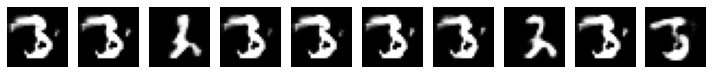

4300 [D loss: 0.057129, acc.: 96.88%] [G loss: 2.796814]
4301 [D loss: 0.035085, acc.: 97.66%] [G loss: 1.875110]
4302 [D loss: 0.079978, acc.: 96.09%] [G loss: 2.380009]
4303 [D loss: 0.048196, acc.: 97.66%] [G loss: 2.925824]
4304 [D loss: 0.051362, acc.: 98.44%] [G loss: 4.437722]
4305 [D loss: 0.099206, acc.: 96.88%] [G loss: 3.729939]
4306 [D loss: 0.127793, acc.: 95.31%] [G loss: 2.414629]
4307 [D loss: 0.076802, acc.: 97.66%] [G loss: 2.694898]
4308 [D loss: 0.057802, acc.: 98.44%] [G loss: 3.387899]
4309 [D loss: 0.036794, acc.: 99.22%] [G loss: 4.003612]
4310 [D loss: 0.108606, acc.: 96.88%] [G loss: 2.804421]
4311 [D loss: 0.139582, acc.: 94.53%] [G loss: 1.437445]
4312 [D loss: 0.126644, acc.: 95.31%] [G loss: 1.855576]
4313 [D loss: 0.052417, acc.: 96.88%] [G loss: 4.507215]
4314 [D loss: 0.085102, acc.: 96.88%] [G loss: 5.535535]
4315 [D loss: 0.164352, acc.: 95.31%] [G loss: 4.962360]
4316 [D loss: 0.039557, acc.: 99.22%] [G loss: 4.506032]
4317 [D loss: 0.055577, acc.: 9

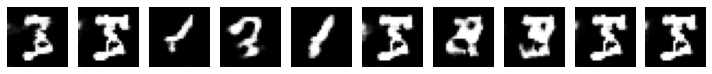

4400 [D loss: 0.030467, acc.: 99.22%] [G loss: 3.436147]
4401 [D loss: 0.037250, acc.: 99.22%] [G loss: 3.076873]
4402 [D loss: 0.060909, acc.: 95.31%] [G loss: 2.672282]
4403 [D loss: 0.043870, acc.: 97.66%] [G loss: 2.826057]
4404 [D loss: 0.015945, acc.: 100.00%] [G loss: 3.253535]
4405 [D loss: 0.041020, acc.: 98.44%] [G loss: 3.318702]
4406 [D loss: 0.053706, acc.: 98.44%] [G loss: 2.636614]
4407 [D loss: 0.059017, acc.: 98.44%] [G loss: 2.288036]
4408 [D loss: 0.064265, acc.: 96.88%] [G loss: 1.801035]
4409 [D loss: 0.068020, acc.: 96.88%] [G loss: 2.008340]
4410 [D loss: 0.050989, acc.: 97.66%] [G loss: 2.737410]
4411 [D loss: 0.059436, acc.: 96.88%] [G loss: 2.843115]
4412 [D loss: 0.030434, acc.: 98.44%] [G loss: 3.037509]
4413 [D loss: 0.041870, acc.: 98.44%] [G loss: 2.470904]
4414 [D loss: 0.052069, acc.: 97.66%] [G loss: 1.709691]
4415 [D loss: 0.183577, acc.: 95.31%] [G loss: 1.091652]
4416 [D loss: 0.091427, acc.: 96.09%] [G loss: 0.747678]
4417 [D loss: 0.120479, acc.: 

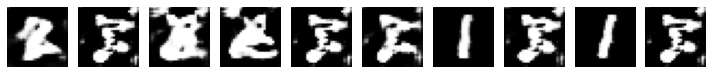

4500 [D loss: 0.081579, acc.: 97.66%] [G loss: 2.176487]
4501 [D loss: 0.157481, acc.: 94.53%] [G loss: 1.644563]
4502 [D loss: 0.076000, acc.: 97.66%] [G loss: 1.615789]
4503 [D loss: 0.042089, acc.: 99.22%] [G loss: 2.496567]
4504 [D loss: 0.050110, acc.: 97.66%] [G loss: 3.061482]
4505 [D loss: 0.122067, acc.: 95.31%] [G loss: 2.194756]
4506 [D loss: 0.043592, acc.: 98.44%] [G loss: 2.848730]
4507 [D loss: 0.112688, acc.: 95.31%] [G loss: 2.901130]
4508 [D loss: 0.051853, acc.: 98.44%] [G loss: 3.977185]
4509 [D loss: 0.016061, acc.: 99.22%] [G loss: 5.010133]
4510 [D loss: 0.097352, acc.: 97.66%] [G loss: 4.163177]
4511 [D loss: 0.086251, acc.: 96.09%] [G loss: 3.452805]
4512 [D loss: 0.074385, acc.: 96.09%] [G loss: 2.842086]
4513 [D loss: 0.062597, acc.: 97.66%] [G loss: 1.803593]
4514 [D loss: 0.067783, acc.: 99.22%] [G loss: 1.935754]
4515 [D loss: 0.056656, acc.: 97.66%] [G loss: 2.138314]
4516 [D loss: 0.028017, acc.: 98.44%] [G loss: 3.202006]
4517 [D loss: 0.096777, acc.: 9

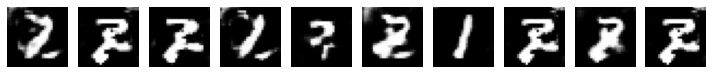

4600 [D loss: 0.049115, acc.: 96.09%] [G loss: 1.534641]
4601 [D loss: 0.082151, acc.: 96.09%] [G loss: 1.397794]
4602 [D loss: 0.029922, acc.: 99.22%] [G loss: 1.625572]
4603 [D loss: 0.027619, acc.: 99.22%] [G loss: 2.505987]
4604 [D loss: 0.067405, acc.: 97.66%] [G loss: 2.678149]
4605 [D loss: 0.042709, acc.: 98.44%] [G loss: 2.482987]
4606 [D loss: 0.031246, acc.: 99.22%] [G loss: 2.711226]
4607 [D loss: 0.076169, acc.: 96.88%] [G loss: 2.126383]
4608 [D loss: 0.085549, acc.: 94.53%] [G loss: 1.553417]
4609 [D loss: 0.038492, acc.: 99.22%] [G loss: 2.284761]
4610 [D loss: 0.044742, acc.: 98.44%] [G loss: 3.372827]
4611 [D loss: 0.076616, acc.: 96.88%] [G loss: 4.568868]
4612 [D loss: 0.039065, acc.: 98.44%] [G loss: 4.495893]
4613 [D loss: 0.034427, acc.: 98.44%] [G loss: 4.255174]
4614 [D loss: 0.017207, acc.: 99.22%] [G loss: 3.665940]
4615 [D loss: 0.085556, acc.: 95.31%] [G loss: 3.175575]
4616 [D loss: 0.053988, acc.: 96.88%] [G loss: 3.125803]
4617 [D loss: 0.050262, acc.: 9

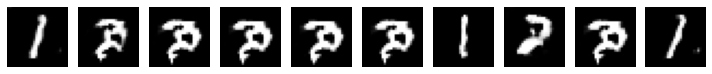

4700 [D loss: 0.008537, acc.: 100.00%] [G loss: 6.236661]
4701 [D loss: 0.057772, acc.: 98.44%] [G loss: 5.651326]
4702 [D loss: 0.053596, acc.: 98.44%] [G loss: 5.803808]
4703 [D loss: 0.048982, acc.: 98.44%] [G loss: 4.586648]
4704 [D loss: 0.033652, acc.: 99.22%] [G loss: 3.570695]
4705 [D loss: 0.042911, acc.: 99.22%] [G loss: 3.798316]
4706 [D loss: 0.130313, acc.: 95.31%] [G loss: 4.582968]
4707 [D loss: 0.029188, acc.: 99.22%] [G loss: 5.773773]
4708 [D loss: 0.037850, acc.: 98.44%] [G loss: 6.990849]
4709 [D loss: 0.081477, acc.: 96.88%] [G loss: 6.765263]
4710 [D loss: 0.027586, acc.: 99.22%] [G loss: 7.035522]
4711 [D loss: 0.093908, acc.: 96.09%] [G loss: 6.537338]
4712 [D loss: 0.057118, acc.: 98.44%] [G loss: 7.789064]
4713 [D loss: 0.044078, acc.: 98.44%] [G loss: 7.282681]
4714 [D loss: 0.078015, acc.: 97.66%] [G loss: 6.607163]
4715 [D loss: 0.040920, acc.: 98.44%] [G loss: 5.732229]
4716 [D loss: 0.052834, acc.: 97.66%] [G loss: 4.884421]
4717 [D loss: 0.062138, acc.: 

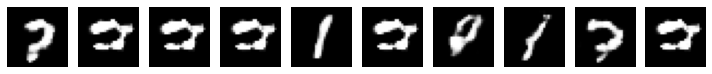

4800 [D loss: 0.062880, acc.: 98.44%] [G loss: 3.636415]
4801 [D loss: 0.073814, acc.: 98.44%] [G loss: 4.389055]
4802 [D loss: 0.159433, acc.: 94.53%] [G loss: 3.821749]
4803 [D loss: 0.086220, acc.: 97.66%] [G loss: 3.057114]
4804 [D loss: 0.074202, acc.: 97.66%] [G loss: 3.317474]
4805 [D loss: 0.036460, acc.: 99.22%] [G loss: 3.422962]
4806 [D loss: 0.054979, acc.: 98.44%] [G loss: 3.710565]
4807 [D loss: 0.050920, acc.: 99.22%] [G loss: 4.010133]
4808 [D loss: 0.048133, acc.: 97.66%] [G loss: 3.956106]
4809 [D loss: 0.117105, acc.: 95.31%] [G loss: 3.128551]
4810 [D loss: 0.101132, acc.: 96.88%] [G loss: 2.822000]
4811 [D loss: 0.077652, acc.: 96.88%] [G loss: 3.402959]
4812 [D loss: 0.103342, acc.: 95.31%] [G loss: 4.180189]
4813 [D loss: 0.100953, acc.: 96.88%] [G loss: 4.348114]
4814 [D loss: 0.084416, acc.: 96.88%] [G loss: 4.475711]
4815 [D loss: 0.054361, acc.: 97.66%] [G loss: 3.909887]
4816 [D loss: 0.041562, acc.: 97.66%] [G loss: 3.528503]
4817 [D loss: 0.062758, acc.: 9

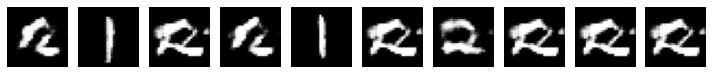

4900 [D loss: 0.049925, acc.: 99.22%] [G loss: 6.537312]
4901 [D loss: 0.021509, acc.: 100.00%] [G loss: 5.230388]
4902 [D loss: 0.035033, acc.: 99.22%] [G loss: 5.333172]
4903 [D loss: 0.019117, acc.: 99.22%] [G loss: 4.538876]
4904 [D loss: 0.065676, acc.: 98.44%] [G loss: 4.641619]
4905 [D loss: 0.039271, acc.: 97.66%] [G loss: 3.750943]
4906 [D loss: 0.048321, acc.: 96.88%] [G loss: 4.058924]
4907 [D loss: 0.123516, acc.: 93.75%] [G loss: 3.929743]
4908 [D loss: 0.011557, acc.: 100.00%] [G loss: 4.552817]
4909 [D loss: 0.077166, acc.: 97.66%] [G loss: 4.676999]
4910 [D loss: 0.114281, acc.: 96.88%] [G loss: 3.110866]
4911 [D loss: 0.027387, acc.: 100.00%] [G loss: 3.548304]
4912 [D loss: 0.042088, acc.: 99.22%] [G loss: 3.402190]
4913 [D loss: 0.069213, acc.: 96.88%] [G loss: 4.419264]
4914 [D loss: 0.046573, acc.: 96.88%] [G loss: 5.782428]
4915 [D loss: 0.163126, acc.: 92.19%] [G loss: 5.632126]
4916 [D loss: 0.030592, acc.: 99.22%] [G loss: 6.871230]
4917 [D loss: 0.031144, acc.

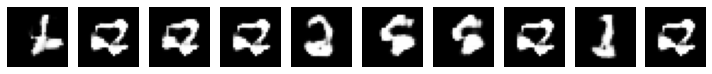

5000 [D loss: 0.038702, acc.: 97.66%] [G loss: 3.266715]
5001 [D loss: 0.021763, acc.: 98.44%] [G loss: 3.365914]
5002 [D loss: 0.039408, acc.: 99.22%] [G loss: 2.698170]
5003 [D loss: 0.036228, acc.: 98.44%] [G loss: 3.570474]
5004 [D loss: 0.014450, acc.: 100.00%] [G loss: 3.083644]
5005 [D loss: 0.047652, acc.: 97.66%] [G loss: 2.656673]
5006 [D loss: 0.026550, acc.: 99.22%] [G loss: 1.791590]
5007 [D loss: 0.019217, acc.: 100.00%] [G loss: 1.764317]
5008 [D loss: 0.014969, acc.: 99.22%] [G loss: 2.163264]
5009 [D loss: 0.030663, acc.: 99.22%] [G loss: 2.331265]
5010 [D loss: 0.015982, acc.: 100.00%] [G loss: 2.335382]
5011 [D loss: 0.023051, acc.: 99.22%] [G loss: 2.921350]
5012 [D loss: 0.048857, acc.: 97.66%] [G loss: 2.150564]
5013 [D loss: 0.012095, acc.: 100.00%] [G loss: 1.902744]
5014 [D loss: 0.024324, acc.: 99.22%] [G loss: 1.775150]
5015 [D loss: 0.033528, acc.: 99.22%] [G loss: 1.391897]
5016 [D loss: 0.045432, acc.: 98.44%] [G loss: 1.811316]
5017 [D loss: 0.017199, acc

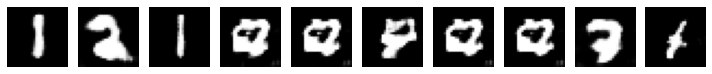

5100 [D loss: 0.072892, acc.: 96.09%] [G loss: 6.593774]
5101 [D loss: 0.083284, acc.: 96.09%] [G loss: 6.635892]
5102 [D loss: 0.025299, acc.: 98.44%] [G loss: 7.455560]
5103 [D loss: 0.036326, acc.: 98.44%] [G loss: 6.924290]
5104 [D loss: 0.045778, acc.: 96.88%] [G loss: 6.708831]
5105 [D loss: 0.023003, acc.: 99.22%] [G loss: 6.616593]
5106 [D loss: 0.032986, acc.: 99.22%] [G loss: 6.202117]
5107 [D loss: 0.070797, acc.: 96.88%] [G loss: 5.927529]
5108 [D loss: 0.051860, acc.: 98.44%] [G loss: 6.167764]
5109 [D loss: 0.066763, acc.: 98.44%] [G loss: 6.014804]
5110 [D loss: 0.068078, acc.: 98.44%] [G loss: 5.729823]
5111 [D loss: 0.046339, acc.: 96.88%] [G loss: 5.310141]
5112 [D loss: 0.048314, acc.: 97.66%] [G loss: 5.143395]
5113 [D loss: 0.039948, acc.: 99.22%] [G loss: 5.792012]
5114 [D loss: 0.057283, acc.: 99.22%] [G loss: 5.770829]
5115 [D loss: 0.018516, acc.: 100.00%] [G loss: 6.229133]
5116 [D loss: 0.017413, acc.: 99.22%] [G loss: 6.083522]
5117 [D loss: 0.029996, acc.: 

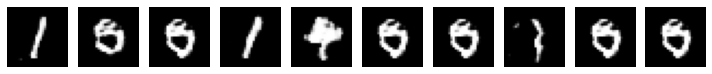

5200 [D loss: 0.130927, acc.: 96.09%] [G loss: 4.951482]
5201 [D loss: 0.125673, acc.: 97.66%] [G loss: 4.047856]
5202 [D loss: 0.046831, acc.: 98.44%] [G loss: 3.301428]
5203 [D loss: 0.039171, acc.: 98.44%] [G loss: 3.648173]
5204 [D loss: 0.053659, acc.: 98.44%] [G loss: 4.010241]
5205 [D loss: 0.051081, acc.: 98.44%] [G loss: 3.379392]
5206 [D loss: 0.060197, acc.: 99.22%] [G loss: 2.665555]
5207 [D loss: 0.044454, acc.: 98.44%] [G loss: 2.379225]
5208 [D loss: 0.061306, acc.: 97.66%] [G loss: 3.311204]
5209 [D loss: 0.049320, acc.: 99.22%] [G loss: 4.448396]
5210 [D loss: 0.086262, acc.: 95.31%] [G loss: 3.601342]
5211 [D loss: 0.073171, acc.: 96.88%] [G loss: 3.192103]
5212 [D loss: 0.071182, acc.: 96.88%] [G loss: 2.448776]
5213 [D loss: 0.069714, acc.: 98.44%] [G loss: 2.632731]
5214 [D loss: 0.114340, acc.: 93.75%] [G loss: 4.359926]
5215 [D loss: 0.023889, acc.: 98.44%] [G loss: 5.777331]
5216 [D loss: 0.042091, acc.: 98.44%] [G loss: 6.504533]
5217 [D loss: 0.050061, acc.: 9

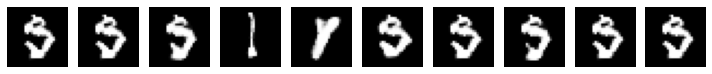

5300 [D loss: 0.092213, acc.: 97.66%] [G loss: 2.142155]
5301 [D loss: 0.117424, acc.: 92.97%] [G loss: 2.391925]
5302 [D loss: 0.097293, acc.: 96.88%] [G loss: 3.799610]
5303 [D loss: 0.082737, acc.: 96.09%] [G loss: 4.425684]
5304 [D loss: 0.048770, acc.: 98.44%] [G loss: 4.211083]
5305 [D loss: 0.090351, acc.: 96.09%] [G loss: 4.267467]
5306 [D loss: 0.220050, acc.: 93.75%] [G loss: 4.395480]
5307 [D loss: 0.107937, acc.: 96.88%] [G loss: 4.728728]
5308 [D loss: 0.052707, acc.: 97.66%] [G loss: 4.459136]
5309 [D loss: 0.154831, acc.: 96.09%] [G loss: 3.278236]
5310 [D loss: 0.047604, acc.: 99.22%] [G loss: 3.343228]
5311 [D loss: 0.149192, acc.: 94.53%] [G loss: 3.502736]
5312 [D loss: 0.015367, acc.: 100.00%] [G loss: 4.705537]
5313 [D loss: 0.014302, acc.: 100.00%] [G loss: 5.537841]
5314 [D loss: 0.127173, acc.: 95.31%] [G loss: 5.737192]
5315 [D loss: 0.037599, acc.: 100.00%] [G loss: 6.027586]
5316 [D loss: 0.053154, acc.: 97.66%] [G loss: 6.441199]
5317 [D loss: 0.087979, acc.

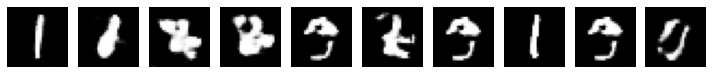

5400 [D loss: 0.054711, acc.: 97.66%] [G loss: 4.211308]
5401 [D loss: 0.050944, acc.: 98.44%] [G loss: 6.007844]
5402 [D loss: 0.075473, acc.: 95.31%] [G loss: 6.179622]
5403 [D loss: 0.127178, acc.: 96.09%] [G loss: 5.069041]
5404 [D loss: 0.052020, acc.: 96.88%] [G loss: 4.569717]
5405 [D loss: 0.057608, acc.: 98.44%] [G loss: 3.861704]
5406 [D loss: 0.066235, acc.: 98.44%] [G loss: 4.121863]
5407 [D loss: 0.049181, acc.: 98.44%] [G loss: 4.828938]
5408 [D loss: 0.026272, acc.: 99.22%] [G loss: 5.475926]
5409 [D loss: 0.047934, acc.: 98.44%] [G loss: 5.833090]
5410 [D loss: 0.054874, acc.: 98.44%] [G loss: 5.666500]
5411 [D loss: 0.035586, acc.: 98.44%] [G loss: 4.573259]
5412 [D loss: 0.053927, acc.: 97.66%] [G loss: 4.246110]
5413 [D loss: 0.051895, acc.: 98.44%] [G loss: 3.316478]
5414 [D loss: 0.071275, acc.: 97.66%] [G loss: 3.743513]
5415 [D loss: 0.027827, acc.: 99.22%] [G loss: 5.124455]
5416 [D loss: 0.050263, acc.: 97.66%] [G loss: 5.825828]
5417 [D loss: 0.106510, acc.: 9

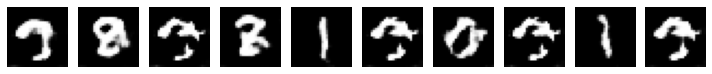

5500 [D loss: 0.070084, acc.: 97.66%] [G loss: 3.252211]
5501 [D loss: 0.084315, acc.: 96.88%] [G loss: 2.716368]
5502 [D loss: 0.100635, acc.: 96.88%] [G loss: 2.190764]
5503 [D loss: 0.034078, acc.: 99.22%] [G loss: 1.889182]
5504 [D loss: 0.045860, acc.: 99.22%] [G loss: 2.272016]
5505 [D loss: 0.066494, acc.: 98.44%] [G loss: 3.280021]
5506 [D loss: 0.018597, acc.: 99.22%] [G loss: 4.124211]
5507 [D loss: 0.048036, acc.: 98.44%] [G loss: 5.240083]
5508 [D loss: 0.031720, acc.: 98.44%] [G loss: 5.879577]
5509 [D loss: 0.094738, acc.: 97.66%] [G loss: 5.914395]
5510 [D loss: 0.020115, acc.: 100.00%] [G loss: 5.590374]
5511 [D loss: 0.080584, acc.: 97.66%] [G loss: 6.097330]
5512 [D loss: 0.079507, acc.: 96.09%] [G loss: 5.303236]
5513 [D loss: 0.038050, acc.: 98.44%] [G loss: 5.791140]
5514 [D loss: 0.064416, acc.: 97.66%] [G loss: 5.764999]
5515 [D loss: 0.042944, acc.: 98.44%] [G loss: 6.227751]
5516 [D loss: 0.108408, acc.: 96.09%] [G loss: 6.016497]
5517 [D loss: 0.039034, acc.: 

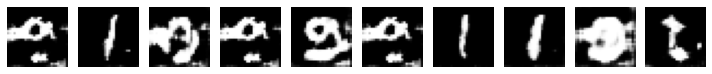

5600 [D loss: 0.045310, acc.: 98.44%] [G loss: 1.629966]
5601 [D loss: 0.066765, acc.: 97.66%] [G loss: 1.403686]
5602 [D loss: 0.082734, acc.: 97.66%] [G loss: 1.225088]
5603 [D loss: 0.027993, acc.: 100.00%] [G loss: 1.268142]
5604 [D loss: 0.060122, acc.: 97.66%] [G loss: 1.780837]
5605 [D loss: 0.040114, acc.: 99.22%] [G loss: 3.427604]
5606 [D loss: 0.026012, acc.: 99.22%] [G loss: 4.487283]
5607 [D loss: 0.055722, acc.: 96.09%] [G loss: 5.490646]
5608 [D loss: 0.028820, acc.: 99.22%] [G loss: 4.226999]
5609 [D loss: 0.047745, acc.: 97.66%] [G loss: 3.682558]
5610 [D loss: 0.031764, acc.: 97.66%] [G loss: 2.658862]
5611 [D loss: 0.023723, acc.: 100.00%] [G loss: 2.297482]
5612 [D loss: 0.103985, acc.: 96.09%] [G loss: 1.829629]
5613 [D loss: 0.027167, acc.: 99.22%] [G loss: 2.230092]
5614 [D loss: 0.083218, acc.: 96.88%] [G loss: 2.395038]
5615 [D loss: 0.016920, acc.: 99.22%] [G loss: 3.001286]
5616 [D loss: 0.022058, acc.: 99.22%] [G loss: 3.667919]
5617 [D loss: 0.103536, acc.:

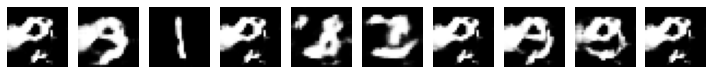

5700 [D loss: 0.026612, acc.: 99.22%] [G loss: 3.079959]
5701 [D loss: 0.015305, acc.: 99.22%] [G loss: 4.571173]
5702 [D loss: 0.107028, acc.: 97.66%] [G loss: 3.971054]
5703 [D loss: 0.040123, acc.: 98.44%] [G loss: 3.318060]
5704 [D loss: 0.079148, acc.: 96.88%] [G loss: 1.809466]
5705 [D loss: 0.113001, acc.: 96.88%] [G loss: 1.635641]
5706 [D loss: 0.121911, acc.: 94.53%] [G loss: 2.985574]
5707 [D loss: 0.022518, acc.: 99.22%] [G loss: 6.479594]
5708 [D loss: 0.103198, acc.: 95.31%] [G loss: 5.875566]
5709 [D loss: 0.075316, acc.: 96.09%] [G loss: 4.120502]
5710 [D loss: 0.059440, acc.: 97.66%] [G loss: 3.267784]
5711 [D loss: 0.121139, acc.: 94.53%] [G loss: 3.999094]
5712 [D loss: 0.038196, acc.: 98.44%] [G loss: 5.135576]
5713 [D loss: 0.057762, acc.: 97.66%] [G loss: 5.499321]
5714 [D loss: 0.029444, acc.: 99.22%] [G loss: 3.849810]
5715 [D loss: 0.060341, acc.: 96.09%] [G loss: 3.370831]
5716 [D loss: 0.015824, acc.: 99.22%] [G loss: 3.383069]
5717 [D loss: 0.034148, acc.: 9

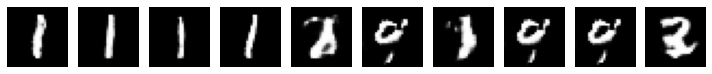

5800 [D loss: 0.100965, acc.: 94.53%] [G loss: 3.483730]
5801 [D loss: 0.039902, acc.: 99.22%] [G loss: 3.893804]
5802 [D loss: 0.136436, acc.: 92.97%] [G loss: 4.648592]
5803 [D loss: 0.051628, acc.: 99.22%] [G loss: 4.943130]
5804 [D loss: 0.126686, acc.: 95.31%] [G loss: 5.485917]
5805 [D loss: 0.083222, acc.: 96.09%] [G loss: 5.444121]
5806 [D loss: 0.039254, acc.: 99.22%] [G loss: 5.295453]
5807 [D loss: 0.029427, acc.: 99.22%] [G loss: 5.319465]
5808 [D loss: 0.017482, acc.: 99.22%] [G loss: 5.614347]
5809 [D loss: 0.079677, acc.: 96.88%] [G loss: 4.643621]
5810 [D loss: 0.095552, acc.: 97.66%] [G loss: 2.208739]
5811 [D loss: 0.152768, acc.: 93.75%] [G loss: 2.257782]
5812 [D loss: 0.048195, acc.: 98.44%] [G loss: 3.688615]
5813 [D loss: 0.050498, acc.: 96.88%] [G loss: 4.658569]
5814 [D loss: 0.136306, acc.: 96.88%] [G loss: 3.963551]
5815 [D loss: 0.081985, acc.: 96.09%] [G loss: 3.527149]
5816 [D loss: 0.045227, acc.: 98.44%] [G loss: 4.295385]
5817 [D loss: 0.066003, acc.: 9

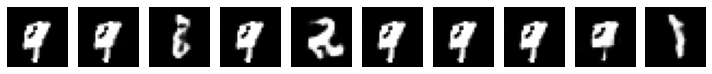

5900 [D loss: 0.026677, acc.: 100.00%] [G loss: 5.919337]
5901 [D loss: 0.033610, acc.: 100.00%] [G loss: 5.283749]
5902 [D loss: 0.054813, acc.: 96.88%] [G loss: 5.110420]
5903 [D loss: 0.073390, acc.: 96.88%] [G loss: 4.410973]
5904 [D loss: 0.064445, acc.: 96.88%] [G loss: 3.371952]
5905 [D loss: 0.038547, acc.: 99.22%] [G loss: 2.961070]
5906 [D loss: 0.052672, acc.: 97.66%] [G loss: 3.752442]
5907 [D loss: 0.040727, acc.: 99.22%] [G loss: 4.629050]
5908 [D loss: 0.020697, acc.: 99.22%] [G loss: 5.672532]
5909 [D loss: 0.028362, acc.: 99.22%] [G loss: 5.457198]
5910 [D loss: 0.082536, acc.: 97.66%] [G loss: 5.248544]
5911 [D loss: 0.017538, acc.: 99.22%] [G loss: 4.958494]
5912 [D loss: 0.020885, acc.: 99.22%] [G loss: 4.905494]
5913 [D loss: 0.116831, acc.: 96.09%] [G loss: 4.815092]
5914 [D loss: 0.054815, acc.: 96.88%] [G loss: 4.694714]
5915 [D loss: 0.012540, acc.: 100.00%] [G loss: 5.329787]
5916 [D loss: 0.024634, acc.: 99.22%] [G loss: 5.989534]
5917 [D loss: 0.121582, acc.

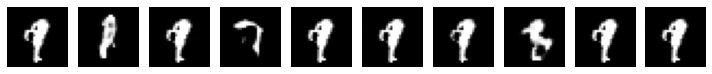

6000 [D loss: 0.100521, acc.: 96.09%] [G loss: 3.881612]
6001 [D loss: 0.064794, acc.: 97.66%] [G loss: 4.258734]
6002 [D loss: 0.026600, acc.: 99.22%] [G loss: 4.431050]
6003 [D loss: 0.041082, acc.: 98.44%] [G loss: 4.729095]
6004 [D loss: 0.034848, acc.: 97.66%] [G loss: 4.713260]
6005 [D loss: 0.042483, acc.: 99.22%] [G loss: 4.841261]
6006 [D loss: 0.072830, acc.: 96.09%] [G loss: 4.673596]
6007 [D loss: 0.041441, acc.: 98.44%] [G loss: 4.184660]
6008 [D loss: 0.072144, acc.: 98.44%] [G loss: 4.063291]
6009 [D loss: 0.062553, acc.: 98.44%] [G loss: 4.085250]
6010 [D loss: 0.041712, acc.: 100.00%] [G loss: 4.734089]
6011 [D loss: 0.088996, acc.: 96.88%] [G loss: 4.856173]
6012 [D loss: 0.052902, acc.: 97.66%] [G loss: 5.526964]
6013 [D loss: 0.045939, acc.: 98.44%] [G loss: 5.193802]
6014 [D loss: 0.100941, acc.: 95.31%] [G loss: 4.470659]
6015 [D loss: 0.065696, acc.: 98.44%] [G loss: 3.970158]
6016 [D loss: 0.052276, acc.: 97.66%] [G loss: 4.169393]
6017 [D loss: 0.065722, acc.: 

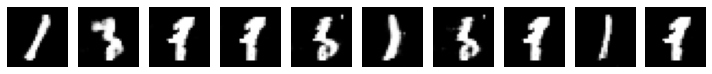

6100 [D loss: 0.131905, acc.: 93.75%] [G loss: 4.560423]
6101 [D loss: 0.065838, acc.: 96.88%] [G loss: 5.492358]
6102 [D loss: 0.066152, acc.: 98.44%] [G loss: 5.811255]
6103 [D loss: 0.052383, acc.: 98.44%] [G loss: 5.475080]
6104 [D loss: 0.158373, acc.: 92.97%] [G loss: 3.537713]
6105 [D loss: 0.115459, acc.: 96.88%] [G loss: 3.052014]
6106 [D loss: 0.138792, acc.: 92.97%] [G loss: 3.290714]
6107 [D loss: 0.032804, acc.: 97.66%] [G loss: 4.854102]
6108 [D loss: 0.076969, acc.: 96.09%] [G loss: 5.875779]
6109 [D loss: 0.040619, acc.: 97.66%] [G loss: 5.979390]
6110 [D loss: 0.049121, acc.: 98.44%] [G loss: 6.693338]
6111 [D loss: 0.044389, acc.: 97.66%] [G loss: 6.700313]
6112 [D loss: 0.073317, acc.: 96.09%] [G loss: 6.365658]
6113 [D loss: 0.063908, acc.: 98.44%] [G loss: 5.804184]
6114 [D loss: 0.043320, acc.: 98.44%] [G loss: 6.411807]
6115 [D loss: 0.053385, acc.: 97.66%] [G loss: 5.951299]
6116 [D loss: 0.047702, acc.: 99.22%] [G loss: 5.688045]
6117 [D loss: 0.037889, acc.: 9

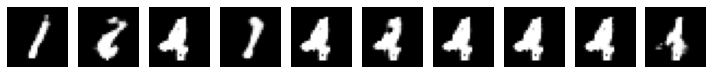

6200 [D loss: 0.051519, acc.: 98.44%] [G loss: 6.209736]
6201 [D loss: 0.044701, acc.: 98.44%] [G loss: 5.441573]
6202 [D loss: 0.029644, acc.: 98.44%] [G loss: 4.772039]
6203 [D loss: 0.051260, acc.: 98.44%] [G loss: 5.052144]
6204 [D loss: 0.077395, acc.: 96.88%] [G loss: 5.243716]
6205 [D loss: 0.072353, acc.: 98.44%] [G loss: 4.999065]
6206 [D loss: 0.034774, acc.: 99.22%] [G loss: 5.360092]
6207 [D loss: 0.093833, acc.: 97.66%] [G loss: 5.423408]
6208 [D loss: 0.033421, acc.: 98.44%] [G loss: 5.294288]
6209 [D loss: 0.034649, acc.: 100.00%] [G loss: 5.118201]
6210 [D loss: 0.039885, acc.: 98.44%] [G loss: 5.257409]
6211 [D loss: 0.097917, acc.: 95.31%] [G loss: 5.075229]
6212 [D loss: 0.045393, acc.: 97.66%] [G loss: 5.291823]
6213 [D loss: 0.044466, acc.: 98.44%] [G loss: 5.783540]
6214 [D loss: 0.046369, acc.: 97.66%] [G loss: 6.284104]
6215 [D loss: 0.064008, acc.: 96.09%] [G loss: 7.112774]
6216 [D loss: 0.072045, acc.: 98.44%] [G loss: 6.903604]
6217 [D loss: 0.054021, acc.: 

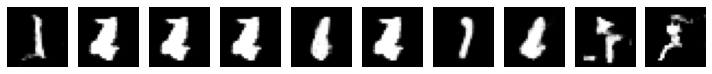

6300 [D loss: 0.227239, acc.: 87.50%] [G loss: 3.936871]
6301 [D loss: 0.075206, acc.: 96.88%] [G loss: 4.818314]
6302 [D loss: 0.036324, acc.: 99.22%] [G loss: 5.858855]
6303 [D loss: 0.106423, acc.: 96.88%] [G loss: 5.887951]
6304 [D loss: 0.034888, acc.: 99.22%] [G loss: 5.691401]
6305 [D loss: 0.138339, acc.: 95.31%] [G loss: 4.736218]
6306 [D loss: 0.182477, acc.: 92.97%] [G loss: 3.686787]
6307 [D loss: 0.127650, acc.: 95.31%] [G loss: 3.488722]
6308 [D loss: 0.076099, acc.: 96.88%] [G loss: 4.345464]
6309 [D loss: 0.054268, acc.: 98.44%] [G loss: 6.011539]
6310 [D loss: 0.068900, acc.: 97.66%] [G loss: 7.018782]
6311 [D loss: 0.075954, acc.: 97.66%] [G loss: 8.657358]
6312 [D loss: 0.148130, acc.: 95.31%] [G loss: 8.918623]
6313 [D loss: 0.146660, acc.: 96.09%] [G loss: 7.830219]
6314 [D loss: 0.142301, acc.: 95.31%] [G loss: 6.555747]
6315 [D loss: 0.094469, acc.: 96.09%] [G loss: 4.477769]
6316 [D loss: 0.106693, acc.: 95.31%] [G loss: 3.506792]
6317 [D loss: 0.110262, acc.: 9

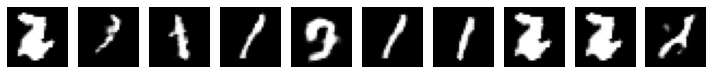

6400 [D loss: 0.056438, acc.: 97.66%] [G loss: 5.956983]
6401 [D loss: 0.079998, acc.: 96.09%] [G loss: 4.527249]
6402 [D loss: 0.080591, acc.: 95.31%] [G loss: 3.893400]
6403 [D loss: 0.096813, acc.: 96.09%] [G loss: 4.265413]
6404 [D loss: 0.105980, acc.: 96.09%] [G loss: 4.418640]
6405 [D loss: 0.096234, acc.: 95.31%] [G loss: 5.668137]
6406 [D loss: 0.056338, acc.: 96.88%] [G loss: 6.413540]
6407 [D loss: 0.067605, acc.: 96.88%] [G loss: 5.941449]
6408 [D loss: 0.069624, acc.: 96.88%] [G loss: 5.291046]
6409 [D loss: 0.076887, acc.: 96.88%] [G loss: 4.824087]
6410 [D loss: 0.104727, acc.: 95.31%] [G loss: 4.031485]
6411 [D loss: 0.095302, acc.: 97.66%] [G loss: 3.997402]
6412 [D loss: 0.086224, acc.: 97.66%] [G loss: 4.021532]
6413 [D loss: 0.109229, acc.: 93.75%] [G loss: 3.109290]
6414 [D loss: 0.078978, acc.: 96.88%] [G loss: 3.820255]
6415 [D loss: 0.062005, acc.: 96.88%] [G loss: 4.830437]
6416 [D loss: 0.044665, acc.: 98.44%] [G loss: 6.065190]
6417 [D loss: 0.045212, acc.: 9

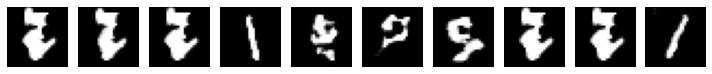

6500 [D loss: 0.060658, acc.: 97.66%] [G loss: 5.318926]
6501 [D loss: 0.037300, acc.: 98.44%] [G loss: 5.915815]
6502 [D loss: 0.053077, acc.: 97.66%] [G loss: 6.173725]
6503 [D loss: 0.043273, acc.: 98.44%] [G loss: 5.939028]
6504 [D loss: 0.018375, acc.: 99.22%] [G loss: 5.755087]
6505 [D loss: 0.065890, acc.: 95.31%] [G loss: 5.594717]
6506 [D loss: 0.056602, acc.: 97.66%] [G loss: 5.174699]
6507 [D loss: 0.055638, acc.: 97.66%] [G loss: 4.412096]
6508 [D loss: 0.158830, acc.: 92.97%] [G loss: 5.083566]
6509 [D loss: 0.027533, acc.: 99.22%] [G loss: 5.974384]
6510 [D loss: 0.081318, acc.: 96.88%] [G loss: 6.416788]
6511 [D loss: 0.113289, acc.: 95.31%] [G loss: 5.810928]
6512 [D loss: 0.031407, acc.: 99.22%] [G loss: 5.097195]
6513 [D loss: 0.064885, acc.: 97.66%] [G loss: 4.343265]
6514 [D loss: 0.079074, acc.: 97.66%] [G loss: 5.020440]
6515 [D loss: 0.124840, acc.: 94.53%] [G loss: 6.054526]
6516 [D loss: 0.048941, acc.: 97.66%] [G loss: 7.813578]
6517 [D loss: 0.056581, acc.: 9

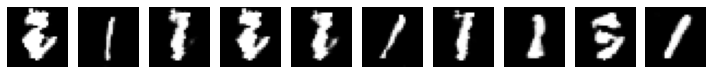

6600 [D loss: 0.102591, acc.: 96.09%] [G loss: 3.963353]
6601 [D loss: 0.123039, acc.: 94.53%] [G loss: 4.588859]
6602 [D loss: 0.051625, acc.: 98.44%] [G loss: 6.562879]
6603 [D loss: 0.105491, acc.: 96.09%] [G loss: 6.834252]
6604 [D loss: 0.139399, acc.: 92.97%] [G loss: 5.080103]
6605 [D loss: 0.129097, acc.: 94.53%] [G loss: 3.571750]
6606 [D loss: 0.124447, acc.: 94.53%] [G loss: 4.059465]
6607 [D loss: 0.054864, acc.: 97.66%] [G loss: 5.262476]
6608 [D loss: 0.090464, acc.: 96.88%] [G loss: 7.398155]
6609 [D loss: 0.027883, acc.: 98.44%] [G loss: 8.257082]
6610 [D loss: 0.088776, acc.: 96.88%] [G loss: 7.819762]
6611 [D loss: 0.092005, acc.: 96.09%] [G loss: 6.115123]
6612 [D loss: 0.071081, acc.: 96.09%] [G loss: 4.997116]
6613 [D loss: 0.118120, acc.: 93.75%] [G loss: 3.451607]
6614 [D loss: 0.070130, acc.: 96.88%] [G loss: 2.790541]
6615 [D loss: 0.120262, acc.: 96.09%] [G loss: 3.916264]
6616 [D loss: 0.015250, acc.: 99.22%] [G loss: 6.901010]
6617 [D loss: 0.027212, acc.: 9

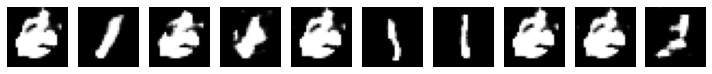

6700 [D loss: 0.160482, acc.: 93.75%] [G loss: 3.511475]
6701 [D loss: 0.082805, acc.: 97.66%] [G loss: 3.155960]
6702 [D loss: 0.091871, acc.: 94.53%] [G loss: 2.876242]
6703 [D loss: 0.145875, acc.: 92.97%] [G loss: 3.209412]
6704 [D loss: 0.028614, acc.: 98.44%] [G loss: 3.804553]
6705 [D loss: 0.142306, acc.: 95.31%] [G loss: 3.219440]
6706 [D loss: 0.072226, acc.: 96.88%] [G loss: 2.977464]
6707 [D loss: 0.069368, acc.: 96.09%] [G loss: 2.548650]
6708 [D loss: 0.075804, acc.: 96.88%] [G loss: 2.386348]
6709 [D loss: 0.094237, acc.: 96.09%] [G loss: 2.493092]
6710 [D loss: 0.122202, acc.: 94.53%] [G loss: 3.038335]
6711 [D loss: 0.034662, acc.: 98.44%] [G loss: 4.912183]
6712 [D loss: 0.012799, acc.: 99.22%] [G loss: 6.384971]
6713 [D loss: 0.155521, acc.: 93.75%] [G loss: 6.162683]
6714 [D loss: 0.201144, acc.: 96.09%] [G loss: 5.041462]
6715 [D loss: 0.083635, acc.: 96.09%] [G loss: 3.050925]
6716 [D loss: 0.099044, acc.: 95.31%] [G loss: 2.217932]
6717 [D loss: 0.105912, acc.: 9

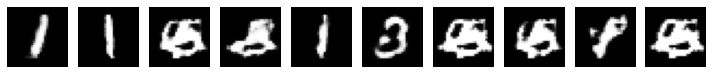

6800 [D loss: 0.045920, acc.: 98.44%] [G loss: 4.184891]
6801 [D loss: 0.037942, acc.: 99.22%] [G loss: 4.118372]
6802 [D loss: 0.066242, acc.: 96.88%] [G loss: 3.669858]
6803 [D loss: 0.116441, acc.: 96.09%] [G loss: 3.144597]
6804 [D loss: 0.085800, acc.: 96.09%] [G loss: 1.987873]
6805 [D loss: 0.082425, acc.: 97.66%] [G loss: 2.189178]
6806 [D loss: 0.069095, acc.: 97.66%] [G loss: 3.318823]
6807 [D loss: 0.079003, acc.: 95.31%] [G loss: 5.640373]
6808 [D loss: 0.080567, acc.: 96.09%] [G loss: 6.278049]
6809 [D loss: 0.068608, acc.: 97.66%] [G loss: 6.300531]
6810 [D loss: 0.153576, acc.: 93.75%] [G loss: 6.003574]
6811 [D loss: 0.111406, acc.: 96.09%] [G loss: 6.154574]
6812 [D loss: 0.050865, acc.: 97.66%] [G loss: 6.647555]
6813 [D loss: 0.090131, acc.: 96.09%] [G loss: 6.212126]
6814 [D loss: 0.171893, acc.: 94.53%] [G loss: 5.653958]
6815 [D loss: 0.047338, acc.: 98.44%] [G loss: 5.015708]
6816 [D loss: 0.079244, acc.: 96.88%] [G loss: 4.907908]
6817 [D loss: 0.056707, acc.: 9

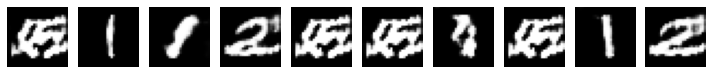

6900 [D loss: 0.100272, acc.: 96.88%] [G loss: 2.474167]
6901 [D loss: 0.077143, acc.: 98.44%] [G loss: 1.974132]
6902 [D loss: 0.116449, acc.: 95.31%] [G loss: 2.060200]
6903 [D loss: 0.081506, acc.: 96.88%] [G loss: 2.438714]
6904 [D loss: 0.090887, acc.: 95.31%] [G loss: 2.853249]
6905 [D loss: 0.054334, acc.: 96.88%] [G loss: 3.348226]
6906 [D loss: 0.081721, acc.: 96.88%] [G loss: 4.565289]
6907 [D loss: 0.063595, acc.: 97.66%] [G loss: 5.347668]
6908 [D loss: 0.104127, acc.: 94.53%] [G loss: 4.883367]
6909 [D loss: 0.071209, acc.: 96.09%] [G loss: 4.335894]
6910 [D loss: 0.076765, acc.: 97.66%] [G loss: 2.938424]
6911 [D loss: 0.071730, acc.: 99.22%] [G loss: 2.299964]
6912 [D loss: 0.071253, acc.: 98.44%] [G loss: 2.670435]
6913 [D loss: 0.059052, acc.: 96.88%] [G loss: 2.746320]
6914 [D loss: 0.104690, acc.: 95.31%] [G loss: 3.268380]
6915 [D loss: 0.065587, acc.: 97.66%] [G loss: 3.490052]
6916 [D loss: 0.086809, acc.: 96.88%] [G loss: 3.123859]
6917 [D loss: 0.036908, acc.: 9

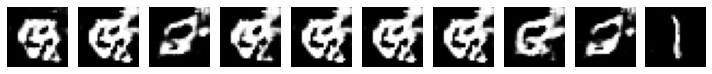

7000 [D loss: 0.117302, acc.: 92.97%] [G loss: 4.323445]
7001 [D loss: 0.024200, acc.: 99.22%] [G loss: 4.883090]
7002 [D loss: 0.038229, acc.: 98.44%] [G loss: 5.671535]
7003 [D loss: 0.108453, acc.: 95.31%] [G loss: 4.935421]
7004 [D loss: 0.047742, acc.: 99.22%] [G loss: 4.676464]
7005 [D loss: 0.059946, acc.: 97.66%] [G loss: 2.790816]
7006 [D loss: 0.042131, acc.: 98.44%] [G loss: 1.990236]
7007 [D loss: 0.032418, acc.: 99.22%] [G loss: 1.408759]
7008 [D loss: 0.024207, acc.: 99.22%] [G loss: 1.537378]
7009 [D loss: 0.043090, acc.: 97.66%] [G loss: 1.834547]
7010 [D loss: 0.020362, acc.: 99.22%] [G loss: 2.231360]
7011 [D loss: 0.019764, acc.: 99.22%] [G loss: 2.515832]
7012 [D loss: 0.077976, acc.: 96.88%] [G loss: 2.246931]
7013 [D loss: 0.045891, acc.: 99.22%] [G loss: 1.912170]
7014 [D loss: 0.048665, acc.: 97.66%] [G loss: 1.670573]
7015 [D loss: 0.044878, acc.: 98.44%] [G loss: 2.170966]
7016 [D loss: 0.041245, acc.: 97.66%] [G loss: 2.291191]
7017 [D loss: 0.049883, acc.: 9

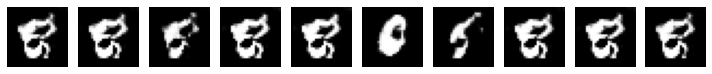

7100 [D loss: 0.080858, acc.: 96.88%] [G loss: 3.532379]
7101 [D loss: 0.076102, acc.: 98.44%] [G loss: 3.571431]
7102 [D loss: 0.034713, acc.: 98.44%] [G loss: 4.202300]
7103 [D loss: 0.035315, acc.: 99.22%] [G loss: 3.651012]
7104 [D loss: 0.086075, acc.: 96.88%] [G loss: 3.019535]
7105 [D loss: 0.047410, acc.: 98.44%] [G loss: 2.626873]
7106 [D loss: 0.072455, acc.: 96.88%] [G loss: 3.441980]
7107 [D loss: 0.077995, acc.: 97.66%] [G loss: 4.066057]
7108 [D loss: 0.111877, acc.: 96.09%] [G loss: 5.377432]
7109 [D loss: 0.068831, acc.: 97.66%] [G loss: 5.516969]
7110 [D loss: 0.036453, acc.: 98.44%] [G loss: 6.169453]
7111 [D loss: 0.078299, acc.: 95.31%] [G loss: 5.461663]
7112 [D loss: 0.049897, acc.: 97.66%] [G loss: 5.120518]
7113 [D loss: 0.089822, acc.: 96.88%] [G loss: 4.794724]
7114 [D loss: 0.123860, acc.: 94.53%] [G loss: 4.836677]
7115 [D loss: 0.036644, acc.: 98.44%] [G loss: 6.167504]
7116 [D loss: 0.062249, acc.: 96.09%] [G loss: 6.504387]
7117 [D loss: 0.073970, acc.: 9

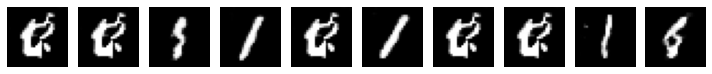

7200 [D loss: 0.077681, acc.: 98.44%] [G loss: 4.557131]
7201 [D loss: 0.089654, acc.: 96.88%] [G loss: 4.020961]
7202 [D loss: 0.120871, acc.: 94.53%] [G loss: 2.946406]
7203 [D loss: 0.046692, acc.: 99.22%] [G loss: 2.917758]
7204 [D loss: 0.059098, acc.: 97.66%] [G loss: 3.790403]
7205 [D loss: 0.059746, acc.: 97.66%] [G loss: 5.242918]
7206 [D loss: 0.055602, acc.: 97.66%] [G loss: 6.646522]
7207 [D loss: 0.106518, acc.: 95.31%] [G loss: 6.250944]
7208 [D loss: 0.035980, acc.: 99.22%] [G loss: 5.264918]
7209 [D loss: 0.070398, acc.: 96.88%] [G loss: 5.304787]
7210 [D loss: 0.101034, acc.: 96.09%] [G loss: 5.966562]
7211 [D loss: 0.017551, acc.: 99.22%] [G loss: 7.701627]
7212 [D loss: 0.144227, acc.: 94.53%] [G loss: 7.005199]
7213 [D loss: 0.070939, acc.: 97.66%] [G loss: 5.584326]
7214 [D loss: 0.101398, acc.: 93.75%] [G loss: 3.899944]
7215 [D loss: 0.099304, acc.: 96.88%] [G loss: 3.937167]
7216 [D loss: 0.038747, acc.: 99.22%] [G loss: 4.965082]
7217 [D loss: 0.012906, acc.: 1

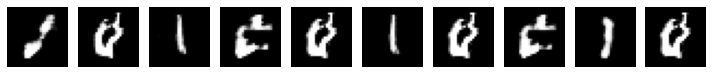

7300 [D loss: 0.113179, acc.: 96.09%] [G loss: 2.773056]
7301 [D loss: 0.068811, acc.: 96.88%] [G loss: 2.084148]
7302 [D loss: 0.118941, acc.: 94.53%] [G loss: 2.096258]
7303 [D loss: 0.035083, acc.: 99.22%] [G loss: 3.087465]
7304 [D loss: 0.041062, acc.: 98.44%] [G loss: 4.527788]
7305 [D loss: 0.027682, acc.: 98.44%] [G loss: 5.488912]
7306 [D loss: 0.055229, acc.: 96.88%] [G loss: 5.158638]
7307 [D loss: 0.074617, acc.: 96.09%] [G loss: 3.600591]
7308 [D loss: 0.068624, acc.: 97.66%] [G loss: 3.136981]
7309 [D loss: 0.067538, acc.: 98.44%] [G loss: 2.337168]
7310 [D loss: 0.074136, acc.: 98.44%] [G loss: 3.095227]
7311 [D loss: 0.042844, acc.: 98.44%] [G loss: 3.887886]
7312 [D loss: 0.071883, acc.: 96.09%] [G loss: 3.978308]
7313 [D loss: 0.045419, acc.: 97.66%] [G loss: 3.796447]
7314 [D loss: 0.088463, acc.: 96.88%] [G loss: 2.990253]
7315 [D loss: 0.036794, acc.: 98.44%] [G loss: 2.534590]
7316 [D loss: 0.132852, acc.: 96.88%] [G loss: 3.102840]
7317 [D loss: 0.049005, acc.: 9

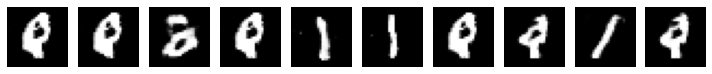

7400 [D loss: 0.095114, acc.: 96.09%] [G loss: 4.666879]
7401 [D loss: 0.022536, acc.: 100.00%] [G loss: 5.543845]
7402 [D loss: 0.058872, acc.: 97.66%] [G loss: 6.295525]
7403 [D loss: 0.010151, acc.: 100.00%] [G loss: 6.589941]
7404 [D loss: 0.093625, acc.: 97.66%] [G loss: 5.510664]
7405 [D loss: 0.135971, acc.: 95.31%] [G loss: 4.259888]
7406 [D loss: 0.084011, acc.: 97.66%] [G loss: 3.641176]
7407 [D loss: 0.113573, acc.: 95.31%] [G loss: 3.625654]
7408 [D loss: 0.083869, acc.: 94.53%] [G loss: 4.631089]
7409 [D loss: 0.027539, acc.: 99.22%] [G loss: 5.970881]
7410 [D loss: 0.100547, acc.: 96.88%] [G loss: 5.725024]
7411 [D loss: 0.043852, acc.: 98.44%] [G loss: 5.710375]
7412 [D loss: 0.023305, acc.: 100.00%] [G loss: 5.195383]
7413 [D loss: 0.043523, acc.: 99.22%] [G loss: 4.460949]
7414 [D loss: 0.068499, acc.: 97.66%] [G loss: 4.922039]
7415 [D loss: 0.115619, acc.: 95.31%] [G loss: 3.928864]
7416 [D loss: 0.069558, acc.: 96.88%] [G loss: 3.009712]
7417 [D loss: 0.169840, acc.

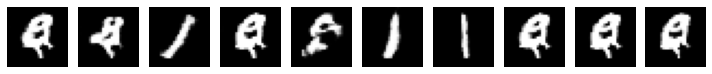

7500 [D loss: 0.155886, acc.: 94.53%] [G loss: 7.110432]
7501 [D loss: 0.053895, acc.: 98.44%] [G loss: 5.499565]
7502 [D loss: 0.060746, acc.: 97.66%] [G loss: 4.508609]
7503 [D loss: 0.040149, acc.: 100.00%] [G loss: 4.395375]
7504 [D loss: 0.036966, acc.: 98.44%] [G loss: 4.317734]
7505 [D loss: 0.023949, acc.: 99.22%] [G loss: 4.864196]
7506 [D loss: 0.025762, acc.: 99.22%] [G loss: 5.612874]
7507 [D loss: 0.056343, acc.: 97.66%] [G loss: 4.840958]
7508 [D loss: 0.056684, acc.: 97.66%] [G loss: 4.593510]
7509 [D loss: 0.043710, acc.: 97.66%] [G loss: 4.114199]
7510 [D loss: 0.063670, acc.: 97.66%] [G loss: 4.349474]
7511 [D loss: 0.085704, acc.: 94.53%] [G loss: 4.924113]
7512 [D loss: 0.053103, acc.: 98.44%] [G loss: 6.187685]
7513 [D loss: 0.038197, acc.: 99.22%] [G loss: 6.388509]
7514 [D loss: 0.040710, acc.: 97.66%] [G loss: 6.269281]
7515 [D loss: 0.167377, acc.: 94.53%] [G loss: 4.877593]
7516 [D loss: 0.027630, acc.: 99.22%] [G loss: 3.578454]
7517 [D loss: 0.063652, acc.: 

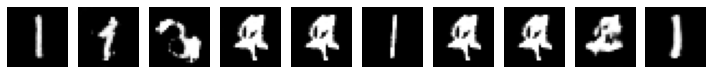

7600 [D loss: 0.124775, acc.: 95.31%] [G loss: 4.842212]
7601 [D loss: 0.050116, acc.: 98.44%] [G loss: 5.654497]
7602 [D loss: 0.108035, acc.: 96.09%] [G loss: 5.772608]
7603 [D loss: 0.048127, acc.: 97.66%] [G loss: 5.918299]
7604 [D loss: 0.041690, acc.: 98.44%] [G loss: 5.892638]
7605 [D loss: 0.057936, acc.: 98.44%] [G loss: 5.762565]
7606 [D loss: 0.080801, acc.: 94.53%] [G loss: 5.170284]
7607 [D loss: 0.021477, acc.: 100.00%] [G loss: 4.945666]
7608 [D loss: 0.059115, acc.: 99.22%] [G loss: 4.378675]
7609 [D loss: 0.083429, acc.: 97.66%] [G loss: 3.909420]
7610 [D loss: 0.090418, acc.: 97.66%] [G loss: 3.997133]
7611 [D loss: 0.053341, acc.: 98.44%] [G loss: 3.968637]
7612 [D loss: 0.054727, acc.: 97.66%] [G loss: 4.116902]
7613 [D loss: 0.067652, acc.: 95.31%] [G loss: 3.312447]
7614 [D loss: 0.066369, acc.: 97.66%] [G loss: 4.151052]
7615 [D loss: 0.071434, acc.: 96.09%] [G loss: 4.261008]
7616 [D loss: 0.078057, acc.: 98.44%] [G loss: 4.133512]
7617 [D loss: 0.168758, acc.: 

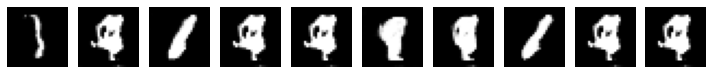

7700 [D loss: 0.057525, acc.: 97.66%] [G loss: 5.216046]
7701 [D loss: 0.041560, acc.: 97.66%] [G loss: 5.718587]
7702 [D loss: 0.050394, acc.: 98.44%] [G loss: 6.026762]
7703 [D loss: 0.070571, acc.: 96.88%] [G loss: 5.879525]
7704 [D loss: 0.013152, acc.: 100.00%] [G loss: 6.062288]
7705 [D loss: 0.044879, acc.: 99.22%] [G loss: 6.078976]
7706 [D loss: 0.080748, acc.: 96.88%] [G loss: 5.252748]
7707 [D loss: 0.083759, acc.: 96.09%] [G loss: 5.121455]
7708 [D loss: 0.027383, acc.: 100.00%] [G loss: 5.000037]
7709 [D loss: 0.049085, acc.: 97.66%] [G loss: 5.205781]
7710 [D loss: 0.043450, acc.: 98.44%] [G loss: 5.777348]
7711 [D loss: 0.067549, acc.: 98.44%] [G loss: 6.446157]
7712 [D loss: 0.136720, acc.: 96.09%] [G loss: 5.917970]
7713 [D loss: 0.044298, acc.: 97.66%] [G loss: 4.636983]
7714 [D loss: 0.119661, acc.: 96.88%] [G loss: 4.305847]
7715 [D loss: 0.086623, acc.: 96.09%] [G loss: 4.678566]
7716 [D loss: 0.124498, acc.: 96.09%] [G loss: 4.554760]
7717 [D loss: 0.079627, acc.:

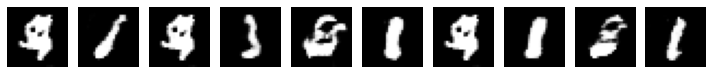

7800 [D loss: 0.114514, acc.: 95.31%] [G loss: 5.519069]
7801 [D loss: 0.044981, acc.: 97.66%] [G loss: 4.991219]
7802 [D loss: 0.060067, acc.: 97.66%] [G loss: 5.371699]
7803 [D loss: 0.096531, acc.: 93.75%] [G loss: 5.635136]
7804 [D loss: 0.054454, acc.: 97.66%] [G loss: 6.333751]
7805 [D loss: 0.102233, acc.: 96.09%] [G loss: 6.500861]
7806 [D loss: 0.120588, acc.: 96.09%] [G loss: 5.441622]
7807 [D loss: 0.048986, acc.: 96.88%] [G loss: 5.612940]
7808 [D loss: 0.091224, acc.: 92.19%] [G loss: 5.370954]
7809 [D loss: 0.063874, acc.: 98.44%] [G loss: 5.584511]
7810 [D loss: 0.091907, acc.: 96.09%] [G loss: 5.454612]
7811 [D loss: 0.027570, acc.: 99.22%] [G loss: 5.868061]
7812 [D loss: 0.092246, acc.: 95.31%] [G loss: 4.519794]
7813 [D loss: 0.049183, acc.: 98.44%] [G loss: 3.306214]
7814 [D loss: 0.053385, acc.: 98.44%] [G loss: 3.615385]
7815 [D loss: 0.053557, acc.: 98.44%] [G loss: 4.659040]
7816 [D loss: 0.064789, acc.: 97.66%] [G loss: 5.271658]
7817 [D loss: 0.150895, acc.: 9

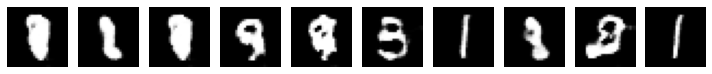

7900 [D loss: 0.085414, acc.: 95.31%] [G loss: 3.702828]
7901 [D loss: 0.040209, acc.: 98.44%] [G loss: 3.977038]
7902 [D loss: 0.037263, acc.: 97.66%] [G loss: 5.422723]
7903 [D loss: 0.015424, acc.: 100.00%] [G loss: 6.062261]
7904 [D loss: 0.087275, acc.: 96.09%] [G loss: 5.637495]
7905 [D loss: 0.059857, acc.: 98.44%] [G loss: 4.970304]
7906 [D loss: 0.072724, acc.: 97.66%] [G loss: 4.658618]
7907 [D loss: 0.097153, acc.: 96.09%] [G loss: 4.567395]
7908 [D loss: 0.083343, acc.: 96.88%] [G loss: 4.876948]
7909 [D loss: 0.070064, acc.: 95.31%] [G loss: 5.098361]
7910 [D loss: 0.092830, acc.: 96.88%] [G loss: 5.804353]
7911 [D loss: 0.083047, acc.: 96.88%] [G loss: 5.824996]
7912 [D loss: 0.110727, acc.: 93.75%] [G loss: 5.118928]
7913 [D loss: 0.054996, acc.: 97.66%] [G loss: 5.100430]
7914 [D loss: 0.078485, acc.: 96.09%] [G loss: 5.515906]
7915 [D loss: 0.067475, acc.: 97.66%] [G loss: 5.921497]
7916 [D loss: 0.081797, acc.: 97.66%] [G loss: 6.698608]
7917 [D loss: 0.077516, acc.: 

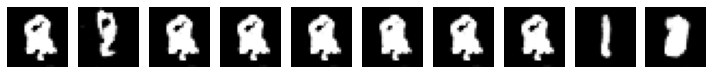

8000 [D loss: 0.044434, acc.: 97.66%] [G loss: 3.738653]
8001 [D loss: 0.058975, acc.: 96.88%] [G loss: 3.655847]
8002 [D loss: 0.018685, acc.: 100.00%] [G loss: 3.920241]
8003 [D loss: 0.139010, acc.: 94.53%] [G loss: 3.863257]
8004 [D loss: 0.043258, acc.: 98.44%] [G loss: 4.633600]
8005 [D loss: 0.045885, acc.: 99.22%] [G loss: 3.974050]
8006 [D loss: 0.056610, acc.: 97.66%] [G loss: 3.482230]
8007 [D loss: 0.036636, acc.: 99.22%] [G loss: 3.335420]
8008 [D loss: 0.078501, acc.: 97.66%] [G loss: 3.685815]
8009 [D loss: 0.040573, acc.: 99.22%] [G loss: 4.631522]
8010 [D loss: 0.066375, acc.: 97.66%] [G loss: 4.446514]
8011 [D loss: 0.085764, acc.: 96.88%] [G loss: 4.160101]
8012 [D loss: 0.070000, acc.: 96.09%] [G loss: 4.136354]
8013 [D loss: 0.069783, acc.: 96.88%] [G loss: 3.438570]
8014 [D loss: 0.027526, acc.: 99.22%] [G loss: 4.491126]
8015 [D loss: 0.089583, acc.: 96.88%] [G loss: 3.227102]
8016 [D loss: 0.063513, acc.: 97.66%] [G loss: 2.802093]
8017 [D loss: 0.108132, acc.: 

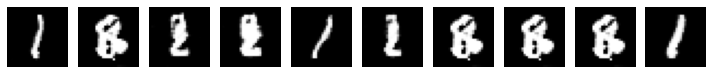

8100 [D loss: 0.093868, acc.: 94.53%] [G loss: 5.545043]
8101 [D loss: 0.074225, acc.: 97.66%] [G loss: 5.495003]
8102 [D loss: 0.039522, acc.: 98.44%] [G loss: 5.124611]
8103 [D loss: 0.071692, acc.: 97.66%] [G loss: 3.363324]
8104 [D loss: 0.099312, acc.: 97.66%] [G loss: 3.329204]
8105 [D loss: 0.052154, acc.: 97.66%] [G loss: 3.255869]
8106 [D loss: 0.026415, acc.: 99.22%] [G loss: 3.348973]
8107 [D loss: 0.103602, acc.: 95.31%] [G loss: 2.787720]
8108 [D loss: 0.015449, acc.: 100.00%] [G loss: 4.010425]
8109 [D loss: 0.034464, acc.: 98.44%] [G loss: 4.040360]
8110 [D loss: 0.034038, acc.: 98.44%] [G loss: 3.887502]
8111 [D loss: 0.029870, acc.: 99.22%] [G loss: 4.543397]
8112 [D loss: 0.036521, acc.: 98.44%] [G loss: 4.438967]
8113 [D loss: 0.105286, acc.: 96.09%] [G loss: 3.274050]
8114 [D loss: 0.088969, acc.: 96.88%] [G loss: 3.089823]
8115 [D loss: 0.047989, acc.: 97.66%] [G loss: 3.610931]
8116 [D loss: 0.052986, acc.: 97.66%] [G loss: 3.635412]
8117 [D loss: 0.099481, acc.: 

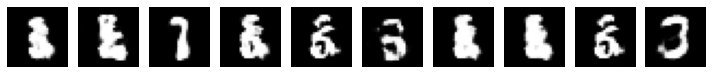

8200 [D loss: 0.035389, acc.: 99.22%] [G loss: 4.969778]
8201 [D loss: 0.069305, acc.: 96.88%] [G loss: 5.419595]
8202 [D loss: 0.047629, acc.: 97.66%] [G loss: 5.228055]
8203 [D loss: 0.089298, acc.: 97.66%] [G loss: 4.029561]
8204 [D loss: 0.068343, acc.: 97.66%] [G loss: 2.695607]
8205 [D loss: 0.060973, acc.: 97.66%] [G loss: 2.426265]
8206 [D loss: 0.151776, acc.: 94.53%] [G loss: 3.661952]
8207 [D loss: 0.134655, acc.: 94.53%] [G loss: 5.222713]
8208 [D loss: 0.027483, acc.: 99.22%] [G loss: 6.435815]
8209 [D loss: 0.163478, acc.: 93.75%] [G loss: 6.585984]
8210 [D loss: 0.079844, acc.: 96.88%] [G loss: 6.371112]
8211 [D loss: 0.039472, acc.: 98.44%] [G loss: 5.952394]
8212 [D loss: 0.147266, acc.: 92.97%] [G loss: 5.233997]
8213 [D loss: 0.089653, acc.: 93.75%] [G loss: 4.662851]
8214 [D loss: 0.068190, acc.: 96.88%] [G loss: 5.012605]
8215 [D loss: 0.055125, acc.: 99.22%] [G loss: 4.678767]
8216 [D loss: 0.151234, acc.: 94.53%] [G loss: 4.527679]
8217 [D loss: 0.080186, acc.: 9

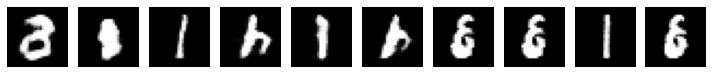

8300 [D loss: 0.032692, acc.: 99.22%] [G loss: 3.046946]
8301 [D loss: 0.147055, acc.: 94.53%] [G loss: 2.715827]
8302 [D loss: 0.056955, acc.: 99.22%] [G loss: 3.120221]
8303 [D loss: 0.032967, acc.: 99.22%] [G loss: 4.691485]
8304 [D loss: 0.057976, acc.: 97.66%] [G loss: 4.496109]
8305 [D loss: 0.054888, acc.: 97.66%] [G loss: 3.997577]
8306 [D loss: 0.053586, acc.: 97.66%] [G loss: 3.749693]
8307 [D loss: 0.122444, acc.: 96.09%] [G loss: 2.886029]
8308 [D loss: 0.062204, acc.: 97.66%] [G loss: 2.900767]
8309 [D loss: 0.057504, acc.: 99.22%] [G loss: 3.715744]
8310 [D loss: 0.056646, acc.: 96.88%] [G loss: 4.176124]
8311 [D loss: 0.112403, acc.: 96.09%] [G loss: 4.362584]
8312 [D loss: 0.067773, acc.: 97.66%] [G loss: 3.655082]
8313 [D loss: 0.068879, acc.: 98.44%] [G loss: 3.996917]
8314 [D loss: 0.036883, acc.: 99.22%] [G loss: 4.054638]
8315 [D loss: 0.103825, acc.: 94.53%] [G loss: 5.540319]
8316 [D loss: 0.045058, acc.: 98.44%] [G loss: 7.001114]
8317 [D loss: 0.095732, acc.: 9

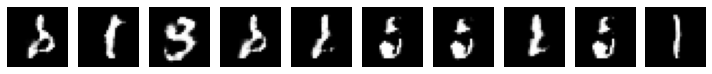

8400 [D loss: 0.062202, acc.: 98.44%] [G loss: 3.282748]
8401 [D loss: 0.091923, acc.: 96.88%] [G loss: 3.310597]
8402 [D loss: 0.112792, acc.: 95.31%] [G loss: 4.519689]
8403 [D loss: 0.083580, acc.: 97.66%] [G loss: 6.041312]
8404 [D loss: 0.141929, acc.: 92.97%] [G loss: 5.372128]
8405 [D loss: 0.034489, acc.: 98.44%] [G loss: 5.165359]
8406 [D loss: 0.052464, acc.: 97.66%] [G loss: 5.097117]
8407 [D loss: 0.112473, acc.: 96.88%] [G loss: 4.192615]
8408 [D loss: 0.067092, acc.: 97.66%] [G loss: 4.579672]
8409 [D loss: 0.047115, acc.: 98.44%] [G loss: 4.723121]
8410 [D loss: 0.078591, acc.: 98.44%] [G loss: 5.288425]
8411 [D loss: 0.036967, acc.: 98.44%] [G loss: 5.785219]
8412 [D loss: 0.024134, acc.: 99.22%] [G loss: 6.394403]
8413 [D loss: 0.029814, acc.: 98.44%] [G loss: 5.669792]
8414 [D loss: 0.123851, acc.: 96.09%] [G loss: 4.510923]
8415 [D loss: 0.063744, acc.: 96.88%] [G loss: 3.735885]
8416 [D loss: 0.041770, acc.: 98.44%] [G loss: 3.204722]
8417 [D loss: 0.083755, acc.: 9

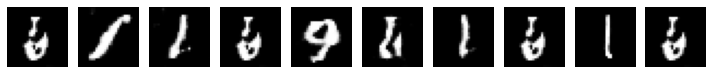

8500 [D loss: 0.074088, acc.: 94.53%] [G loss: 3.335016]
8501 [D loss: 0.032179, acc.: 100.00%] [G loss: 3.856722]
8502 [D loss: 0.049086, acc.: 98.44%] [G loss: 4.560630]
8503 [D loss: 0.063339, acc.: 97.66%] [G loss: 5.306121]
8504 [D loss: 0.069432, acc.: 97.66%] [G loss: 5.785882]
8505 [D loss: 0.040053, acc.: 100.00%] [G loss: 5.261834]
8506 [D loss: 0.051400, acc.: 97.66%] [G loss: 5.203952]
8507 [D loss: 0.088757, acc.: 95.31%] [G loss: 4.353991]
8508 [D loss: 0.051821, acc.: 97.66%] [G loss: 3.990455]
8509 [D loss: 0.090170, acc.: 96.88%] [G loss: 4.090236]
8510 [D loss: 0.051606, acc.: 97.66%] [G loss: 3.875328]
8511 [D loss: 0.073492, acc.: 96.88%] [G loss: 4.836942]
8512 [D loss: 0.076353, acc.: 96.09%] [G loss: 5.025242]
8513 [D loss: 0.082975, acc.: 96.88%] [G loss: 5.731920]
8514 [D loss: 0.065836, acc.: 99.22%] [G loss: 5.562335]
8515 [D loss: 0.057542, acc.: 98.44%] [G loss: 5.272340]
8516 [D loss: 0.074753, acc.: 96.09%] [G loss: 4.726320]
8517 [D loss: 0.053625, acc.:

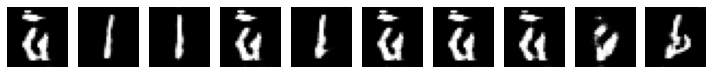

8600 [D loss: 0.015375, acc.: 100.00%] [G loss: 5.879039]
8601 [D loss: 0.037595, acc.: 99.22%] [G loss: 5.677483]
8602 [D loss: 0.127396, acc.: 96.09%] [G loss: 4.648965]
8603 [D loss: 0.066168, acc.: 97.66%] [G loss: 4.191728]
8604 [D loss: 0.103866, acc.: 93.75%] [G loss: 5.913486]
8605 [D loss: 0.025916, acc.: 99.22%] [G loss: 7.987491]
8606 [D loss: 0.079979, acc.: 95.31%] [G loss: 8.836678]
8607 [D loss: 0.085564, acc.: 96.88%] [G loss: 7.964859]
8608 [D loss: 0.034761, acc.: 99.22%] [G loss: 6.430307]
8609 [D loss: 0.099153, acc.: 98.44%] [G loss: 6.384864]
8610 [D loss: 0.059990, acc.: 96.88%] [G loss: 7.810029]
8611 [D loss: 0.058220, acc.: 98.44%] [G loss: 8.096682]
8612 [D loss: 0.109551, acc.: 95.31%] [G loss: 7.411244]
8613 [D loss: 0.063364, acc.: 98.44%] [G loss: 6.779757]
8614 [D loss: 0.040603, acc.: 99.22%] [G loss: 6.818859]
8615 [D loss: 0.054593, acc.: 97.66%] [G loss: 6.614106]
8616 [D loss: 0.029328, acc.: 99.22%] [G loss: 7.307628]
8617 [D loss: 0.065209, acc.: 

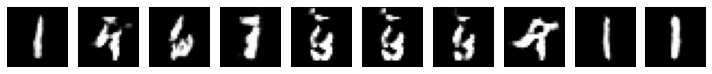

8700 [D loss: 0.069303, acc.: 97.66%] [G loss: 5.101239]
8701 [D loss: 0.163562, acc.: 92.97%] [G loss: 4.595286]
8702 [D loss: 0.092342, acc.: 96.88%] [G loss: 5.286574]
8703 [D loss: 0.127658, acc.: 96.09%] [G loss: 5.706798]
8704 [D loss: 0.092369, acc.: 96.88%] [G loss: 5.993393]
8705 [D loss: 0.099669, acc.: 96.88%] [G loss: 5.213653]
8706 [D loss: 0.066074, acc.: 96.88%] [G loss: 4.556958]
8707 [D loss: 0.059711, acc.: 97.66%] [G loss: 5.236412]
8708 [D loss: 0.053570, acc.: 98.44%] [G loss: 5.487385]
8709 [D loss: 0.106709, acc.: 96.09%] [G loss: 4.984004]
8710 [D loss: 0.038493, acc.: 98.44%] [G loss: 5.072415]
8711 [D loss: 0.081035, acc.: 96.88%] [G loss: 5.111948]
8712 [D loss: 0.054345, acc.: 97.66%] [G loss: 5.974744]
8713 [D loss: 0.048052, acc.: 98.44%] [G loss: 6.363533]
8714 [D loss: 0.123844, acc.: 96.09%] [G loss: 5.824884]
8715 [D loss: 0.054587, acc.: 98.44%] [G loss: 6.012875]
8716 [D loss: 0.041259, acc.: 98.44%] [G loss: 5.839942]
8717 [D loss: 0.063529, acc.: 9

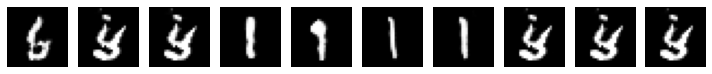

8800 [D loss: 0.047213, acc.: 99.22%] [G loss: 4.049063]
8801 [D loss: 0.045953, acc.: 98.44%] [G loss: 4.384951]
8802 [D loss: 0.055270, acc.: 96.09%] [G loss: 5.018793]
8803 [D loss: 0.093966, acc.: 97.66%] [G loss: 5.088999]
8804 [D loss: 0.084945, acc.: 98.44%] [G loss: 4.520353]
8805 [D loss: 0.076375, acc.: 97.66%] [G loss: 3.688693]
8806 [D loss: 0.140954, acc.: 96.09%] [G loss: 3.983403]
8807 [D loss: 0.073669, acc.: 96.88%] [G loss: 3.726181]
8808 [D loss: 0.069035, acc.: 96.88%] [G loss: 4.766055]
8809 [D loss: 0.077441, acc.: 96.09%] [G loss: 4.660688]
8810 [D loss: 0.025843, acc.: 100.00%] [G loss: 5.768826]
8811 [D loss: 0.023364, acc.: 99.22%] [G loss: 6.050300]
8812 [D loss: 0.112267, acc.: 95.31%] [G loss: 4.906806]
8813 [D loss: 0.043162, acc.: 97.66%] [G loss: 3.721074]
8814 [D loss: 0.075030, acc.: 96.88%] [G loss: 2.972878]
8815 [D loss: 0.131924, acc.: 96.09%] [G loss: 2.712126]
8816 [D loss: 0.077792, acc.: 96.88%] [G loss: 3.562972]
8817 [D loss: 0.047661, acc.: 

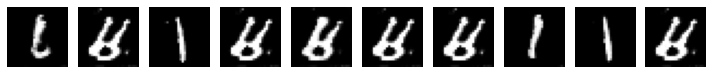

8900 [D loss: 0.137499, acc.: 96.09%] [G loss: 1.720176]
8901 [D loss: 0.093323, acc.: 96.88%] [G loss: 1.584518]
8902 [D loss: 0.068321, acc.: 97.66%] [G loss: 1.675226]
8903 [D loss: 0.037274, acc.: 99.22%] [G loss: 1.790884]
8904 [D loss: 0.072852, acc.: 96.09%] [G loss: 1.676214]
8905 [D loss: 0.068392, acc.: 97.66%] [G loss: 2.132904]
8906 [D loss: 0.072461, acc.: 96.09%] [G loss: 1.692832]
8907 [D loss: 0.019845, acc.: 100.00%] [G loss: 1.708344]
8908 [D loss: 0.105270, acc.: 97.66%] [G loss: 1.730250]
8909 [D loss: 0.039301, acc.: 98.44%] [G loss: 2.061824]
8910 [D loss: 0.099061, acc.: 95.31%] [G loss: 1.470328]
8911 [D loss: 0.042355, acc.: 99.22%] [G loss: 1.360576]
8912 [D loss: 0.061674, acc.: 98.44%] [G loss: 1.130064]
8913 [D loss: 0.074099, acc.: 97.66%] [G loss: 0.996978]
8914 [D loss: 0.094069, acc.: 97.66%] [G loss: 1.323011]
8915 [D loss: 0.147126, acc.: 94.53%] [G loss: 1.210672]
8916 [D loss: 0.095101, acc.: 96.88%] [G loss: 1.133083]
8917 [D loss: 0.090030, acc.: 

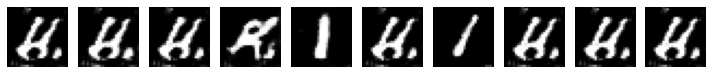

9000 [D loss: 0.051388, acc.: 97.66%] [G loss: 1.793574]
9001 [D loss: 0.040705, acc.: 97.66%] [G loss: 2.146888]
9002 [D loss: 0.019074, acc.: 99.22%] [G loss: 1.996085]
9003 [D loss: 0.089050, acc.: 95.31%] [G loss: 1.822926]
9004 [D loss: 0.093813, acc.: 96.88%] [G loss: 2.416554]
9005 [D loss: 0.082547, acc.: 96.88%] [G loss: 2.853867]
9006 [D loss: 0.023877, acc.: 98.44%] [G loss: 5.546219]
9007 [D loss: 0.080160, acc.: 96.09%] [G loss: 4.451836]
9008 [D loss: 0.075504, acc.: 96.09%] [G loss: 3.680046]
9009 [D loss: 0.033702, acc.: 99.22%] [G loss: 3.469660]
9010 [D loss: 0.069439, acc.: 96.88%] [G loss: 2.661579]
9011 [D loss: 0.086606, acc.: 96.09%] [G loss: 2.437238]
9012 [D loss: 0.041566, acc.: 97.66%] [G loss: 3.180707]
9013 [D loss: 0.049916, acc.: 98.44%] [G loss: 3.685459]
9014 [D loss: 0.035152, acc.: 97.66%] [G loss: 4.514091]
9015 [D loss: 0.022662, acc.: 99.22%] [G loss: 5.160111]
9016 [D loss: 0.043153, acc.: 97.66%] [G loss: 4.823762]
9017 [D loss: 0.032252, acc.: 9

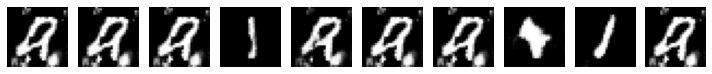

9100 [D loss: 0.056172, acc.: 96.09%] [G loss: 4.883448]
9101 [D loss: 0.068197, acc.: 98.44%] [G loss: 5.857259]
9102 [D loss: 0.049201, acc.: 97.66%] [G loss: 5.034429]
9103 [D loss: 0.154846, acc.: 94.53%] [G loss: 4.292061]
9104 [D loss: 0.015640, acc.: 100.00%] [G loss: 4.092708]
9105 [D loss: 0.101924, acc.: 97.66%] [G loss: 4.850426]
9106 [D loss: 0.087512, acc.: 96.88%] [G loss: 4.367972]
9107 [D loss: 0.083897, acc.: 96.88%] [G loss: 6.069635]
9108 [D loss: 0.089097, acc.: 96.88%] [G loss: 6.021682]
9109 [D loss: 0.096419, acc.: 95.31%] [G loss: 5.590942]
9110 [D loss: 0.136938, acc.: 95.31%] [G loss: 5.013258]
9111 [D loss: 0.074304, acc.: 96.88%] [G loss: 5.128478]
9112 [D loss: 0.065114, acc.: 98.44%] [G loss: 6.262482]
9113 [D loss: 0.103359, acc.: 96.88%] [G loss: 5.088759]
9114 [D loss: 0.066131, acc.: 97.66%] [G loss: 4.569226]
9115 [D loss: 0.098242, acc.: 96.88%] [G loss: 3.540027]
9116 [D loss: 0.112310, acc.: 96.88%] [G loss: 2.819672]
9117 [D loss: 0.116190, acc.: 

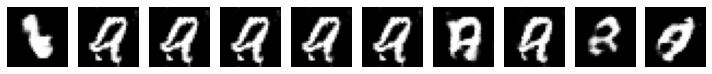

9200 [D loss: 0.059800, acc.: 97.66%] [G loss: 5.339091]
9201 [D loss: 0.033756, acc.: 98.44%] [G loss: 6.411634]
9202 [D loss: 0.044622, acc.: 98.44%] [G loss: 7.687527]
9203 [D loss: 0.069013, acc.: 97.66%] [G loss: 6.494804]
9204 [D loss: 0.063920, acc.: 99.22%] [G loss: 5.761672]
9205 [D loss: 0.044100, acc.: 98.44%] [G loss: 4.057662]
9206 [D loss: 0.075018, acc.: 95.31%] [G loss: 4.012088]
9207 [D loss: 0.096216, acc.: 96.09%] [G loss: 5.630785]
9208 [D loss: 0.087250, acc.: 96.88%] [G loss: 6.843347]
9209 [D loss: 0.148516, acc.: 94.53%] [G loss: 6.543765]
9210 [D loss: 0.034290, acc.: 98.44%] [G loss: 5.864867]
9211 [D loss: 0.053434, acc.: 98.44%] [G loss: 5.061985]
9212 [D loss: 0.036536, acc.: 99.22%] [G loss: 4.938167]
9213 [D loss: 0.066730, acc.: 96.88%] [G loss: 5.092362]
9214 [D loss: 0.042614, acc.: 99.22%] [G loss: 5.090405]
9215 [D loss: 0.093707, acc.: 95.31%] [G loss: 6.710613]
9216 [D loss: 0.088623, acc.: 95.31%] [G loss: 6.561646]
9217 [D loss: 0.035719, acc.: 9

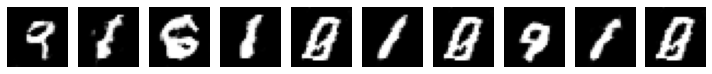

9300 [D loss: 0.069907, acc.: 98.44%] [G loss: 4.412992]
9301 [D loss: 0.131618, acc.: 95.31%] [G loss: 5.100182]
9302 [D loss: 0.041518, acc.: 99.22%] [G loss: 5.405044]
9303 [D loss: 0.046746, acc.: 97.66%] [G loss: 5.500192]
9304 [D loss: 0.093773, acc.: 96.09%] [G loss: 3.611627]
9305 [D loss: 0.071349, acc.: 96.88%] [G loss: 2.320881]
9306 [D loss: 0.114696, acc.: 96.09%] [G loss: 3.491332]
9307 [D loss: 0.056247, acc.: 98.44%] [G loss: 5.627365]
9308 [D loss: 0.073459, acc.: 96.88%] [G loss: 7.014660]
9309 [D loss: 0.054998, acc.: 96.88%] [G loss: 8.003930]
9310 [D loss: 0.125188, acc.: 94.53%] [G loss: 9.476169]
9311 [D loss: 0.026864, acc.: 100.00%] [G loss: 11.037543]
9312 [D loss: 0.084713, acc.: 96.09%] [G loss: 9.968124]
9313 [D loss: 0.068785, acc.: 96.88%] [G loss: 8.653841]
9314 [D loss: 0.119809, acc.: 94.53%] [G loss: 6.933922]
9315 [D loss: 0.110171, acc.: 94.53%] [G loss: 5.540322]
9316 [D loss: 0.079493, acc.: 97.66%] [G loss: 5.162840]
9317 [D loss: 0.057964, acc.:

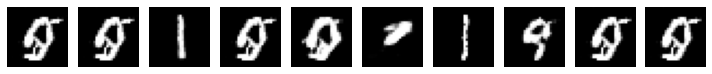

9400 [D loss: 0.079900, acc.: 96.88%] [G loss: 4.552690]
9401 [D loss: 0.051262, acc.: 97.66%] [G loss: 4.740444]
9402 [D loss: 0.085542, acc.: 95.31%] [G loss: 4.701643]
9403 [D loss: 0.121437, acc.: 96.09%] [G loss: 3.401014]
9404 [D loss: 0.172211, acc.: 94.53%] [G loss: 1.700203]
9405 [D loss: 0.202316, acc.: 92.19%] [G loss: 2.103005]
9406 [D loss: 0.034207, acc.: 99.22%] [G loss: 4.238810]
9407 [D loss: 0.042541, acc.: 97.66%] [G loss: 5.222955]
9408 [D loss: 0.055365, acc.: 97.66%] [G loss: 5.274385]
9409 [D loss: 0.068739, acc.: 97.66%] [G loss: 4.027974]
9410 [D loss: 0.092165, acc.: 97.66%] [G loss: 2.813253]
9411 [D loss: 0.048728, acc.: 97.66%] [G loss: 2.479809]
9412 [D loss: 0.090061, acc.: 97.66%] [G loss: 2.600088]
9413 [D loss: 0.070304, acc.: 97.66%] [G loss: 3.233069]
9414 [D loss: 0.023614, acc.: 99.22%] [G loss: 4.637875]
9415 [D loss: 0.137735, acc.: 93.75%] [G loss: 4.156582]
9416 [D loss: 0.062713, acc.: 96.88%] [G loss: 4.150147]
9417 [D loss: 0.102600, acc.: 9

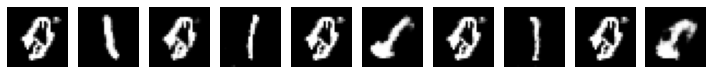

9500 [D loss: 0.076380, acc.: 96.88%] [G loss: 5.020947]
9501 [D loss: 0.085982, acc.: 94.53%] [G loss: 4.408147]
9502 [D loss: 0.039076, acc.: 98.44%] [G loss: 3.921919]
9503 [D loss: 0.051303, acc.: 97.66%] [G loss: 4.071991]
9504 [D loss: 0.033295, acc.: 99.22%] [G loss: 4.683629]
9505 [D loss: 0.095822, acc.: 96.88%] [G loss: 5.961980]
9506 [D loss: 0.096491, acc.: 97.66%] [G loss: 5.395622]
9507 [D loss: 0.023359, acc.: 99.22%] [G loss: 5.518575]
9508 [D loss: 0.083258, acc.: 96.09%] [G loss: 5.822255]
9509 [D loss: 0.037232, acc.: 99.22%] [G loss: 6.740690]
9510 [D loss: 0.093314, acc.: 97.66%] [G loss: 7.478078]
9511 [D loss: 0.058166, acc.: 97.66%] [G loss: 6.556481]
9512 [D loss: 0.068246, acc.: 96.88%] [G loss: 6.048402]
9513 [D loss: 0.050679, acc.: 99.22%] [G loss: 5.124910]
9514 [D loss: 0.050690, acc.: 98.44%] [G loss: 5.137288]
9515 [D loss: 0.032038, acc.: 99.22%] [G loss: 5.446454]
9516 [D loss: 0.053177, acc.: 96.88%] [G loss: 5.884447]
9517 [D loss: 0.024822, acc.: 9

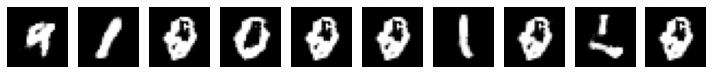

9600 [D loss: 0.053521, acc.: 98.44%] [G loss: 5.655377]
9601 [D loss: 0.120743, acc.: 95.31%] [G loss: 5.148576]
9602 [D loss: 0.050637, acc.: 97.66%] [G loss: 3.975470]
9603 [D loss: 0.058334, acc.: 98.44%] [G loss: 3.720920]
9604 [D loss: 0.054289, acc.: 97.66%] [G loss: 3.987929]
9605 [D loss: 0.063050, acc.: 97.66%] [G loss: 3.699331]
9606 [D loss: 0.130646, acc.: 93.75%] [G loss: 4.771139]
9607 [D loss: 0.053011, acc.: 97.66%] [G loss: 4.696033]
9608 [D loss: 0.107817, acc.: 96.09%] [G loss: 5.140316]
9609 [D loss: 0.102860, acc.: 96.09%] [G loss: 4.631060]
9610 [D loss: 0.048776, acc.: 97.66%] [G loss: 5.178185]
9611 [D loss: 0.024705, acc.: 100.00%] [G loss: 5.621839]
9612 [D loss: 0.075421, acc.: 97.66%] [G loss: 5.091331]
9613 [D loss: 0.129914, acc.: 94.53%] [G loss: 5.173081]
9614 [D loss: 0.092206, acc.: 96.09%] [G loss: 5.659555]
9615 [D loss: 0.072852, acc.: 97.66%] [G loss: 5.242811]
9616 [D loss: 0.116891, acc.: 95.31%] [G loss: 4.638179]
9617 [D loss: 0.023278, acc.: 

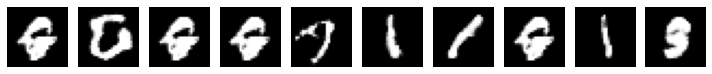

9700 [D loss: 0.033586, acc.: 99.22%] [G loss: 5.322659]
9701 [D loss: 0.101643, acc.: 95.31%] [G loss: 4.714008]
9702 [D loss: 0.032146, acc.: 98.44%] [G loss: 5.418447]
9703 [D loss: 0.013236, acc.: 100.00%] [G loss: 5.900824]
9704 [D loss: 0.121749, acc.: 94.53%] [G loss: 6.288385]
9705 [D loss: 0.058656, acc.: 96.88%] [G loss: 4.869646]
9706 [D loss: 0.040137, acc.: 99.22%] [G loss: 3.974418]
9707 [D loss: 0.091192, acc.: 96.88%] [G loss: 3.653677]
9708 [D loss: 0.029899, acc.: 100.00%] [G loss: 4.665677]
9709 [D loss: 0.065177, acc.: 98.44%] [G loss: 4.869831]
9710 [D loss: 0.088532, acc.: 96.88%] [G loss: 5.456378]
9711 [D loss: 0.095054, acc.: 96.09%] [G loss: 5.294733]
9712 [D loss: 0.092404, acc.: 96.88%] [G loss: 6.077715]
9713 [D loss: 0.079706, acc.: 96.09%] [G loss: 6.450373]
9714 [D loss: 0.068150, acc.: 96.88%] [G loss: 5.198460]
9715 [D loss: 0.050386, acc.: 99.22%] [G loss: 4.839203]
9716 [D loss: 0.174567, acc.: 93.75%] [G loss: 3.055010]
9717 [D loss: 0.125906, acc.:

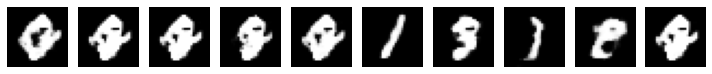

9800 [D loss: 0.036147, acc.: 96.88%] [G loss: 6.810047]
9801 [D loss: 0.053036, acc.: 99.22%] [G loss: 7.052538]
9802 [D loss: 0.047202, acc.: 98.44%] [G loss: 6.698509]
9803 [D loss: 0.037965, acc.: 99.22%] [G loss: 6.282592]
9804 [D loss: 0.073610, acc.: 96.09%] [G loss: 5.293751]
9805 [D loss: 0.088518, acc.: 96.88%] [G loss: 5.310886]
9806 [D loss: 0.015253, acc.: 99.22%] [G loss: 5.366278]
9807 [D loss: 0.220642, acc.: 93.75%] [G loss: 4.247834]
9808 [D loss: 0.122071, acc.: 96.09%] [G loss: 3.587938]
9809 [D loss: 0.085351, acc.: 97.66%] [G loss: 2.859046]
9810 [D loss: 0.043362, acc.: 97.66%] [G loss: 2.790615]
9811 [D loss: 0.023341, acc.: 100.00%] [G loss: 4.014665]
9812 [D loss: 0.089868, acc.: 96.09%] [G loss: 4.608183]
9813 [D loss: 0.061329, acc.: 98.44%] [G loss: 5.905750]
9814 [D loss: 0.083270, acc.: 96.88%] [G loss: 5.515283]
9815 [D loss: 0.037643, acc.: 98.44%] [G loss: 5.857988]
9816 [D loss: 0.064438, acc.: 98.44%] [G loss: 3.995318]
9817 [D loss: 0.054981, acc.: 

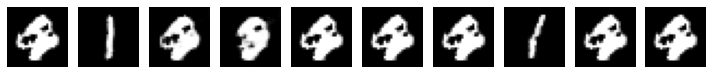

9900 [D loss: 0.026155, acc.: 99.22%] [G loss: 7.030581]
9901 [D loss: 0.029214, acc.: 99.22%] [G loss: 6.976857]
9902 [D loss: 0.062678, acc.: 97.66%] [G loss: 6.548807]
9903 [D loss: 0.103486, acc.: 98.44%] [G loss: 5.654981]
9904 [D loss: 0.075496, acc.: 96.88%] [G loss: 4.173901]
9905 [D loss: 0.086838, acc.: 96.09%] [G loss: 2.786536]
9906 [D loss: 0.093521, acc.: 97.66%] [G loss: 4.217242]
9907 [D loss: 0.061175, acc.: 96.88%] [G loss: 6.594644]
9908 [D loss: 0.045075, acc.: 97.66%] [G loss: 9.094240]
9909 [D loss: 0.065865, acc.: 97.66%] [G loss: 9.833817]
9910 [D loss: 0.155022, acc.: 93.75%] [G loss: 7.890811]
9911 [D loss: 0.046976, acc.: 98.44%] [G loss: 7.615435]
9912 [D loss: 0.044379, acc.: 98.44%] [G loss: 7.185691]
9913 [D loss: 0.075762, acc.: 96.88%] [G loss: 7.770747]
9914 [D loss: 0.051006, acc.: 98.44%] [G loss: 8.406431]
9915 [D loss: 0.024212, acc.: 99.22%] [G loss: 9.861017]
9916 [D loss: 0.080736, acc.: 96.88%] [G loss: 10.402240]
9917 [D loss: 0.094395, acc.: 

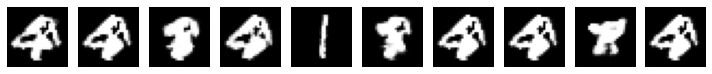

10000 [D loss: 0.117135, acc.: 95.31%] [G loss: 2.914246]
10001 [D loss: 0.170381, acc.: 94.53%] [G loss: 4.662720]
10002 [D loss: 0.106880, acc.: 95.31%] [G loss: 4.792562]
10003 [D loss: 0.089529, acc.: 96.09%] [G loss: 2.939452]
10004 [D loss: 0.128428, acc.: 93.75%] [G loss: 3.014691]
10005 [D loss: 0.115930, acc.: 95.31%] [G loss: 4.356034]
10006 [D loss: 0.077762, acc.: 96.88%] [G loss: 5.101208]
10007 [D loss: 0.061626, acc.: 99.22%] [G loss: 4.502168]
10008 [D loss: 0.076316, acc.: 96.88%] [G loss: 3.584474]
10009 [D loss: 0.076680, acc.: 97.66%] [G loss: 3.578164]
10010 [D loss: 0.088614, acc.: 97.66%] [G loss: 3.389119]
10011 [D loss: 0.065154, acc.: 95.31%] [G loss: 2.047970]
10012 [D loss: 0.039432, acc.: 98.44%] [G loss: 1.913321]
10013 [D loss: 0.063577, acc.: 96.88%] [G loss: 1.668765]
10014 [D loss: 0.044837, acc.: 98.44%] [G loss: 2.750617]
10015 [D loss: 0.183779, acc.: 89.84%] [G loss: 3.548733]
10016 [D loss: 0.035961, acc.: 99.22%] [G loss: 5.000570]
10017 [D loss:

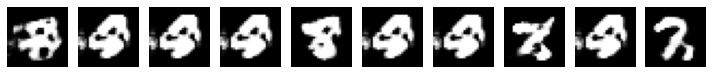

10100 [D loss: 0.066449, acc.: 97.66%] [G loss: 5.600314]
10101 [D loss: 0.031250, acc.: 99.22%] [G loss: 5.734938]
10102 [D loss: 0.044884, acc.: 97.66%] [G loss: 5.654148]
10103 [D loss: 0.016366, acc.: 99.22%] [G loss: 5.754994]
10104 [D loss: 0.051946, acc.: 98.44%] [G loss: 5.401052]
10105 [D loss: 0.128558, acc.: 96.88%] [G loss: 4.887210]
10106 [D loss: 0.037850, acc.: 97.66%] [G loss: 3.910980]
10107 [D loss: 0.064270, acc.: 96.88%] [G loss: 3.764890]
10108 [D loss: 0.060545, acc.: 97.66%] [G loss: 3.578870]
10109 [D loss: 0.124302, acc.: 95.31%] [G loss: 4.454063]
10110 [D loss: 0.047697, acc.: 98.44%] [G loss: 6.177874]
10111 [D loss: 0.037069, acc.: 98.44%] [G loss: 6.619419]
10112 [D loss: 0.064283, acc.: 97.66%] [G loss: 7.606761]
10113 [D loss: 0.076769, acc.: 96.88%] [G loss: 7.247325]
10114 [D loss: 0.067275, acc.: 96.88%] [G loss: 7.317079]
10115 [D loss: 0.062725, acc.: 97.66%] [G loss: 7.379386]
10116 [D loss: 0.077889, acc.: 96.09%] [G loss: 8.410182]
10117 [D loss:

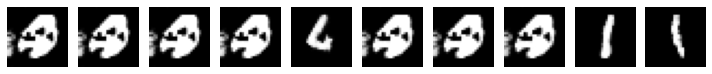

10200 [D loss: 0.059699, acc.: 96.88%] [G loss: 7.249352]
10201 [D loss: 0.036552, acc.: 99.22%] [G loss: 6.971386]
10202 [D loss: 0.065205, acc.: 98.44%] [G loss: 6.393845]
10203 [D loss: 0.027355, acc.: 98.44%] [G loss: 5.670735]
10204 [D loss: 0.015210, acc.: 99.22%] [G loss: 6.206335]
10205 [D loss: 0.035907, acc.: 98.44%] [G loss: 5.137499]
10206 [D loss: 0.097212, acc.: 97.66%] [G loss: 4.823703]
10207 [D loss: 0.047601, acc.: 97.66%] [G loss: 4.585153]
10208 [D loss: 0.032915, acc.: 99.22%] [G loss: 5.564284]
10209 [D loss: 0.071894, acc.: 97.66%] [G loss: 6.804104]
10210 [D loss: 0.002354, acc.: 100.00%] [G loss: 7.566313]
10211 [D loss: 0.051072, acc.: 97.66%] [G loss: 8.637339]
10212 [D loss: 0.043448, acc.: 98.44%] [G loss: 8.789380]
10213 [D loss: 0.155868, acc.: 94.53%] [G loss: 7.971041]
10214 [D loss: 0.098531, acc.: 95.31%] [G loss: 7.212734]
10215 [D loss: 0.052654, acc.: 97.66%] [G loss: 7.922842]
10216 [D loss: 0.031832, acc.: 97.66%] [G loss: 8.259033]
10217 [D loss

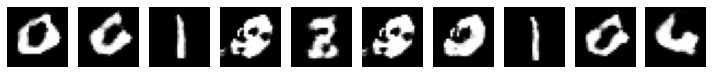

10300 [D loss: 0.116999, acc.: 94.53%] [G loss: 5.047878]
10301 [D loss: 0.126143, acc.: 95.31%] [G loss: 6.492641]
10302 [D loss: 0.043656, acc.: 97.66%] [G loss: 7.482040]
10303 [D loss: 0.079287, acc.: 97.66%] [G loss: 7.476022]
10304 [D loss: 0.072541, acc.: 96.09%] [G loss: 6.679688]
10305 [D loss: 0.085934, acc.: 96.09%] [G loss: 4.578146]
10306 [D loss: 0.105883, acc.: 94.53%] [G loss: 3.136573]
10307 [D loss: 0.100771, acc.: 97.66%] [G loss: 4.368680]
10308 [D loss: 0.023542, acc.: 99.22%] [G loss: 5.772111]
10309 [D loss: 0.073774, acc.: 96.09%] [G loss: 7.131699]
10310 [D loss: 0.057991, acc.: 97.66%] [G loss: 8.493662]
10311 [D loss: 0.037232, acc.: 99.22%] [G loss: 8.817665]
10312 [D loss: 0.046405, acc.: 99.22%] [G loss: 8.848795]
10313 [D loss: 0.064681, acc.: 98.44%] [G loss: 7.953529]
10314 [D loss: 0.041538, acc.: 98.44%] [G loss: 7.524397]
10315 [D loss: 0.051696, acc.: 97.66%] [G loss: 6.780974]
10316 [D loss: 0.071671, acc.: 97.66%] [G loss: 7.044082]
10317 [D loss:

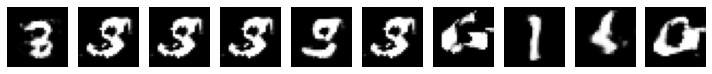

10400 [D loss: 0.036580, acc.: 99.22%] [G loss: 2.302279]
10401 [D loss: 0.083978, acc.: 98.44%] [G loss: 2.707679]
10402 [D loss: 0.079425, acc.: 96.88%] [G loss: 2.469913]
10403 [D loss: 0.051651, acc.: 98.44%] [G loss: 2.511403]
10404 [D loss: 0.015168, acc.: 100.00%] [G loss: 2.590189]
10405 [D loss: 0.045607, acc.: 98.44%] [G loss: 2.107440]
10406 [D loss: 0.022839, acc.: 100.00%] [G loss: 2.209711]
10407 [D loss: 0.027260, acc.: 100.00%] [G loss: 2.634184]
10408 [D loss: 0.046629, acc.: 97.66%] [G loss: 2.781145]
10409 [D loss: 0.056815, acc.: 96.88%] [G loss: 3.115562]
10410 [D loss: 0.027265, acc.: 99.22%] [G loss: 3.763487]
10411 [D loss: 0.018339, acc.: 100.00%] [G loss: 3.232495]
10412 [D loss: 0.066731, acc.: 96.88%] [G loss: 3.479074]
10413 [D loss: 0.112952, acc.: 97.66%] [G loss: 2.913517]
10414 [D loss: 0.124335, acc.: 93.75%] [G loss: 2.570792]
10415 [D loss: 0.021184, acc.: 99.22%] [G loss: 2.151897]
10416 [D loss: 0.090723, acc.: 96.09%] [G loss: 1.518133]
10417 [D l

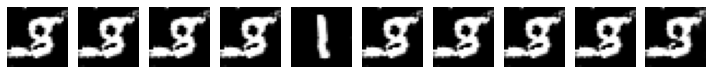

10500 [D loss: 0.054246, acc.: 97.66%] [G loss: 7.365185]
10501 [D loss: 0.022854, acc.: 98.44%] [G loss: 7.813040]
10502 [D loss: 0.025766, acc.: 99.22%] [G loss: 7.474335]
10503 [D loss: 0.048893, acc.: 97.66%] [G loss: 6.827904]
10504 [D loss: 0.105563, acc.: 96.88%] [G loss: 5.654881]
10505 [D loss: 0.106423, acc.: 96.09%] [G loss: 5.062611]
10506 [D loss: 0.118276, acc.: 96.09%] [G loss: 5.448530]
10507 [D loss: 0.059599, acc.: 99.22%] [G loss: 5.463441]
10508 [D loss: 0.075845, acc.: 97.66%] [G loss: 4.676759]
10509 [D loss: 0.025314, acc.: 100.00%] [G loss: 4.320568]
10510 [D loss: 0.107804, acc.: 96.09%] [G loss: 3.364586]
10511 [D loss: 0.146977, acc.: 94.53%] [G loss: 2.944841]
10512 [D loss: 0.071611, acc.: 97.66%] [G loss: 4.574476]
10513 [D loss: 0.051041, acc.: 97.66%] [G loss: 7.735130]
10514 [D loss: 0.076080, acc.: 96.09%] [G loss: 7.770002]
10515 [D loss: 0.072926, acc.: 98.44%] [G loss: 7.792746]
10516 [D loss: 0.111003, acc.: 95.31%] [G loss: 6.976554]
10517 [D loss

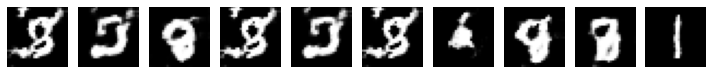

10600 [D loss: 0.069361, acc.: 96.88%] [G loss: 1.931547]
10601 [D loss: 0.074528, acc.: 96.88%] [G loss: 1.625065]
10602 [D loss: 0.048619, acc.: 96.88%] [G loss: 1.529928]
10603 [D loss: 0.096897, acc.: 96.09%] [G loss: 1.590207]
10604 [D loss: 0.012791, acc.: 100.00%] [G loss: 2.014472]
10605 [D loss: 0.069865, acc.: 97.66%] [G loss: 2.528293]
10606 [D loss: 0.052315, acc.: 98.44%] [G loss: 2.760945]
10607 [D loss: 0.095172, acc.: 96.88%] [G loss: 2.102876]
10608 [D loss: 0.083259, acc.: 96.88%] [G loss: 1.759576]
10609 [D loss: 0.085809, acc.: 96.88%] [G loss: 1.680237]
10610 [D loss: 0.063815, acc.: 97.66%] [G loss: 1.817125]
10611 [D loss: 0.021373, acc.: 99.22%] [G loss: 2.368526]
10612 [D loss: 0.073084, acc.: 96.09%] [G loss: 2.937320]
10613 [D loss: 0.075097, acc.: 96.09%] [G loss: 2.647984]
10614 [D loss: 0.050625, acc.: 97.66%] [G loss: 2.344089]
10615 [D loss: 0.046367, acc.: 98.44%] [G loss: 2.715796]
10616 [D loss: 0.055846, acc.: 97.66%] [G loss: 2.658824]
10617 [D loss

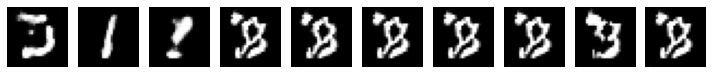

10700 [D loss: 0.033982, acc.: 98.44%] [G loss: 3.967283]
10701 [D loss: 0.032001, acc.: 99.22%] [G loss: 4.804361]
10702 [D loss: 0.077635, acc.: 97.66%] [G loss: 4.652232]
10703 [D loss: 0.044508, acc.: 98.44%] [G loss: 4.259330]
10704 [D loss: 0.035836, acc.: 99.22%] [G loss: 4.075346]
10705 [D loss: 0.015089, acc.: 100.00%] [G loss: 3.555495]
10706 [D loss: 0.064067, acc.: 97.66%] [G loss: 3.587053]
10707 [D loss: 0.076393, acc.: 96.88%] [G loss: 2.510177]
10708 [D loss: 0.045873, acc.: 96.88%] [G loss: 3.787376]
10709 [D loss: 0.042769, acc.: 99.22%] [G loss: 5.504902]
10710 [D loss: 0.062087, acc.: 97.66%] [G loss: 7.315153]
10711 [D loss: 0.073207, acc.: 96.88%] [G loss: 7.267792]
10712 [D loss: 0.041975, acc.: 97.66%] [G loss: 6.144361]
10713 [D loss: 0.035307, acc.: 98.44%] [G loss: 5.329902]
10714 [D loss: 0.050219, acc.: 99.22%] [G loss: 5.063843]
10715 [D loss: 0.125652, acc.: 94.53%] [G loss: 5.508658]
10716 [D loss: 0.083884, acc.: 96.09%] [G loss: 5.896490]
10717 [D loss

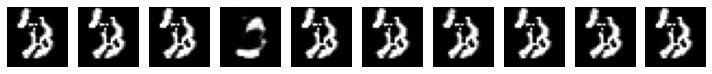

10800 [D loss: 0.046720, acc.: 98.44%] [G loss: 7.854084]
10801 [D loss: 0.052329, acc.: 97.66%] [G loss: 7.705175]
10802 [D loss: 0.038315, acc.: 98.44%] [G loss: 6.876337]
10803 [D loss: 0.029859, acc.: 98.44%] [G loss: 7.168841]
10804 [D loss: 0.041876, acc.: 97.66%] [G loss: 7.227244]
10805 [D loss: 0.062251, acc.: 96.88%] [G loss: 6.949427]
10806 [D loss: 0.041441, acc.: 98.44%] [G loss: 8.121234]
10807 [D loss: 0.011154, acc.: 100.00%] [G loss: 8.628946]
10808 [D loss: 0.101280, acc.: 96.09%] [G loss: 6.851070]
10809 [D loss: 0.090426, acc.: 96.88%] [G loss: 5.393318]
10810 [D loss: 0.037338, acc.: 98.44%] [G loss: 5.547122]
10811 [D loss: 0.031105, acc.: 98.44%] [G loss: 6.087041]
10812 [D loss: 0.018981, acc.: 100.00%] [G loss: 6.508875]
10813 [D loss: 0.063393, acc.: 97.66%] [G loss: 7.788466]
10814 [D loss: 0.078608, acc.: 98.44%] [G loss: 7.638984]
10815 [D loss: 0.102526, acc.: 96.09%] [G loss: 7.015986]
10816 [D loss: 0.077853, acc.: 96.09%] [G loss: 5.315633]
10817 [D los

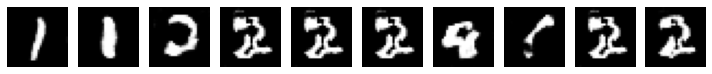

10900 [D loss: 0.009632, acc.: 100.00%] [G loss: 5.600306]
10901 [D loss: 0.104436, acc.: 96.88%] [G loss: 4.493245]
10902 [D loss: 0.083411, acc.: 97.66%] [G loss: 3.742916]
10903 [D loss: 0.060466, acc.: 97.66%] [G loss: 2.965221]
10904 [D loss: 0.050534, acc.: 98.44%] [G loss: 4.903931]
10905 [D loss: 0.072846, acc.: 97.66%] [G loss: 5.035578]
10906 [D loss: 0.039843, acc.: 99.22%] [G loss: 5.439573]
10907 [D loss: 0.063398, acc.: 97.66%] [G loss: 5.864772]
10908 [D loss: 0.126049, acc.: 94.53%] [G loss: 6.647826]
10909 [D loss: 0.018073, acc.: 99.22%] [G loss: 7.348089]
10910 [D loss: 0.075001, acc.: 98.44%] [G loss: 7.362203]
10911 [D loss: 0.090267, acc.: 98.44%] [G loss: 7.054375]
10912 [D loss: 0.087066, acc.: 94.53%] [G loss: 6.839955]
10913 [D loss: 0.026343, acc.: 99.22%] [G loss: 6.657240]
10914 [D loss: 0.016503, acc.: 100.00%] [G loss: 6.556710]
10915 [D loss: 0.041813, acc.: 99.22%] [G loss: 7.561065]
10916 [D loss: 0.043298, acc.: 97.66%] [G loss: 6.887266]
10917 [D los

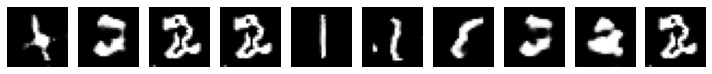

11000 [D loss: 0.027742, acc.: 98.44%] [G loss: 4.165138]
11001 [D loss: 0.038708, acc.: 99.22%] [G loss: 5.171957]
11002 [D loss: 0.154989, acc.: 96.88%] [G loss: 4.752090]
11003 [D loss: 0.065498, acc.: 97.66%] [G loss: 3.815236]
11004 [D loss: 0.039131, acc.: 96.88%] [G loss: 2.948175]
11005 [D loss: 0.043867, acc.: 97.66%] [G loss: 3.865994]
11006 [D loss: 0.075972, acc.: 96.09%] [G loss: 4.695176]
11007 [D loss: 0.026557, acc.: 98.44%] [G loss: 4.777728]
11008 [D loss: 0.041067, acc.: 98.44%] [G loss: 4.826011]
11009 [D loss: 0.024703, acc.: 99.22%] [G loss: 5.052004]
11010 [D loss: 0.033324, acc.: 100.00%] [G loss: 4.307109]
11011 [D loss: 0.068601, acc.: 97.66%] [G loss: 3.679227]
11012 [D loss: 0.034993, acc.: 100.00%] [G loss: 3.312556]
11013 [D loss: 0.033332, acc.: 99.22%] [G loss: 3.307387]
11014 [D loss: 0.065159, acc.: 97.66%] [G loss: 3.710023]
11015 [D loss: 0.091515, acc.: 97.66%] [G loss: 4.292067]
11016 [D loss: 0.022263, acc.: 99.22%] [G loss: 4.499743]
11017 [D los

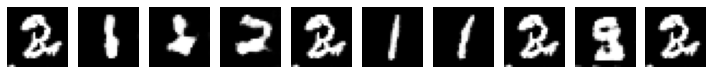

11100 [D loss: 0.022353, acc.: 99.22%] [G loss: 6.333314]
11101 [D loss: 0.015007, acc.: 99.22%] [G loss: 6.548980]
11102 [D loss: 0.073981, acc.: 98.44%] [G loss: 7.178898]
11103 [D loss: 0.009887, acc.: 100.00%] [G loss: 7.264347]
11104 [D loss: 0.056064, acc.: 96.88%] [G loss: 7.419262]
11105 [D loss: 0.068755, acc.: 96.88%] [G loss: 7.317149]
11106 [D loss: 0.018805, acc.: 100.00%] [G loss: 7.132236]
11107 [D loss: 0.046810, acc.: 97.66%] [G loss: 7.326950]
11108 [D loss: 0.029836, acc.: 99.22%] [G loss: 6.973742]
11109 [D loss: 0.028711, acc.: 99.22%] [G loss: 7.470004]
11110 [D loss: 0.039745, acc.: 99.22%] [G loss: 6.960857]
11111 [D loss: 0.086355, acc.: 98.44%] [G loss: 6.202757]
11112 [D loss: 0.029719, acc.: 97.66%] [G loss: 6.070640]
11113 [D loss: 0.030807, acc.: 98.44%] [G loss: 5.849438]
11114 [D loss: 0.063964, acc.: 96.88%] [G loss: 6.041260]
11115 [D loss: 0.031121, acc.: 97.66%] [G loss: 5.956070]
11116 [D loss: 0.063713, acc.: 96.09%] [G loss: 6.515207]
11117 [D los

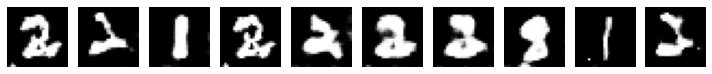

11200 [D loss: 0.031705, acc.: 98.44%] [G loss: 5.215634]
11201 [D loss: 0.047836, acc.: 98.44%] [G loss: 5.012340]
11202 [D loss: 0.072867, acc.: 97.66%] [G loss: 5.511351]
11203 [D loss: 0.040296, acc.: 99.22%] [G loss: 5.146795]
11204 [D loss: 0.044229, acc.: 98.44%] [G loss: 5.179979]
11205 [D loss: 0.039734, acc.: 98.44%] [G loss: 4.850275]
11206 [D loss: 0.031935, acc.: 98.44%] [G loss: 6.086478]
11207 [D loss: 0.091606, acc.: 97.66%] [G loss: 5.712852]
11208 [D loss: 0.042019, acc.: 98.44%] [G loss: 6.177187]
11209 [D loss: 0.057334, acc.: 97.66%] [G loss: 5.682818]
11210 [D loss: 0.046482, acc.: 97.66%] [G loss: 5.893446]
11211 [D loss: 0.045391, acc.: 98.44%] [G loss: 5.620667]
11212 [D loss: 0.046102, acc.: 98.44%] [G loss: 5.490278]
11213 [D loss: 0.063811, acc.: 96.88%] [G loss: 5.230742]
11214 [D loss: 0.048059, acc.: 97.66%] [G loss: 4.596308]
11215 [D loss: 0.010143, acc.: 100.00%] [G loss: 6.540790]
11216 [D loss: 0.034212, acc.: 99.22%] [G loss: 5.688705]
11217 [D loss

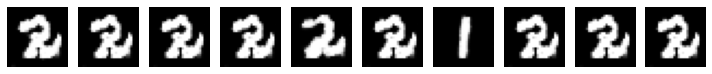

11300 [D loss: 0.102443, acc.: 97.66%] [G loss: 6.560954]
11301 [D loss: 0.057767, acc.: 96.88%] [G loss: 6.098139]
11302 [D loss: 0.064071, acc.: 97.66%] [G loss: 5.252061]
11303 [D loss: 0.084567, acc.: 96.09%] [G loss: 4.534886]
11304 [D loss: 0.043929, acc.: 98.44%] [G loss: 4.703581]
11305 [D loss: 0.013687, acc.: 100.00%] [G loss: 5.050787]
11306 [D loss: 0.061213, acc.: 98.44%] [G loss: 4.717130]
11307 [D loss: 0.087436, acc.: 96.09%] [G loss: 4.538432]
11308 [D loss: 0.039052, acc.: 97.66%] [G loss: 5.311914]
11309 [D loss: 0.124063, acc.: 96.09%] [G loss: 4.392460]
11310 [D loss: 0.048113, acc.: 96.88%] [G loss: 4.982721]
11311 [D loss: 0.115445, acc.: 96.88%] [G loss: 5.219698]
11312 [D loss: 0.069997, acc.: 96.09%] [G loss: 4.809070]
11313 [D loss: 0.052458, acc.: 97.66%] [G loss: 4.230489]
11314 [D loss: 0.104424, acc.: 94.53%] [G loss: 3.817976]
11315 [D loss: 0.087298, acc.: 95.31%] [G loss: 2.970345]
11316 [D loss: 0.035650, acc.: 99.22%] [G loss: 3.723126]
11317 [D loss

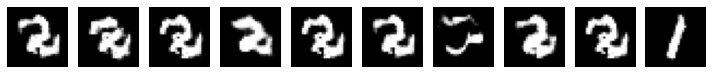

11400 [D loss: 0.056044, acc.: 96.88%] [G loss: 4.813166]
11401 [D loss: 0.033560, acc.: 99.22%] [G loss: 5.075472]
11402 [D loss: 0.033201, acc.: 99.22%] [G loss: 4.866065]
11403 [D loss: 0.033330, acc.: 98.44%] [G loss: 5.801284]
11404 [D loss: 0.039471, acc.: 98.44%] [G loss: 6.048903]
11405 [D loss: 0.067643, acc.: 96.88%] [G loss: 5.731832]
11406 [D loss: 0.024454, acc.: 99.22%] [G loss: 4.804969]
11407 [D loss: 0.037024, acc.: 99.22%] [G loss: 3.999240]
11408 [D loss: 0.085060, acc.: 98.44%] [G loss: 4.051418]
11409 [D loss: 0.098692, acc.: 96.09%] [G loss: 3.718484]
11410 [D loss: 0.021497, acc.: 100.00%] [G loss: 3.516468]
11411 [D loss: 0.072735, acc.: 98.44%] [G loss: 3.991709]
11412 [D loss: 0.044612, acc.: 98.44%] [G loss: 4.954026]
11413 [D loss: 0.006256, acc.: 100.00%] [G loss: 5.571216]
11414 [D loss: 0.016219, acc.: 99.22%] [G loss: 6.326582]
11415 [D loss: 0.133026, acc.: 96.09%] [G loss: 5.117367]
11416 [D loss: 0.036385, acc.: 99.22%] [G loss: 4.140394]
11417 [D los

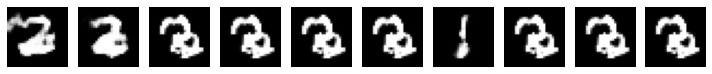

11500 [D loss: 0.074466, acc.: 97.66%] [G loss: 2.466012]
11501 [D loss: 0.025682, acc.: 99.22%] [G loss: 2.793070]
11502 [D loss: 0.043748, acc.: 98.44%] [G loss: 3.403487]
11503 [D loss: 0.027774, acc.: 99.22%] [G loss: 3.461660]
11504 [D loss: 0.065724, acc.: 98.44%] [G loss: 3.943257]
11505 [D loss: 0.062349, acc.: 97.66%] [G loss: 4.057317]
11506 [D loss: 0.045101, acc.: 97.66%] [G loss: 3.590528]
11507 [D loss: 0.070019, acc.: 96.88%] [G loss: 3.102334]
11508 [D loss: 0.037022, acc.: 99.22%] [G loss: 2.563210]
11509 [D loss: 0.065339, acc.: 96.88%] [G loss: 1.854411]
11510 [D loss: 0.083465, acc.: 96.09%] [G loss: 2.062178]
11511 [D loss: 0.042275, acc.: 97.66%] [G loss: 1.945968]
11512 [D loss: 0.016793, acc.: 100.00%] [G loss: 2.405543]
11513 [D loss: 0.045161, acc.: 98.44%] [G loss: 2.561552]
11514 [D loss: 0.074232, acc.: 97.66%] [G loss: 3.034642]
11515 [D loss: 0.047465, acc.: 97.66%] [G loss: 2.679404]
11516 [D loss: 0.057422, acc.: 97.66%] [G loss: 2.170491]
11517 [D loss

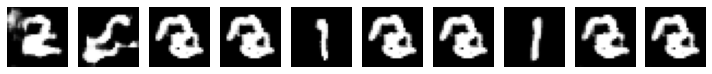

11600 [D loss: 0.124549, acc.: 96.09%] [G loss: 5.179460]
11601 [D loss: 0.069197, acc.: 97.66%] [G loss: 5.176161]
11602 [D loss: 0.026127, acc.: 99.22%] [G loss: 5.798970]
11603 [D loss: 0.068394, acc.: 97.66%] [G loss: 6.056583]
11604 [D loss: 0.025151, acc.: 99.22%] [G loss: 5.566759]
11605 [D loss: 0.009744, acc.: 100.00%] [G loss: 6.279117]
11606 [D loss: 0.037451, acc.: 98.44%] [G loss: 5.809280]
11607 [D loss: 0.051916, acc.: 97.66%] [G loss: 5.485342]
11608 [D loss: 0.044497, acc.: 97.66%] [G loss: 5.519154]
11609 [D loss: 0.026461, acc.: 99.22%] [G loss: 5.605193]
11610 [D loss: 0.053839, acc.: 97.66%] [G loss: 5.858907]
11611 [D loss: 0.023203, acc.: 99.22%] [G loss: 5.920493]
11612 [D loss: 0.020158, acc.: 100.00%] [G loss: 6.023160]
11613 [D loss: 0.069399, acc.: 97.66%] [G loss: 5.691994]
11614 [D loss: 0.093524, acc.: 97.66%] [G loss: 4.656033]
11615 [D loss: 0.123183, acc.: 95.31%] [G loss: 3.845764]
11616 [D loss: 0.043830, acc.: 98.44%] [G loss: 4.404148]
11617 [D los

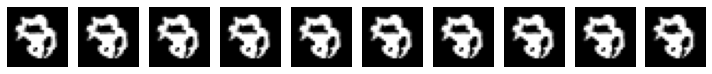

11700 [D loss: 0.042196, acc.: 98.44%] [G loss: 7.690167]
11701 [D loss: 0.047164, acc.: 96.88%] [G loss: 7.193118]
11702 [D loss: 0.053571, acc.: 98.44%] [G loss: 6.499642]
11703 [D loss: 0.020885, acc.: 100.00%] [G loss: 6.127807]
11704 [D loss: 0.081970, acc.: 96.09%] [G loss: 4.042882]
11705 [D loss: 0.082275, acc.: 98.44%] [G loss: 4.452611]
11706 [D loss: 0.025428, acc.: 100.00%] [G loss: 5.556501]
11707 [D loss: 0.026220, acc.: 100.00%] [G loss: 5.950319]
11708 [D loss: 0.076918, acc.: 97.66%] [G loss: 6.416755]
11709 [D loss: 0.057473, acc.: 97.66%] [G loss: 5.381273]
11710 [D loss: 0.099481, acc.: 94.53%] [G loss: 4.243285]
11711 [D loss: 0.028397, acc.: 99.22%] [G loss: 5.178371]
11712 [D loss: 0.054415, acc.: 97.66%] [G loss: 4.011141]
11713 [D loss: 0.039695, acc.: 98.44%] [G loss: 4.313085]
11714 [D loss: 0.024942, acc.: 99.22%] [G loss: 4.193756]
11715 [D loss: 0.055342, acc.: 98.44%] [G loss: 3.810395]
11716 [D loss: 0.022111, acc.: 99.22%] [G loss: 3.432251]
11717 [D lo

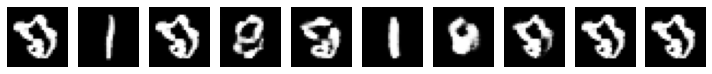

11800 [D loss: 0.039920, acc.: 98.44%] [G loss: 5.956510]
11801 [D loss: 0.028726, acc.: 99.22%] [G loss: 5.009333]
11802 [D loss: 0.075614, acc.: 96.88%] [G loss: 4.927994]
11803 [D loss: 0.023055, acc.: 99.22%] [G loss: 5.602332]
11804 [D loss: 0.102120, acc.: 96.09%] [G loss: 5.387641]
11805 [D loss: 0.085437, acc.: 97.66%] [G loss: 6.613060]
11806 [D loss: 0.030370, acc.: 98.44%] [G loss: 6.780422]
11807 [D loss: 0.023797, acc.: 100.00%] [G loss: 7.010122]
11808 [D loss: 0.045597, acc.: 98.44%] [G loss: 7.111948]
11809 [D loss: 0.081901, acc.: 95.31%] [G loss: 6.875085]
11810 [D loss: 0.098552, acc.: 94.53%] [G loss: 5.801697]
11811 [D loss: 0.071501, acc.: 97.66%] [G loss: 5.305209]
11812 [D loss: 0.040266, acc.: 97.66%] [G loss: 6.194230]
11813 [D loss: 0.028961, acc.: 100.00%] [G loss: 7.277260]
11814 [D loss: 0.095362, acc.: 96.09%] [G loss: 6.039418]
11815 [D loss: 0.076474, acc.: 96.88%] [G loss: 4.594282]
11816 [D loss: 0.064292, acc.: 96.88%] [G loss: 4.765826]
11817 [D los

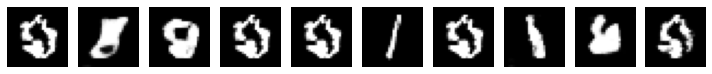

11900 [D loss: 0.146100, acc.: 96.09%] [G loss: 4.477804]
11901 [D loss: 0.033964, acc.: 99.22%] [G loss: 3.182613]
11902 [D loss: 0.044861, acc.: 98.44%] [G loss: 2.905264]
11903 [D loss: 0.045206, acc.: 98.44%] [G loss: 3.163364]
11904 [D loss: 0.012420, acc.: 100.00%] [G loss: 4.373475]
11905 [D loss: 0.042515, acc.: 99.22%] [G loss: 4.741581]
11906 [D loss: 0.032052, acc.: 99.22%] [G loss: 5.041240]
11907 [D loss: 0.004979, acc.: 100.00%] [G loss: 5.399127]
11908 [D loss: 0.064814, acc.: 96.88%] [G loss: 4.522624]
11909 [D loss: 0.071302, acc.: 96.88%] [G loss: 3.512837]
11910 [D loss: 0.112819, acc.: 96.88%] [G loss: 2.623752]
11911 [D loss: 0.079628, acc.: 97.66%] [G loss: 3.319505]
11912 [D loss: 0.034969, acc.: 99.22%] [G loss: 4.517451]
11913 [D loss: 0.059016, acc.: 97.66%] [G loss: 5.881099]
11914 [D loss: 0.046256, acc.: 98.44%] [G loss: 6.181762]
11915 [D loss: 0.122569, acc.: 97.66%] [G loss: 6.462083]
11916 [D loss: 0.092485, acc.: 93.75%] [G loss: 5.341692]
11917 [D los

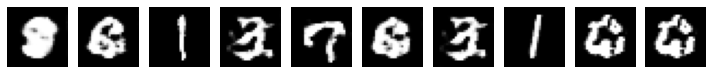

12000 [D loss: 0.038699, acc.: 98.44%] [G loss: 5.096257]
12001 [D loss: 0.047258, acc.: 97.66%] [G loss: 5.410193]
12002 [D loss: 0.039570, acc.: 98.44%] [G loss: 6.009605]
12003 [D loss: 0.020882, acc.: 99.22%] [G loss: 5.713194]
12004 [D loss: 0.016906, acc.: 99.22%] [G loss: 5.979534]
12005 [D loss: 0.059413, acc.: 96.09%] [G loss: 3.951777]
12006 [D loss: 0.077063, acc.: 95.31%] [G loss: 3.091011]
12007 [D loss: 0.086420, acc.: 96.88%] [G loss: 4.211609]
12008 [D loss: 0.039010, acc.: 97.66%] [G loss: 5.377577]
12009 [D loss: 0.151968, acc.: 93.75%] [G loss: 5.739496]
12010 [D loss: 0.065746, acc.: 96.09%] [G loss: 5.684126]
12011 [D loss: 0.032888, acc.: 98.44%] [G loss: 5.597701]
12012 [D loss: 0.086314, acc.: 96.88%] [G loss: 6.390729]
12013 [D loss: 0.086861, acc.: 96.88%] [G loss: 6.102025]
12014 [D loss: 0.073368, acc.: 95.31%] [G loss: 4.265889]
12015 [D loss: 0.079432, acc.: 96.88%] [G loss: 3.097170]
12016 [D loss: 0.027572, acc.: 100.00%] [G loss: 2.035119]
12017 [D loss

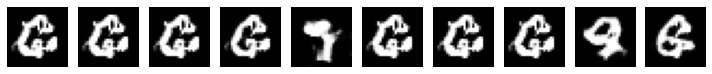

12100 [D loss: 0.096241, acc.: 96.88%] [G loss: 3.720489]
12101 [D loss: 0.054007, acc.: 96.88%] [G loss: 2.231808]
12102 [D loss: 0.050440, acc.: 99.22%] [G loss: 3.590780]
12103 [D loss: 0.018898, acc.: 99.22%] [G loss: 4.323052]
12104 [D loss: 0.005224, acc.: 100.00%] [G loss: 4.909363]
12105 [D loss: 0.038449, acc.: 97.66%] [G loss: 5.294244]
12106 [D loss: 0.074563, acc.: 96.09%] [G loss: 5.430407]
12107 [D loss: 0.040325, acc.: 98.44%] [G loss: 5.345935]
12108 [D loss: 0.020792, acc.: 100.00%] [G loss: 5.078871]
12109 [D loss: 0.059214, acc.: 98.44%] [G loss: 4.594529]
12110 [D loss: 0.022093, acc.: 99.22%] [G loss: 4.208304]
12111 [D loss: 0.019020, acc.: 100.00%] [G loss: 3.512591]
12112 [D loss: 0.076266, acc.: 97.66%] [G loss: 4.526866]
12113 [D loss: 0.028920, acc.: 98.44%] [G loss: 4.696322]
12114 [D loss: 0.088440, acc.: 96.09%] [G loss: 5.901833]
12115 [D loss: 0.045491, acc.: 97.66%] [G loss: 6.314075]
12116 [D loss: 0.035163, acc.: 99.22%] [G loss: 6.673155]
12117 [D lo

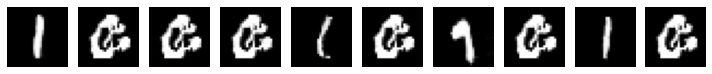

12200 [D loss: 0.033882, acc.: 98.44%] [G loss: 8.305278]
12201 [D loss: 0.056930, acc.: 98.44%] [G loss: 8.063864]
12202 [D loss: 0.131319, acc.: 93.75%] [G loss: 6.274822]
12203 [D loss: 0.026796, acc.: 99.22%] [G loss: 5.492047]
12204 [D loss: 0.111568, acc.: 96.88%] [G loss: 5.256311]
12205 [D loss: 0.057296, acc.: 97.66%] [G loss: 6.149976]
12206 [D loss: 0.041777, acc.: 98.44%] [G loss: 6.110195]
12207 [D loss: 0.031213, acc.: 97.66%] [G loss: 7.424316]
12208 [D loss: 0.038762, acc.: 97.66%] [G loss: 7.525899]
12209 [D loss: 0.087257, acc.: 96.09%] [G loss: 6.491198]
12210 [D loss: 0.085843, acc.: 97.66%] [G loss: 5.707428]
12211 [D loss: 0.039535, acc.: 98.44%] [G loss: 5.034536]
12212 [D loss: 0.076138, acc.: 98.44%] [G loss: 4.672649]
12213 [D loss: 0.074431, acc.: 97.66%] [G loss: 4.862632]
12214 [D loss: 0.063743, acc.: 97.66%] [G loss: 5.210741]
12215 [D loss: 0.030760, acc.: 97.66%] [G loss: 5.552864]
12216 [D loss: 0.068040, acc.: 97.66%] [G loss: 5.736953]
12217 [D loss:

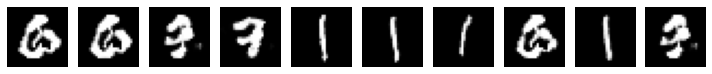

12300 [D loss: 0.106276, acc.: 96.09%] [G loss: 5.251750]
12301 [D loss: 0.072478, acc.: 96.88%] [G loss: 5.338247]
12302 [D loss: 0.006251, acc.: 100.00%] [G loss: 7.193874]
12303 [D loss: 0.064916, acc.: 97.66%] [G loss: 6.907705]
12304 [D loss: 0.035109, acc.: 98.44%] [G loss: 7.011287]
12305 [D loss: 0.029480, acc.: 98.44%] [G loss: 5.606125]
12306 [D loss: 0.075143, acc.: 96.88%] [G loss: 5.889714]
12307 [D loss: 0.106084, acc.: 96.88%] [G loss: 5.606990]
12308 [D loss: 0.006583, acc.: 100.00%] [G loss: 5.870364]
12309 [D loss: 0.111024, acc.: 96.88%] [G loss: 5.729732]
12310 [D loss: 0.040054, acc.: 99.22%] [G loss: 5.187924]
12311 [D loss: 0.072694, acc.: 97.66%] [G loss: 4.378269]
12312 [D loss: 0.084133, acc.: 95.31%] [G loss: 3.618028]
12313 [D loss: 0.076491, acc.: 95.31%] [G loss: 3.219216]
12314 [D loss: 0.068728, acc.: 97.66%] [G loss: 3.052848]
12315 [D loss: 0.039849, acc.: 97.66%] [G loss: 3.338687]
12316 [D loss: 0.073891, acc.: 96.88%] [G loss: 3.412888]
12317 [D los

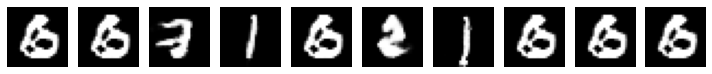

12400 [D loss: 0.063520, acc.: 97.66%] [G loss: 6.375971]
12401 [D loss: 0.099155, acc.: 96.88%] [G loss: 5.249175]
12402 [D loss: 0.032813, acc.: 100.00%] [G loss: 4.527960]
12403 [D loss: 0.022774, acc.: 98.44%] [G loss: 3.924539]
12404 [D loss: 0.044166, acc.: 99.22%] [G loss: 4.047214]
12405 [D loss: 0.064580, acc.: 96.88%] [G loss: 4.178227]
12406 [D loss: 0.073960, acc.: 96.88%] [G loss: 4.884991]
12407 [D loss: 0.050301, acc.: 97.66%] [G loss: 6.320865]
12408 [D loss: 0.061250, acc.: 97.66%] [G loss: 5.890591]
12409 [D loss: 0.098312, acc.: 92.97%] [G loss: 7.101056]
12410 [D loss: 0.031230, acc.: 98.44%] [G loss: 7.463537]
12411 [D loss: 0.091125, acc.: 96.88%] [G loss: 7.721169]
12412 [D loss: 0.037436, acc.: 99.22%] [G loss: 7.614153]
12413 [D loss: 0.052437, acc.: 96.88%] [G loss: 7.915998]
12414 [D loss: 0.024315, acc.: 98.44%] [G loss: 8.269835]
12415 [D loss: 0.021039, acc.: 99.22%] [G loss: 8.236461]
12416 [D loss: 0.053822, acc.: 97.66%] [G loss: 7.978914]
12417 [D loss

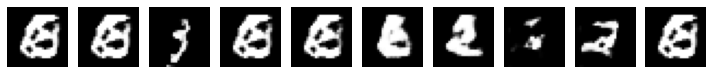

12500 [D loss: 0.106371, acc.: 93.75%] [G loss: 14.128226]
12501 [D loss: 0.111206, acc.: 92.97%] [G loss: 14.514020]
12502 [D loss: 0.035143, acc.: 99.22%] [G loss: 13.249977]
12503 [D loss: 0.213563, acc.: 91.41%] [G loss: 15.034136]
12504 [D loss: 0.122280, acc.: 95.31%] [G loss: 14.621018]
12505 [D loss: 0.064129, acc.: 98.44%] [G loss: 14.689861]
12506 [D loss: 0.025854, acc.: 98.44%] [G loss: 15.006876]
12507 [D loss: 0.117505, acc.: 96.09%] [G loss: 11.629253]
12508 [D loss: 0.221446, acc.: 93.75%] [G loss: 9.726101]
12509 [D loss: 0.045362, acc.: 98.44%] [G loss: 8.452856]
12510 [D loss: 0.095194, acc.: 98.44%] [G loss: 7.987823]
12511 [D loss: 0.063851, acc.: 96.88%] [G loss: 8.871841]
12512 [D loss: 0.066568, acc.: 96.09%] [G loss: 9.771719]
12513 [D loss: 0.007984, acc.: 100.00%] [G loss: 10.360312]
12514 [D loss: 0.029257, acc.: 99.22%] [G loss: 10.246675]
12515 [D loss: 0.014647, acc.: 99.22%] [G loss: 10.087088]
12516 [D loss: 0.038484, acc.: 98.44%] [G loss: 10.381557]
1

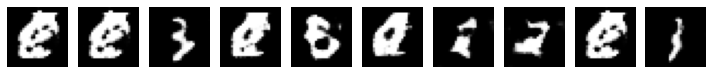

12600 [D loss: 0.043667, acc.: 98.44%] [G loss: 4.351015]
12601 [D loss: 0.111828, acc.: 95.31%] [G loss: 4.953722]
12602 [D loss: 0.044231, acc.: 97.66%] [G loss: 5.755166]
12603 [D loss: 0.044115, acc.: 97.66%] [G loss: 5.449048]
12604 [D loss: 0.037476, acc.: 98.44%] [G loss: 4.521634]
12605 [D loss: 0.047515, acc.: 97.66%] [G loss: 3.442738]
12606 [D loss: 0.071822, acc.: 97.66%] [G loss: 2.504875]
12607 [D loss: 0.097481, acc.: 96.88%] [G loss: 2.577001]
12608 [D loss: 0.107538, acc.: 96.88%] [G loss: 2.344368]
12609 [D loss: 0.070122, acc.: 97.66%] [G loss: 3.996594]
12610 [D loss: 0.072193, acc.: 97.66%] [G loss: 4.228871]
12611 [D loss: 0.057726, acc.: 96.88%] [G loss: 4.433724]
12612 [D loss: 0.156298, acc.: 95.31%] [G loss: 3.496717]
12613 [D loss: 0.024906, acc.: 100.00%] [G loss: 2.899119]
12614 [D loss: 0.111869, acc.: 95.31%] [G loss: 3.107157]
12615 [D loss: 0.062205, acc.: 96.88%] [G loss: 3.647475]
12616 [D loss: 0.085657, acc.: 95.31%] [G loss: 3.626461]
12617 [D loss

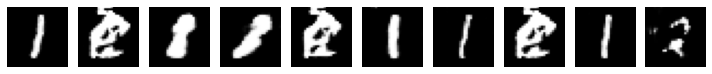

12700 [D loss: 0.082154, acc.: 97.66%] [G loss: 7.470012]
12701 [D loss: 0.066139, acc.: 98.44%] [G loss: 7.449928]
12702 [D loss: 0.042614, acc.: 98.44%] [G loss: 6.846074]
12703 [D loss: 0.043753, acc.: 99.22%] [G loss: 7.024387]
12704 [D loss: 0.028058, acc.: 98.44%] [G loss: 6.314682]
12705 [D loss: 0.038632, acc.: 97.66%] [G loss: 6.574779]
12706 [D loss: 0.069269, acc.: 96.88%] [G loss: 6.078066]
12707 [D loss: 0.056245, acc.: 96.88%] [G loss: 5.389355]
12708 [D loss: 0.028473, acc.: 99.22%] [G loss: 4.952412]
12709 [D loss: 0.074669, acc.: 96.88%] [G loss: 5.431289]
12710 [D loss: 0.057566, acc.: 97.66%] [G loss: 7.145085]
12711 [D loss: 0.026849, acc.: 100.00%] [G loss: 8.397038]
12712 [D loss: 0.060282, acc.: 98.44%] [G loss: 8.326550]
12713 [D loss: 0.041672, acc.: 98.44%] [G loss: 7.704018]
12714 [D loss: 0.046939, acc.: 98.44%] [G loss: 6.638052]
12715 [D loss: 0.108853, acc.: 96.09%] [G loss: 5.127497]
12716 [D loss: 0.090670, acc.: 94.53%] [G loss: 3.453036]
12717 [D loss

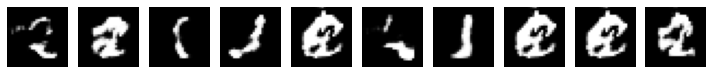

12800 [D loss: 0.059493, acc.: 98.44%] [G loss: 6.286590]
12801 [D loss: 0.010228, acc.: 100.00%] [G loss: 5.530150]
12802 [D loss: 0.074639, acc.: 97.66%] [G loss: 5.263479]
12803 [D loss: 0.035936, acc.: 98.44%] [G loss: 4.109497]
12804 [D loss: 0.109326, acc.: 96.09%] [G loss: 4.063963]
12805 [D loss: 0.025163, acc.: 98.44%] [G loss: 6.043948]
12806 [D loss: 0.041754, acc.: 99.22%] [G loss: 7.715548]
12807 [D loss: 0.061786, acc.: 98.44%] [G loss: 8.166656]
12808 [D loss: 0.018224, acc.: 100.00%] [G loss: 8.448505]
12809 [D loss: 0.037692, acc.: 99.22%] [G loss: 8.308655]
12810 [D loss: 0.122145, acc.: 94.53%] [G loss: 7.664988]
12811 [D loss: 0.084329, acc.: 96.88%] [G loss: 6.805192]
12812 [D loss: 0.024938, acc.: 99.22%] [G loss: 6.949109]
12813 [D loss: 0.046914, acc.: 98.44%] [G loss: 8.174207]
12814 [D loss: 0.014860, acc.: 100.00%] [G loss: 7.589767]
12815 [D loss: 0.121583, acc.: 96.09%] [G loss: 6.605288]
12816 [D loss: 0.028906, acc.: 99.22%] [G loss: 6.325236]
12817 [D lo

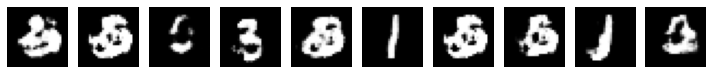

12900 [D loss: 0.047798, acc.: 98.44%] [G loss: 1.879527]
12901 [D loss: 0.091112, acc.: 96.09%] [G loss: 2.699298]
12902 [D loss: 0.020340, acc.: 99.22%] [G loss: 4.498741]
12903 [D loss: 0.036412, acc.: 98.44%] [G loss: 5.330306]
12904 [D loss: 0.047097, acc.: 98.44%] [G loss: 5.685673]
12905 [D loss: 0.008052, acc.: 100.00%] [G loss: 5.590853]
12906 [D loss: 0.018125, acc.: 99.22%] [G loss: 5.866837]
12907 [D loss: 0.054363, acc.: 96.09%] [G loss: 4.980910]
12908 [D loss: 0.041809, acc.: 97.66%] [G loss: 4.638531]
12909 [D loss: 0.049014, acc.: 97.66%] [G loss: 3.819537]
12910 [D loss: 0.063881, acc.: 96.88%] [G loss: 3.613298]
12911 [D loss: 0.043381, acc.: 99.22%] [G loss: 2.988484]
12912 [D loss: 0.018105, acc.: 100.00%] [G loss: 2.967233]
12913 [D loss: 0.006725, acc.: 100.00%] [G loss: 3.490640]
12914 [D loss: 0.075620, acc.: 96.88%] [G loss: 2.983233]
12915 [D loss: 0.023385, acc.: 99.22%] [G loss: 4.023061]
12916 [D loss: 0.063811, acc.: 97.66%] [G loss: 4.144314]
12917 [D lo

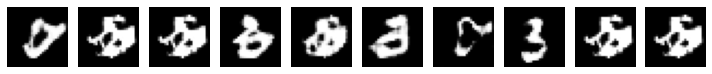

13000 [D loss: 0.048512, acc.: 96.88%] [G loss: 3.972307]
13001 [D loss: 0.059513, acc.: 97.66%] [G loss: 2.974002]
13002 [D loss: 0.038296, acc.: 98.44%] [G loss: 3.053707]
13003 [D loss: 0.038342, acc.: 98.44%] [G loss: 3.031257]
13004 [D loss: 0.057382, acc.: 97.66%] [G loss: 2.356302]
13005 [D loss: 0.061385, acc.: 97.66%] [G loss: 2.916605]
13006 [D loss: 0.030350, acc.: 99.22%] [G loss: 2.744212]
13007 [D loss: 0.061762, acc.: 96.88%] [G loss: 4.382584]
13008 [D loss: 0.019141, acc.: 100.00%] [G loss: 5.158332]
13009 [D loss: 0.015524, acc.: 100.00%] [G loss: 5.607941]
13010 [D loss: 0.048408, acc.: 98.44%] [G loss: 6.071569]
13011 [D loss: 0.083603, acc.: 95.31%] [G loss: 5.375579]
13012 [D loss: 0.152734, acc.: 92.19%] [G loss: 4.209731]
13013 [D loss: 0.067798, acc.: 97.66%] [G loss: 4.608146]
13014 [D loss: 0.139058, acc.: 93.75%] [G loss: 3.924420]
13015 [D loss: 0.018217, acc.: 99.22%] [G loss: 3.844107]
13016 [D loss: 0.179606, acc.: 94.53%] [G loss: 2.805840]
13017 [D los

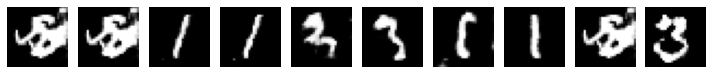

13100 [D loss: 0.036072, acc.: 99.22%] [G loss: 4.942967]
13101 [D loss: 0.071278, acc.: 97.66%] [G loss: 5.507916]
13102 [D loss: 0.031020, acc.: 98.44%] [G loss: 6.687918]
13103 [D loss: 0.018269, acc.: 99.22%] [G loss: 7.524648]
13104 [D loss: 0.044334, acc.: 98.44%] [G loss: 8.470641]
13105 [D loss: 0.120705, acc.: 96.09%] [G loss: 6.970977]
13106 [D loss: 0.071828, acc.: 96.88%] [G loss: 5.769201]
13107 [D loss: 0.086365, acc.: 94.53%] [G loss: 5.188845]
13108 [D loss: 0.042422, acc.: 99.22%] [G loss: 6.610029]
13109 [D loss: 0.012540, acc.: 100.00%] [G loss: 9.084364]
13110 [D loss: 0.071622, acc.: 96.88%] [G loss: 9.261640]
13111 [D loss: 0.104921, acc.: 96.88%] [G loss: 8.158308]
13112 [D loss: 0.064820, acc.: 97.66%] [G loss: 8.092884]
13113 [D loss: 0.031289, acc.: 98.44%] [G loss: 6.798408]
13114 [D loss: 0.012209, acc.: 100.00%] [G loss: 6.319197]
13115 [D loss: 0.031659, acc.: 99.22%] [G loss: 6.663167]
13116 [D loss: 0.052618, acc.: 98.44%] [G loss: 7.075649]
13117 [D los

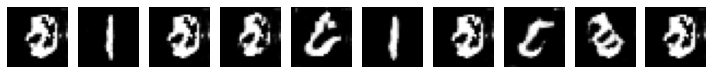

13200 [D loss: 0.027366, acc.: 98.44%] [G loss: 8.056328]
13201 [D loss: 0.050337, acc.: 97.66%] [G loss: 9.419466]
13202 [D loss: 0.039183, acc.: 98.44%] [G loss: 9.789858]
13203 [D loss: 0.085840, acc.: 96.09%] [G loss: 10.319013]
13204 [D loss: 0.067153, acc.: 98.44%] [G loss: 9.970574]
13205 [D loss: 0.073516, acc.: 96.09%] [G loss: 10.038340]
13206 [D loss: 0.127416, acc.: 95.31%] [G loss: 9.956964]
13207 [D loss: 0.008141, acc.: 100.00%] [G loss: 9.149525]
13208 [D loss: 0.053699, acc.: 97.66%] [G loss: 8.494080]
13209 [D loss: 0.051874, acc.: 98.44%] [G loss: 8.793900]
13210 [D loss: 0.091979, acc.: 97.66%] [G loss: 7.242583]
13211 [D loss: 0.088351, acc.: 96.09%] [G loss: 6.943871]
13212 [D loss: 0.055370, acc.: 96.88%] [G loss: 7.215740]
13213 [D loss: 0.044345, acc.: 97.66%] [G loss: 7.542991]
13214 [D loss: 0.071878, acc.: 95.31%] [G loss: 7.655679]
13215 [D loss: 0.062907, acc.: 97.66%] [G loss: 7.669874]
13216 [D loss: 0.079384, acc.: 96.88%] [G loss: 9.678995]
13217 [D lo

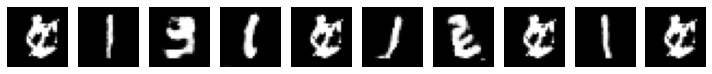

13300 [D loss: 0.110551, acc.: 96.88%] [G loss: 4.210910]
13301 [D loss: 0.070377, acc.: 96.09%] [G loss: 4.137723]
13302 [D loss: 0.066164, acc.: 97.66%] [G loss: 4.137605]
13303 [D loss: 0.027415, acc.: 99.22%] [G loss: 3.819767]
13304 [D loss: 0.044775, acc.: 98.44%] [G loss: 5.366141]
13305 [D loss: 0.040392, acc.: 98.44%] [G loss: 4.751768]
13306 [D loss: 0.058297, acc.: 96.88%] [G loss: 4.491038]
13307 [D loss: 0.040846, acc.: 98.44%] [G loss: 3.544141]
13308 [D loss: 0.023349, acc.: 99.22%] [G loss: 3.231836]
13309 [D loss: 0.052321, acc.: 97.66%] [G loss: 3.075224]
13310 [D loss: 0.060485, acc.: 97.66%] [G loss: 3.218165]
13311 [D loss: 0.057827, acc.: 97.66%] [G loss: 3.724549]
13312 [D loss: 0.019229, acc.: 100.00%] [G loss: 4.907382]
13313 [D loss: 0.010963, acc.: 100.00%] [G loss: 5.164060]
13314 [D loss: 0.087763, acc.: 96.88%] [G loss: 4.966695]
13315 [D loss: 0.030523, acc.: 98.44%] [G loss: 3.980266]
13316 [D loss: 0.026664, acc.: 99.22%] [G loss: 4.031272]
13317 [D los

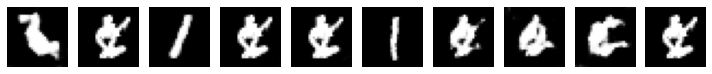

13400 [D loss: 0.009938, acc.: 100.00%] [G loss: 6.419766]
13401 [D loss: 0.051038, acc.: 98.44%] [G loss: 6.286499]
13402 [D loss: 0.051566, acc.: 97.66%] [G loss: 5.707057]
13403 [D loss: 0.019637, acc.: 100.00%] [G loss: 5.270357]
13404 [D loss: 0.068105, acc.: 96.09%] [G loss: 4.532505]
13405 [D loss: 0.055843, acc.: 98.44%] [G loss: 3.924641]
13406 [D loss: 0.034334, acc.: 98.44%] [G loss: 3.974295]
13407 [D loss: 0.051419, acc.: 97.66%] [G loss: 5.339826]
13408 [D loss: 0.023145, acc.: 100.00%] [G loss: 7.659811]
13409 [D loss: 0.035900, acc.: 98.44%] [G loss: 8.178730]
13410 [D loss: 0.007366, acc.: 100.00%] [G loss: 8.772880]
13411 [D loss: 0.044248, acc.: 97.66%] [G loss: 8.620768]
13412 [D loss: 0.072110, acc.: 96.88%] [G loss: 8.229908]
13413 [D loss: 0.039262, acc.: 98.44%] [G loss: 7.552896]
13414 [D loss: 0.046974, acc.: 99.22%] [G loss: 6.651956]
13415 [D loss: 0.155810, acc.: 91.41%] [G loss: 4.887028]
13416 [D loss: 0.099360, acc.: 96.88%] [G loss: 3.757692]
13417 [D l

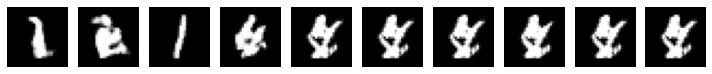

13500 [D loss: 0.129778, acc.: 93.75%] [G loss: 3.702884]
13501 [D loss: 0.031282, acc.: 98.44%] [G loss: 5.064339]
13502 [D loss: 0.012195, acc.: 100.00%] [G loss: 6.015471]
13503 [D loss: 0.078720, acc.: 97.66%] [G loss: 5.760525]
13504 [D loss: 0.066003, acc.: 96.88%] [G loss: 5.579656]
13505 [D loss: 0.061071, acc.: 97.66%] [G loss: 5.227134]
13506 [D loss: 0.027980, acc.: 99.22%] [G loss: 5.541564]
13507 [D loss: 0.055795, acc.: 98.44%] [G loss: 4.062431]
13508 [D loss: 0.076299, acc.: 96.88%] [G loss: 3.090480]
13509 [D loss: 0.096913, acc.: 96.88%] [G loss: 3.530758]
13510 [D loss: 0.057488, acc.: 96.09%] [G loss: 4.004659]
13511 [D loss: 0.050116, acc.: 97.66%] [G loss: 4.952042]
13512 [D loss: 0.059763, acc.: 97.66%] [G loss: 5.625830]
13513 [D loss: 0.082848, acc.: 98.44%] [G loss: 5.387726]
13514 [D loss: 0.054653, acc.: 97.66%] [G loss: 5.584326]
13515 [D loss: 0.085096, acc.: 94.53%] [G loss: 5.215214]
13516 [D loss: 0.038783, acc.: 98.44%] [G loss: 6.178349]
13517 [D loss

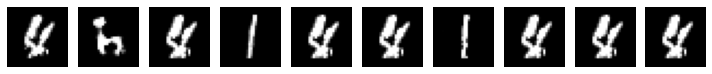

13600 [D loss: 0.056888, acc.: 98.44%] [G loss: 6.857049]
13601 [D loss: 0.080318, acc.: 95.31%] [G loss: 5.853622]
13602 [D loss: 0.034368, acc.: 98.44%] [G loss: 5.977508]
13603 [D loss: 0.042894, acc.: 99.22%] [G loss: 6.091899]
13604 [D loss: 0.035616, acc.: 98.44%] [G loss: 5.886117]
13605 [D loss: 0.049634, acc.: 97.66%] [G loss: 5.985517]
13606 [D loss: 0.085500, acc.: 96.88%] [G loss: 5.025945]
13607 [D loss: 0.034181, acc.: 98.44%] [G loss: 5.201637]
13608 [D loss: 0.023966, acc.: 99.22%] [G loss: 6.395107]
13609 [D loss: 0.025507, acc.: 99.22%] [G loss: 5.933908]
13610 [D loss: 0.050546, acc.: 99.22%] [G loss: 6.427361]
13611 [D loss: 0.090618, acc.: 96.88%] [G loss: 6.596341]
13612 [D loss: 0.037912, acc.: 98.44%] [G loss: 7.099467]
13613 [D loss: 0.110379, acc.: 96.09%] [G loss: 6.162610]
13614 [D loss: 0.058980, acc.: 97.66%] [G loss: 6.231503]
13615 [D loss: 0.046140, acc.: 98.44%] [G loss: 5.904703]
13616 [D loss: 0.028391, acc.: 99.22%] [G loss: 6.248045]
13617 [D loss:

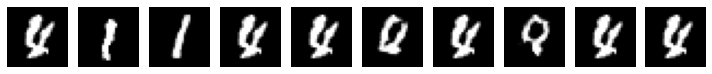

13700 [D loss: 0.119171, acc.: 95.31%] [G loss: 7.035639]
13701 [D loss: 0.040489, acc.: 97.66%] [G loss: 8.637014]
13702 [D loss: 0.053754, acc.: 98.44%] [G loss: 8.544735]
13703 [D loss: 0.104419, acc.: 94.53%] [G loss: 7.470292]
13704 [D loss: 0.039149, acc.: 97.66%] [G loss: 6.544146]
13705 [D loss: 0.029330, acc.: 98.44%] [G loss: 6.883636]
13706 [D loss: 0.062671, acc.: 96.88%] [G loss: 6.205806]
13707 [D loss: 0.056277, acc.: 97.66%] [G loss: 6.383878]
13708 [D loss: 0.051471, acc.: 96.09%] [G loss: 5.838887]
13709 [D loss: 0.026575, acc.: 99.22%] [G loss: 5.640795]
13710 [D loss: 0.055694, acc.: 97.66%] [G loss: 4.854162]
13711 [D loss: 0.074334, acc.: 98.44%] [G loss: 4.940400]
13712 [D loss: 0.035256, acc.: 99.22%] [G loss: 4.442397]
13713 [D loss: 0.065890, acc.: 96.09%] [G loss: 4.458458]
13714 [D loss: 0.013515, acc.: 100.00%] [G loss: 4.313392]
13715 [D loss: 0.088922, acc.: 97.66%] [G loss: 4.884484]
13716 [D loss: 0.051241, acc.: 98.44%] [G loss: 5.058985]
13717 [D loss

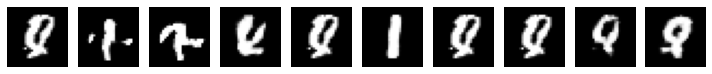

13800 [D loss: 0.023371, acc.: 99.22%] [G loss: 6.495742]
13801 [D loss: 0.032783, acc.: 98.44%] [G loss: 6.034035]
13802 [D loss: 0.080522, acc.: 95.31%] [G loss: 5.296226]
13803 [D loss: 0.097148, acc.: 96.09%] [G loss: 5.800073]
13804 [D loss: 0.044833, acc.: 98.44%] [G loss: 6.337468]
13805 [D loss: 0.056523, acc.: 98.44%] [G loss: 6.211241]
13806 [D loss: 0.014518, acc.: 99.22%] [G loss: 5.540955]
13807 [D loss: 0.103088, acc.: 95.31%] [G loss: 4.735074]
13808 [D loss: 0.054567, acc.: 97.66%] [G loss: 4.420959]
13809 [D loss: 0.037821, acc.: 99.22%] [G loss: 4.650571]
13810 [D loss: 0.072002, acc.: 96.09%] [G loss: 5.602850]
13811 [D loss: 0.025667, acc.: 99.22%] [G loss: 6.266817]
13812 [D loss: 0.091662, acc.: 96.09%] [G loss: 6.455790]
13813 [D loss: 0.015238, acc.: 100.00%] [G loss: 6.665411]
13814 [D loss: 0.023934, acc.: 99.22%] [G loss: 7.281333]
13815 [D loss: 0.034312, acc.: 99.22%] [G loss: 7.099614]
13816 [D loss: 0.102840, acc.: 96.09%] [G loss: 5.536235]
13817 [D loss

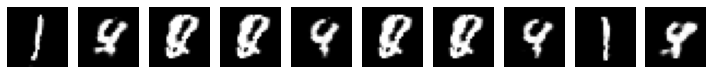

13900 [D loss: 0.012917, acc.: 100.00%] [G loss: 4.703192]
13901 [D loss: 0.052739, acc.: 96.88%] [G loss: 3.271100]
13902 [D loss: 0.079846, acc.: 96.09%] [G loss: 3.307951]
13903 [D loss: 0.050313, acc.: 98.44%] [G loss: 3.577063]
13904 [D loss: 0.101009, acc.: 94.53%] [G loss: 3.518397]
13905 [D loss: 0.071513, acc.: 96.09%] [G loss: 4.243122]
13906 [D loss: 0.042876, acc.: 97.66%] [G loss: 5.406610]
13907 [D loss: 0.031865, acc.: 97.66%] [G loss: 5.985123]
13908 [D loss: 0.031070, acc.: 98.44%] [G loss: 7.033960]
13909 [D loss: 0.062787, acc.: 96.09%] [G loss: 6.834469]
13910 [D loss: 0.052872, acc.: 97.66%] [G loss: 6.349411]
13911 [D loss: 0.045110, acc.: 97.66%] [G loss: 5.497276]
13912 [D loss: 0.034140, acc.: 98.44%] [G loss: 4.236212]
13913 [D loss: 0.047592, acc.: 96.88%] [G loss: 3.196107]
13914 [D loss: 0.027061, acc.: 99.22%] [G loss: 3.091567]
13915 [D loss: 0.120137, acc.: 96.09%] [G loss: 2.654707]
13916 [D loss: 0.083108, acc.: 95.31%] [G loss: 3.571366]
13917 [D loss

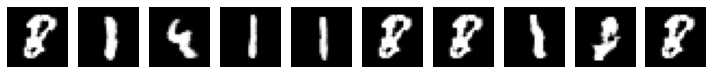

14000 [D loss: 0.026730, acc.: 99.22%] [G loss: 2.992293]
14001 [D loss: 0.024009, acc.: 99.22%] [G loss: 3.619607]
14002 [D loss: 0.034275, acc.: 98.44%] [G loss: 4.526000]
14003 [D loss: 0.102898, acc.: 96.88%] [G loss: 3.274934]
14004 [D loss: 0.077364, acc.: 96.88%] [G loss: 2.033226]
14005 [D loss: 0.049861, acc.: 99.22%] [G loss: 1.912402]
14006 [D loss: 0.150464, acc.: 93.75%] [G loss: 2.166452]
14007 [D loss: 0.057322, acc.: 98.44%] [G loss: 3.241537]
14008 [D loss: 0.023924, acc.: 98.44%] [G loss: 5.319451]
14009 [D loss: 0.032827, acc.: 99.22%] [G loss: 5.952815]
14010 [D loss: 0.076184, acc.: 96.88%] [G loss: 5.596178]
14011 [D loss: 0.091582, acc.: 96.88%] [G loss: 4.041569]
14012 [D loss: 0.041086, acc.: 98.44%] [G loss: 2.432318]
14013 [D loss: 0.049689, acc.: 99.22%] [G loss: 2.489236]
14014 [D loss: 0.064362, acc.: 96.88%] [G loss: 3.453806]
14015 [D loss: 0.038721, acc.: 99.22%] [G loss: 4.653657]
14016 [D loss: 0.036332, acc.: 99.22%] [G loss: 4.875836]
14017 [D loss:

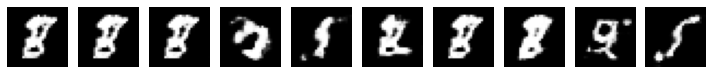

14100 [D loss: 0.125529, acc.: 95.31%] [G loss: 3.744471]
14101 [D loss: 0.144660, acc.: 96.88%] [G loss: 3.199812]
14102 [D loss: 0.038065, acc.: 99.22%] [G loss: 3.903824]
14103 [D loss: 0.069723, acc.: 98.44%] [G loss: 4.493105]
14104 [D loss: 0.070687, acc.: 96.09%] [G loss: 5.438860]
14105 [D loss: 0.038088, acc.: 99.22%] [G loss: 5.810616]
14106 [D loss: 0.022549, acc.: 99.22%] [G loss: 6.609499]
14107 [D loss: 0.010641, acc.: 100.00%] [G loss: 7.249322]
14108 [D loss: 0.098008, acc.: 97.66%] [G loss: 7.024832]
14109 [D loss: 0.082676, acc.: 96.09%] [G loss: 6.911372]
14110 [D loss: 0.014275, acc.: 100.00%] [G loss: 5.997913]
14111 [D loss: 0.078785, acc.: 96.88%] [G loss: 6.170558]
14112 [D loss: 0.136486, acc.: 96.09%] [G loss: 5.359910]
14113 [D loss: 0.072448, acc.: 97.66%] [G loss: 5.154327]
14114 [D loss: 0.063223, acc.: 96.88%] [G loss: 4.759296]
14115 [D loss: 0.077215, acc.: 95.31%] [G loss: 4.783381]
14116 [D loss: 0.040193, acc.: 97.66%] [G loss: 4.791286]
14117 [D los

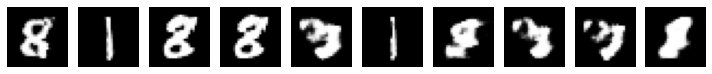

14200 [D loss: 0.051267, acc.: 97.66%] [G loss: 7.273506]
14201 [D loss: 0.045080, acc.: 97.66%] [G loss: 7.395522]
14202 [D loss: 0.069045, acc.: 97.66%] [G loss: 6.997628]
14203 [D loss: 0.014266, acc.: 100.00%] [G loss: 5.942189]
14204 [D loss: 0.030093, acc.: 99.22%] [G loss: 5.121974]
14205 [D loss: 0.043507, acc.: 98.44%] [G loss: 5.107509]
14206 [D loss: 0.028414, acc.: 99.22%] [G loss: 4.583068]
14207 [D loss: 0.035752, acc.: 98.44%] [G loss: 3.991356]
14208 [D loss: 0.090177, acc.: 97.66%] [G loss: 4.267493]
14209 [D loss: 0.054050, acc.: 98.44%] [G loss: 4.537423]
14210 [D loss: 0.026972, acc.: 99.22%] [G loss: 4.247112]
14211 [D loss: 0.063365, acc.: 96.88%] [G loss: 3.669521]
14212 [D loss: 0.061814, acc.: 98.44%] [G loss: 3.194061]
14213 [D loss: 0.075097, acc.: 97.66%] [G loss: 2.463527]
14214 [D loss: 0.037450, acc.: 99.22%] [G loss: 2.745615]
14215 [D loss: 0.063125, acc.: 97.66%] [G loss: 3.918417]
14216 [D loss: 0.060201, acc.: 96.88%] [G loss: 5.248637]
14217 [D loss

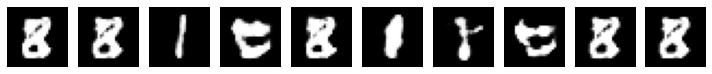

14300 [D loss: 0.021109, acc.: 98.44%] [G loss: 7.597487]
14301 [D loss: 0.053023, acc.: 98.44%] [G loss: 7.201857]
14302 [D loss: 0.054466, acc.: 97.66%] [G loss: 7.243712]
14303 [D loss: 0.027967, acc.: 99.22%] [G loss: 6.407139]
14304 [D loss: 0.102782, acc.: 95.31%] [G loss: 5.322184]
14305 [D loss: 0.079656, acc.: 97.66%] [G loss: 5.070137]
14306 [D loss: 0.029983, acc.: 99.22%] [G loss: 5.014188]
14307 [D loss: 0.075790, acc.: 95.31%] [G loss: 5.695518]
14308 [D loss: 0.060956, acc.: 97.66%] [G loss: 5.934150]
14309 [D loss: 0.028118, acc.: 99.22%] [G loss: 6.292218]
14310 [D loss: 0.040605, acc.: 98.44%] [G loss: 7.552227]
14311 [D loss: 0.048414, acc.: 97.66%] [G loss: 6.613635]
14312 [D loss: 0.031182, acc.: 99.22%] [G loss: 7.005241]
14313 [D loss: 0.048979, acc.: 96.88%] [G loss: 7.181572]
14314 [D loss: 0.100541, acc.: 95.31%] [G loss: 7.539167]
14315 [D loss: 0.050255, acc.: 98.44%] [G loss: 7.143977]
14316 [D loss: 0.050615, acc.: 97.66%] [G loss: 5.842317]
14317 [D loss:

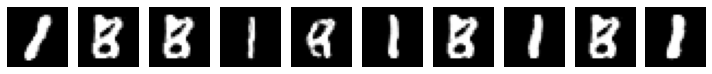

14400 [D loss: 0.022041, acc.: 99.22%] [G loss: 7.229025]
14401 [D loss: 0.040566, acc.: 99.22%] [G loss: 6.837527]
14402 [D loss: 0.017755, acc.: 100.00%] [G loss: 6.970900]
14403 [D loss: 0.048176, acc.: 97.66%] [G loss: 6.306434]
14404 [D loss: 0.031492, acc.: 98.44%] [G loss: 6.600693]
14405 [D loss: 0.022914, acc.: 99.22%] [G loss: 6.692925]
14406 [D loss: 0.026137, acc.: 99.22%] [G loss: 7.104020]
14407 [D loss: 0.048746, acc.: 98.44%] [G loss: 7.381895]
14408 [D loss: 0.058355, acc.: 96.88%] [G loss: 6.329808]
14409 [D loss: 0.102871, acc.: 96.09%] [G loss: 6.172647]
14410 [D loss: 0.096047, acc.: 98.44%] [G loss: 5.466980]
14411 [D loss: 0.058548, acc.: 96.88%] [G loss: 5.591225]
14412 [D loss: 0.019142, acc.: 98.44%] [G loss: 6.212790]
14413 [D loss: 0.024546, acc.: 98.44%] [G loss: 7.671119]
14414 [D loss: 0.061508, acc.: 96.88%] [G loss: 7.183353]
14415 [D loss: 0.057398, acc.: 97.66%] [G loss: 6.777684]
14416 [D loss: 0.153006, acc.: 92.97%] [G loss: 4.099829]
14417 [D loss

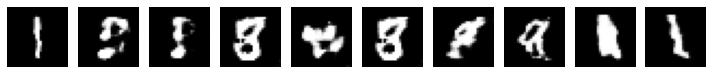

14500 [D loss: 0.093107, acc.: 97.66%] [G loss: 5.372842]
14501 [D loss: 0.065383, acc.: 97.66%] [G loss: 4.714203]
14502 [D loss: 0.025908, acc.: 99.22%] [G loss: 4.719599]
14503 [D loss: 0.057916, acc.: 96.88%] [G loss: 5.966815]
14504 [D loss: 0.036550, acc.: 98.44%] [G loss: 5.729754]
14505 [D loss: 0.034957, acc.: 98.44%] [G loss: 5.440351]
14506 [D loss: 0.037426, acc.: 98.44%] [G loss: 3.926603]
14507 [D loss: 0.034743, acc.: 99.22%] [G loss: 3.182100]
14508 [D loss: 0.062182, acc.: 96.88%] [G loss: 3.074268]
14509 [D loss: 0.022875, acc.: 99.22%] [G loss: 4.403392]
14510 [D loss: 0.042471, acc.: 98.44%] [G loss: 5.245765]
14511 [D loss: 0.092207, acc.: 96.88%] [G loss: 5.243272]
14512 [D loss: 0.045073, acc.: 98.44%] [G loss: 5.393245]
14513 [D loss: 0.023092, acc.: 99.22%] [G loss: 5.669523]
14514 [D loss: 0.069818, acc.: 98.44%] [G loss: 5.331245]
14515 [D loss: 0.067100, acc.: 96.09%] [G loss: 4.622891]
14516 [D loss: 0.047887, acc.: 98.44%] [G loss: 4.543548]
14517 [D loss:

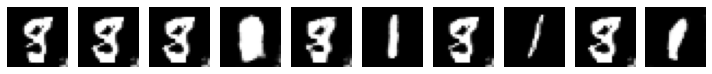

14600 [D loss: 0.061150, acc.: 98.44%] [G loss: 3.267688]
14601 [D loss: 0.033563, acc.: 98.44%] [G loss: 4.521130]
14602 [D loss: 0.072472, acc.: 97.66%] [G loss: 4.967200]
14603 [D loss: 0.064032, acc.: 96.09%] [G loss: 5.772060]
14604 [D loss: 0.037772, acc.: 98.44%] [G loss: 5.542350]
14605 [D loss: 0.038560, acc.: 99.22%] [G loss: 5.052226]
14606 [D loss: 0.025797, acc.: 98.44%] [G loss: 3.995380]
14607 [D loss: 0.023712, acc.: 99.22%] [G loss: 3.675469]
14608 [D loss: 0.027465, acc.: 99.22%] [G loss: 3.186557]
14609 [D loss: 0.067390, acc.: 96.09%] [G loss: 3.246813]
14610 [D loss: 0.084617, acc.: 96.88%] [G loss: 3.355924]
14611 [D loss: 0.100492, acc.: 96.88%] [G loss: 2.901475]
14612 [D loss: 0.050409, acc.: 99.22%] [G loss: 3.102099]
14613 [D loss: 0.026683, acc.: 99.22%] [G loss: 4.522090]
14614 [D loss: 0.050309, acc.: 98.44%] [G loss: 4.659661]
14615 [D loss: 0.079325, acc.: 96.88%] [G loss: 5.465296]
14616 [D loss: 0.104984, acc.: 96.09%] [G loss: 4.244902]
14617 [D loss:

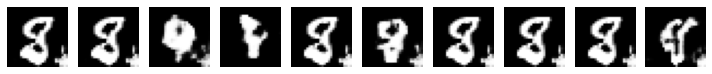

14700 [D loss: 0.031212, acc.: 99.22%] [G loss: 3.878597]
14701 [D loss: 0.016588, acc.: 99.22%] [G loss: 3.421925]
14702 [D loss: 0.014357, acc.: 100.00%] [G loss: 3.911225]
14703 [D loss: 0.063928, acc.: 96.88%] [G loss: 4.179916]
14704 [D loss: 0.019057, acc.: 99.22%] [G loss: 4.397072]
14705 [D loss: 0.032580, acc.: 98.44%] [G loss: 4.499978]
14706 [D loss: 0.019072, acc.: 99.22%] [G loss: 4.744843]
14707 [D loss: 0.043769, acc.: 99.22%] [G loss: 3.947160]
14708 [D loss: 0.039614, acc.: 98.44%] [G loss: 3.263781]
14709 [D loss: 0.047830, acc.: 99.22%] [G loss: 2.508430]
14710 [D loss: 0.026706, acc.: 99.22%] [G loss: 2.740561]
14711 [D loss: 0.004263, acc.: 100.00%] [G loss: 3.683065]
14712 [D loss: 0.011959, acc.: 100.00%] [G loss: 4.058982]
14713 [D loss: 0.024755, acc.: 99.22%] [G loss: 4.436990]
14714 [D loss: 0.016214, acc.: 100.00%] [G loss: 5.269449]
14715 [D loss: 0.034646, acc.: 98.44%] [G loss: 4.713192]
14716 [D loss: 0.054434, acc.: 98.44%] [G loss: 4.499081]
14717 [D l

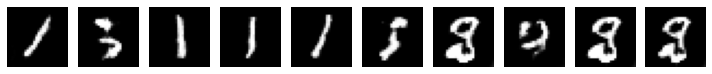

14800 [D loss: 0.047602, acc.: 97.66%] [G loss: 3.933459]
14801 [D loss: 0.024255, acc.: 99.22%] [G loss: 4.991203]
14802 [D loss: 0.048513, acc.: 96.88%] [G loss: 5.647264]
14803 [D loss: 0.046095, acc.: 98.44%] [G loss: 5.371304]
14804 [D loss: 0.074002, acc.: 96.88%] [G loss: 5.394498]
14805 [D loss: 0.004729, acc.: 100.00%] [G loss: 5.759266]
14806 [D loss: 0.177000, acc.: 92.97%] [G loss: 3.214148]
14807 [D loss: 0.100254, acc.: 96.88%] [G loss: 2.919442]
14808 [D loss: 0.078243, acc.: 96.88%] [G loss: 3.821882]
14809 [D loss: 0.055282, acc.: 96.88%] [G loss: 6.047760]
14810 [D loss: 0.023855, acc.: 99.22%] [G loss: 6.945054]
14811 [D loss: 0.065713, acc.: 97.66%] [G loss: 7.637615]
14812 [D loss: 0.020613, acc.: 100.00%] [G loss: 7.415239]
14813 [D loss: 0.054805, acc.: 98.44%] [G loss: 7.636256]
14814 [D loss: 0.031611, acc.: 99.22%] [G loss: 6.947228]
14815 [D loss: 0.103946, acc.: 93.75%] [G loss: 6.346807]
14816 [D loss: 0.015591, acc.: 100.00%] [G loss: 5.532399]
14817 [D lo

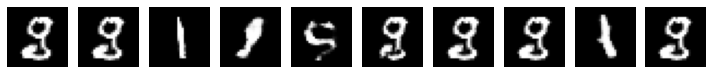

14900 [D loss: 0.024577, acc.: 99.22%] [G loss: 2.602657]
14901 [D loss: 0.006159, acc.: 100.00%] [G loss: 3.309897]
14902 [D loss: 0.021368, acc.: 100.00%] [G loss: 4.412500]
14903 [D loss: 0.028116, acc.: 98.44%] [G loss: 4.729552]
14904 [D loss: 0.063806, acc.: 98.44%] [G loss: 4.473499]
14905 [D loss: 0.057609, acc.: 97.66%] [G loss: 4.807779]
14906 [D loss: 0.007171, acc.: 100.00%] [G loss: 5.015869]
14907 [D loss: 0.030870, acc.: 99.22%] [G loss: 5.438156]
14908 [D loss: 0.030796, acc.: 98.44%] [G loss: 5.756108]
14909 [D loss: 0.022756, acc.: 99.22%] [G loss: 5.139970]
14910 [D loss: 0.040040, acc.: 99.22%] [G loss: 5.358120]
14911 [D loss: 0.039296, acc.: 99.22%] [G loss: 4.749576]
14912 [D loss: 0.052694, acc.: 98.44%] [G loss: 4.614781]
14913 [D loss: 0.010085, acc.: 100.00%] [G loss: 4.947113]
14914 [D loss: 0.002620, acc.: 100.00%] [G loss: 5.394742]
14915 [D loss: 0.075011, acc.: 97.66%] [G loss: 4.963382]
14916 [D loss: 0.044136, acc.: 97.66%] [G loss: 3.746962]
14917 [D 

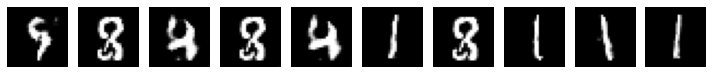

15000 [D loss: 0.072483, acc.: 97.66%] [G loss: 3.896763]
15001 [D loss: 0.025692, acc.: 99.22%] [G loss: 3.470607]
15002 [D loss: 0.106364, acc.: 96.09%] [G loss: 3.641161]
15003 [D loss: 0.056547, acc.: 96.88%] [G loss: 4.591834]
15004 [D loss: 0.049417, acc.: 98.44%] [G loss: 5.613396]
15005 [D loss: 0.027818, acc.: 100.00%] [G loss: 6.076865]
15006 [D loss: 0.007960, acc.: 100.00%] [G loss: 5.760639]
15007 [D loss: 0.043539, acc.: 98.44%] [G loss: 6.115472]
15008 [D loss: 0.023698, acc.: 99.22%] [G loss: 5.579166]
15009 [D loss: 0.026883, acc.: 99.22%] [G loss: 5.939705]
15010 [D loss: 0.040089, acc.: 98.44%] [G loss: 4.647029]
15011 [D loss: 0.027316, acc.: 98.44%] [G loss: 4.829252]
15012 [D loss: 0.077158, acc.: 96.09%] [G loss: 4.080722]
15013 [D loss: 0.105338, acc.: 96.09%] [G loss: 3.450714]
15014 [D loss: 0.018904, acc.: 99.22%] [G loss: 3.270743]
15015 [D loss: 0.008606, acc.: 100.00%] [G loss: 4.665419]
15016 [D loss: 0.050903, acc.: 97.66%] [G loss: 5.178960]
15017 [D lo

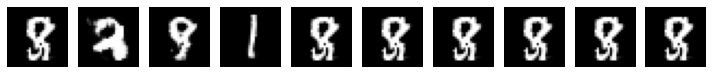

15100 [D loss: 0.038330, acc.: 97.66%] [G loss: 2.664830]
15101 [D loss: 0.066907, acc.: 98.44%] [G loss: 2.823951]
15102 [D loss: 0.057087, acc.: 97.66%] [G loss: 3.487819]
15103 [D loss: 0.055943, acc.: 98.44%] [G loss: 3.942878]
15104 [D loss: 0.024359, acc.: 99.22%] [G loss: 3.532516]
15105 [D loss: 0.104022, acc.: 96.09%] [G loss: 2.382639]
15106 [D loss: 0.063692, acc.: 96.88%] [G loss: 2.658024]
15107 [D loss: 0.019450, acc.: 100.00%] [G loss: 2.354080]
15108 [D loss: 0.008356, acc.: 100.00%] [G loss: 3.370808]
15109 [D loss: 0.076677, acc.: 97.66%] [G loss: 3.470134]
15110 [D loss: 0.052730, acc.: 97.66%] [G loss: 3.648641]
15111 [D loss: 0.042751, acc.: 97.66%] [G loss: 3.317811]
15112 [D loss: 0.122261, acc.: 95.31%] [G loss: 3.272716]
15113 [D loss: 0.051330, acc.: 97.66%] [G loss: 4.731265]
15114 [D loss: 0.115251, acc.: 96.88%] [G loss: 4.529076]
15115 [D loss: 0.079906, acc.: 96.88%] [G loss: 4.154852]
15116 [D loss: 0.014429, acc.: 99.22%] [G loss: 3.441284]
15117 [D los

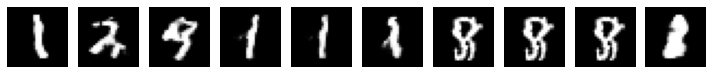

15200 [D loss: 0.030051, acc.: 98.44%] [G loss: 6.370104]
15201 [D loss: 0.039993, acc.: 99.22%] [G loss: 6.724932]
15202 [D loss: 0.058583, acc.: 98.44%] [G loss: 7.031118]
15203 [D loss: 0.090595, acc.: 97.66%] [G loss: 6.668382]
15204 [D loss: 0.095320, acc.: 96.88%] [G loss: 6.135423]
15205 [D loss: 0.035189, acc.: 98.44%] [G loss: 5.628594]
15206 [D loss: 0.038037, acc.: 98.44%] [G loss: 5.382740]
15207 [D loss: 0.033435, acc.: 97.66%] [G loss: 5.291917]
15208 [D loss: 0.031283, acc.: 99.22%] [G loss: 5.331876]
15209 [D loss: 0.018007, acc.: 100.00%] [G loss: 5.957248]
15210 [D loss: 0.028429, acc.: 98.44%] [G loss: 6.042967]
15211 [D loss: 0.065061, acc.: 97.66%] [G loss: 5.358811]
15212 [D loss: 0.056610, acc.: 98.44%] [G loss: 5.276587]
15213 [D loss: 0.016323, acc.: 100.00%] [G loss: 5.072505]
15214 [D loss: 0.026648, acc.: 99.22%] [G loss: 5.528150]
15215 [D loss: 0.027715, acc.: 98.44%] [G loss: 6.650264]
15216 [D loss: 0.009905, acc.: 100.00%] [G loss: 7.631043]
15217 [D lo

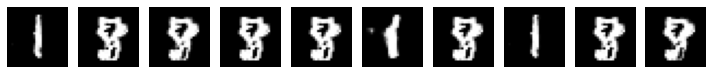

15300 [D loss: 0.020289, acc.: 99.22%] [G loss: 4.723839]
15301 [D loss: 0.038242, acc.: 98.44%] [G loss: 5.021578]
15302 [D loss: 0.014530, acc.: 99.22%] [G loss: 5.058530]
15303 [D loss: 0.017899, acc.: 99.22%] [G loss: 5.105535]
15304 [D loss: 0.023212, acc.: 100.00%] [G loss: 4.497028]
15305 [D loss: 0.040193, acc.: 96.88%] [G loss: 4.617738]
15306 [D loss: 0.032029, acc.: 98.44%] [G loss: 4.474697]
15307 [D loss: 0.038307, acc.: 99.22%] [G loss: 5.277488]
15308 [D loss: 0.055524, acc.: 98.44%] [G loss: 6.294875]
15309 [D loss: 0.028964, acc.: 98.44%] [G loss: 7.348943]
15310 [D loss: 0.014017, acc.: 99.22%] [G loss: 7.112249]
15311 [D loss: 0.018501, acc.: 99.22%] [G loss: 6.131881]
15312 [D loss: 0.016158, acc.: 99.22%] [G loss: 5.698087]
15313 [D loss: 0.027619, acc.: 98.44%] [G loss: 4.653775]
15314 [D loss: 0.045577, acc.: 99.22%] [G loss: 4.351169]
15315 [D loss: 0.050280, acc.: 97.66%] [G loss: 5.134154]
15316 [D loss: 0.007538, acc.: 100.00%] [G loss: 6.272899]
15317 [D los

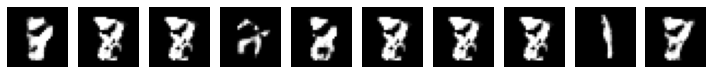

15400 [D loss: 0.043110, acc.: 98.44%] [G loss: 3.166371]
15401 [D loss: 0.051588, acc.: 98.44%] [G loss: 3.349657]
15402 [D loss: 0.074120, acc.: 96.09%] [G loss: 5.179953]
15403 [D loss: 0.026261, acc.: 98.44%] [G loss: 6.366812]
15404 [D loss: 0.123156, acc.: 96.09%] [G loss: 5.723884]
15405 [D loss: 0.088335, acc.: 96.88%] [G loss: 6.153835]
15406 [D loss: 0.032288, acc.: 99.22%] [G loss: 4.933242]
15407 [D loss: 0.055216, acc.: 97.66%] [G loss: 4.150561]
15408 [D loss: 0.039401, acc.: 98.44%] [G loss: 3.303734]
15409 [D loss: 0.043377, acc.: 98.44%] [G loss: 3.166050]
15410 [D loss: 0.047451, acc.: 98.44%] [G loss: 3.756423]
15411 [D loss: 0.057709, acc.: 98.44%] [G loss: 4.458734]
15412 [D loss: 0.005297, acc.: 100.00%] [G loss: 5.447435]
15413 [D loss: 0.019556, acc.: 99.22%] [G loss: 6.341474]
15414 [D loss: 0.094632, acc.: 97.66%] [G loss: 6.117156]
15415 [D loss: 0.022660, acc.: 99.22%] [G loss: 5.733701]
15416 [D loss: 0.061452, acc.: 96.88%] [G loss: 5.361595]
15417 [D loss

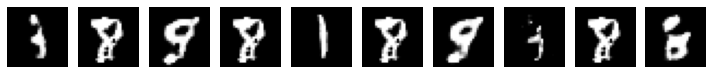

15500 [D loss: 0.007410, acc.: 100.00%] [G loss: 6.558552]
15501 [D loss: 0.070419, acc.: 96.88%] [G loss: 6.289748]
15502 [D loss: 0.041151, acc.: 99.22%] [G loss: 6.792971]
15503 [D loss: 0.031033, acc.: 98.44%] [G loss: 6.512725]
15504 [D loss: 0.020907, acc.: 99.22%] [G loss: 6.471378]
15505 [D loss: 0.038465, acc.: 98.44%] [G loss: 6.136504]
15506 [D loss: 0.024033, acc.: 99.22%] [G loss: 5.380296]
15507 [D loss: 0.016453, acc.: 99.22%] [G loss: 4.725683]
15508 [D loss: 0.102474, acc.: 96.09%] [G loss: 4.999844]
15509 [D loss: 0.074720, acc.: 96.88%] [G loss: 4.968946]
15510 [D loss: 0.014052, acc.: 99.22%] [G loss: 5.396256]
15511 [D loss: 0.048085, acc.: 99.22%] [G loss: 5.654895]
15512 [D loss: 0.096774, acc.: 96.88%] [G loss: 6.393630]
15513 [D loss: 0.013165, acc.: 100.00%] [G loss: 7.444387]
15514 [D loss: 0.027510, acc.: 98.44%] [G loss: 7.104245]
15515 [D loss: 0.118655, acc.: 96.09%] [G loss: 5.803599]
15516 [D loss: 0.086537, acc.: 97.66%] [G loss: 3.818385]
15517 [D los

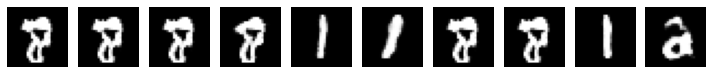

15600 [D loss: 0.064194, acc.: 96.09%] [G loss: 5.975956]
15601 [D loss: 0.036785, acc.: 99.22%] [G loss: 6.893474]
15602 [D loss: 0.027766, acc.: 99.22%] [G loss: 7.429054]
15603 [D loss: 0.092923, acc.: 96.09%] [G loss: 6.787205]
15604 [D loss: 0.052802, acc.: 98.44%] [G loss: 6.097537]
15605 [D loss: 0.011777, acc.: 100.00%] [G loss: 5.397473]
15606 [D loss: 0.038511, acc.: 99.22%] [G loss: 5.275375]
15607 [D loss: 0.056918, acc.: 97.66%] [G loss: 5.847654]
15608 [D loss: 0.027176, acc.: 98.44%] [G loss: 5.984388]
15609 [D loss: 0.057935, acc.: 99.22%] [G loss: 5.741533]
15610 [D loss: 0.042349, acc.: 96.88%] [G loss: 4.958903]
15611 [D loss: 0.062792, acc.: 96.88%] [G loss: 4.323973]
15612 [D loss: 0.042140, acc.: 98.44%] [G loss: 4.860518]
15613 [D loss: 0.010898, acc.: 100.00%] [G loss: 4.904813]
15614 [D loss: 0.033665, acc.: 96.88%] [G loss: 5.207070]
15615 [D loss: 0.062218, acc.: 98.44%] [G loss: 4.670071]
15616 [D loss: 0.071673, acc.: 98.44%] [G loss: 3.499023]
15617 [D los

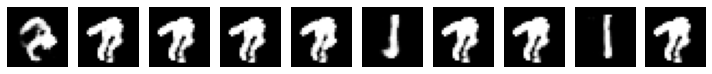

15700 [D loss: 0.054991, acc.: 96.88%] [G loss: 3.932693]
15701 [D loss: 0.008236, acc.: 100.00%] [G loss: 4.777050]
15702 [D loss: 0.016284, acc.: 99.22%] [G loss: 5.632186]
15703 [D loss: 0.056849, acc.: 96.88%] [G loss: 4.907964]
15704 [D loss: 0.015053, acc.: 100.00%] [G loss: 4.944805]
15705 [D loss: 0.068219, acc.: 97.66%] [G loss: 4.165000]
15706 [D loss: 0.043411, acc.: 98.44%] [G loss: 3.405356]
15707 [D loss: 0.066531, acc.: 96.09%] [G loss: 3.444695]
15708 [D loss: 0.056333, acc.: 97.66%] [G loss: 3.592366]
15709 [D loss: 0.077894, acc.: 96.88%] [G loss: 3.671472]
15710 [D loss: 0.017679, acc.: 99.22%] [G loss: 3.756932]
15711 [D loss: 0.008459, acc.: 100.00%] [G loss: 3.906868]
15712 [D loss: 0.089644, acc.: 97.66%] [G loss: 3.241790]
15713 [D loss: 0.023833, acc.: 99.22%] [G loss: 4.431057]
15714 [D loss: 0.053127, acc.: 98.44%] [G loss: 4.481942]
15715 [D loss: 0.010890, acc.: 100.00%] [G loss: 4.564211]
15716 [D loss: 0.012889, acc.: 99.22%] [G loss: 4.167809]
15717 [D l

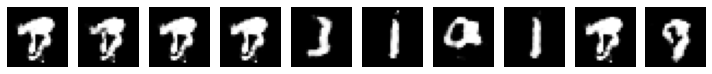

15800 [D loss: 0.036382, acc.: 98.44%] [G loss: 6.185531]
15801 [D loss: 0.013666, acc.: 99.22%] [G loss: 7.089296]
15802 [D loss: 0.058557, acc.: 98.44%] [G loss: 7.357670]
15803 [D loss: 0.101671, acc.: 97.66%] [G loss: 7.060393]
15804 [D loss: 0.090851, acc.: 98.44%] [G loss: 6.174662]
15805 [D loss: 0.033591, acc.: 99.22%] [G loss: 6.115795]
15806 [D loss: 0.016653, acc.: 99.22%] [G loss: 6.605234]
15807 [D loss: 0.010265, acc.: 99.22%] [G loss: 5.728808]
15808 [D loss: 0.026765, acc.: 99.22%] [G loss: 5.641546]
15809 [D loss: 0.040629, acc.: 97.66%] [G loss: 4.802248]
15810 [D loss: 0.049249, acc.: 97.66%] [G loss: 5.128757]
15811 [D loss: 0.091526, acc.: 95.31%] [G loss: 4.741543]
15812 [D loss: 0.019807, acc.: 100.00%] [G loss: 4.778423]
15813 [D loss: 0.021986, acc.: 98.44%] [G loss: 6.136278]
15814 [D loss: 0.053837, acc.: 99.22%] [G loss: 6.992567]
15815 [D loss: 0.013932, acc.: 99.22%] [G loss: 7.076431]
15816 [D loss: 0.010073, acc.: 100.00%] [G loss: 6.991450]
15817 [D los

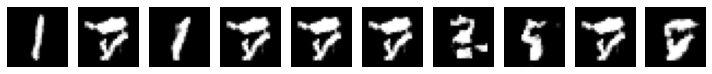

15900 [D loss: 0.070777, acc.: 97.66%] [G loss: 2.904459]
15901 [D loss: 0.007799, acc.: 100.00%] [G loss: 6.145366]
15902 [D loss: 0.038209, acc.: 99.22%] [G loss: 6.427420]
15903 [D loss: 0.058889, acc.: 97.66%] [G loss: 6.026858]
15904 [D loss: 0.021129, acc.: 99.22%] [G loss: 4.873189]
15905 [D loss: 0.058044, acc.: 97.66%] [G loss: 3.324427]
15906 [D loss: 0.073702, acc.: 98.44%] [G loss: 2.918003]
15907 [D loss: 0.022319, acc.: 99.22%] [G loss: 2.402171]
15908 [D loss: 0.083451, acc.: 98.44%] [G loss: 2.975595]
15909 [D loss: 0.003754, acc.: 100.00%] [G loss: 4.954798]
15910 [D loss: 0.040203, acc.: 99.22%] [G loss: 5.923892]
15911 [D loss: 0.024002, acc.: 98.44%] [G loss: 6.270523]
15912 [D loss: 0.060530, acc.: 98.44%] [G loss: 5.753371]
15913 [D loss: 0.023891, acc.: 97.66%] [G loss: 4.319589]
15914 [D loss: 0.013114, acc.: 99.22%] [G loss: 3.804750]
15915 [D loss: 0.082644, acc.: 97.66%] [G loss: 2.687719]
15916 [D loss: 0.035038, acc.: 98.44%] [G loss: 2.314523]
15917 [D los

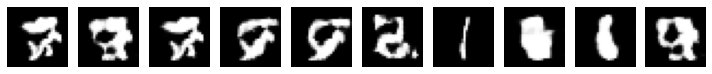

16000 [D loss: 0.022001, acc.: 99.22%] [G loss: 6.149192]
16001 [D loss: 0.027025, acc.: 99.22%] [G loss: 6.347064]
16002 [D loss: 0.054771, acc.: 99.22%] [G loss: 7.252910]
16003 [D loss: 0.009961, acc.: 100.00%] [G loss: 8.380594]
16004 [D loss: 0.012404, acc.: 100.00%] [G loss: 9.454128]
16005 [D loss: 0.019760, acc.: 99.22%] [G loss: 9.274772]
16006 [D loss: 0.019476, acc.: 99.22%] [G loss: 9.671113]
16007 [D loss: 0.037083, acc.: 99.22%] [G loss: 8.558790]
16008 [D loss: 0.018845, acc.: 99.22%] [G loss: 7.934127]
16009 [D loss: 0.013147, acc.: 99.22%] [G loss: 7.245325]
16010 [D loss: 0.018045, acc.: 99.22%] [G loss: 6.562389]
16011 [D loss: 0.056588, acc.: 96.88%] [G loss: 6.949020]
16012 [D loss: 0.075047, acc.: 96.88%] [G loss: 6.316925]
16013 [D loss: 0.012207, acc.: 100.00%] [G loss: 6.670234]
16014 [D loss: 0.023450, acc.: 99.22%] [G loss: 6.714109]
16015 [D loss: 0.021708, acc.: 99.22%] [G loss: 6.266034]
16016 [D loss: 0.010060, acc.: 100.00%] [G loss: 6.501326]
16017 [D l

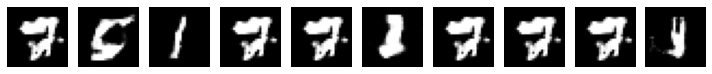

16100 [D loss: 0.100532, acc.: 95.31%] [G loss: 9.583888]
16101 [D loss: 0.098665, acc.: 96.09%] [G loss: 6.750101]
16102 [D loss: 0.052341, acc.: 98.44%] [G loss: 3.803251]
16103 [D loss: 0.085804, acc.: 96.88%] [G loss: 2.910240]
16104 [D loss: 0.055246, acc.: 96.88%] [G loss: 4.508894]
16105 [D loss: 0.014363, acc.: 100.00%] [G loss: 7.598365]
16106 [D loss: 0.049699, acc.: 98.44%] [G loss: 8.225431]
16107 [D loss: 0.024403, acc.: 99.22%] [G loss: 8.328001]
16108 [D loss: 0.064427, acc.: 97.66%] [G loss: 7.901515]
16109 [D loss: 0.059401, acc.: 98.44%] [G loss: 6.493824]
16110 [D loss: 0.076625, acc.: 96.09%] [G loss: 5.669024]
16111 [D loss: 0.051460, acc.: 97.66%] [G loss: 6.375896]
16112 [D loss: 0.057137, acc.: 99.22%] [G loss: 6.127742]
16113 [D loss: 0.024954, acc.: 99.22%] [G loss: 7.104077]
16114 [D loss: 0.074781, acc.: 96.88%] [G loss: 7.301185]
16115 [D loss: 0.056760, acc.: 97.66%] [G loss: 6.035539]
16116 [D loss: 0.052125, acc.: 98.44%] [G loss: 5.281232]
16117 [D loss

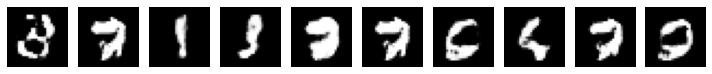

16200 [D loss: 0.021525, acc.: 99.22%] [G loss: 6.888066]
16201 [D loss: 0.067242, acc.: 98.44%] [G loss: 5.985538]
16202 [D loss: 0.045945, acc.: 97.66%] [G loss: 4.406055]
16203 [D loss: 0.006863, acc.: 100.00%] [G loss: 3.569586]
16204 [D loss: 0.046743, acc.: 99.22%] [G loss: 3.952997]
16205 [D loss: 0.038982, acc.: 99.22%] [G loss: 4.946225]
16206 [D loss: 0.012286, acc.: 100.00%] [G loss: 5.833634]
16207 [D loss: 0.041896, acc.: 97.66%] [G loss: 6.507444]
16208 [D loss: 0.050735, acc.: 97.66%] [G loss: 7.357820]
16209 [D loss: 0.028683, acc.: 98.44%] [G loss: 6.989147]
16210 [D loss: 0.011427, acc.: 100.00%] [G loss: 7.185471]
16211 [D loss: 0.029442, acc.: 98.44%] [G loss: 6.887468]
16212 [D loss: 0.068592, acc.: 98.44%] [G loss: 6.237013]
16213 [D loss: 0.062360, acc.: 96.88%] [G loss: 5.726490]
16214 [D loss: 0.015392, acc.: 100.00%] [G loss: 5.741999]
16215 [D loss: 0.065264, acc.: 97.66%] [G loss: 6.834568]
16216 [D loss: 0.037599, acc.: 98.44%] [G loss: 7.048166]
16217 [D l

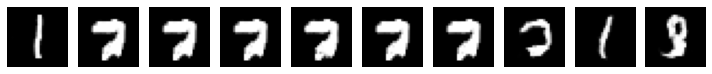

16300 [D loss: 0.015719, acc.: 100.00%] [G loss: 6.226628]
16301 [D loss: 0.058289, acc.: 98.44%] [G loss: 6.502871]
16302 [D loss: 0.034883, acc.: 98.44%] [G loss: 6.476540]
16303 [D loss: 0.011799, acc.: 99.22%] [G loss: 8.062102]
16304 [D loss: 0.040368, acc.: 98.44%] [G loss: 7.214867]
16305 [D loss: 0.062351, acc.: 97.66%] [G loss: 6.393302]
16306 [D loss: 0.030570, acc.: 97.66%] [G loss: 6.199217]
16307 [D loss: 0.069922, acc.: 96.88%] [G loss: 5.667191]
16308 [D loss: 0.028767, acc.: 97.66%] [G loss: 5.859612]
16309 [D loss: 0.021987, acc.: 99.22%] [G loss: 6.660972]
16310 [D loss: 0.014989, acc.: 100.00%] [G loss: 7.193693]
16311 [D loss: 0.093227, acc.: 96.09%] [G loss: 5.955909]
16312 [D loss: 0.019585, acc.: 100.00%] [G loss: 4.704163]
16313 [D loss: 0.048803, acc.: 99.22%] [G loss: 4.035470]
16314 [D loss: 0.090049, acc.: 96.09%] [G loss: 3.887488]
16315 [D loss: 0.016697, acc.: 99.22%] [G loss: 4.740090]
16316 [D loss: 0.110786, acc.: 96.88%] [G loss: 4.658005]
16317 [D lo

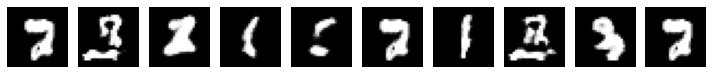

16400 [D loss: 0.191496, acc.: 93.75%] [G loss: 5.075286]
16401 [D loss: 0.014608, acc.: 100.00%] [G loss: 4.382049]
16402 [D loss: 0.019207, acc.: 100.00%] [G loss: 4.175947]
16403 [D loss: 0.014426, acc.: 100.00%] [G loss: 4.738153]
16404 [D loss: 0.027422, acc.: 99.22%] [G loss: 5.920166]
16405 [D loss: 0.074781, acc.: 96.88%] [G loss: 5.305385]
16406 [D loss: 0.038879, acc.: 97.66%] [G loss: 5.910372]
16407 [D loss: 0.007830, acc.: 100.00%] [G loss: 7.137111]
16408 [D loss: 0.051092, acc.: 97.66%] [G loss: 6.392613]
16409 [D loss: 0.081509, acc.: 97.66%] [G loss: 5.723327]
16410 [D loss: 0.036733, acc.: 97.66%] [G loss: 5.551214]
16411 [D loss: 0.009462, acc.: 100.00%] [G loss: 6.054345]
16412 [D loss: 0.032481, acc.: 99.22%] [G loss: 6.271239]
16413 [D loss: 0.016938, acc.: 99.22%] [G loss: 7.595639]
16414 [D loss: 0.013126, acc.: 99.22%] [G loss: 8.565241]
16415 [D loss: 0.033863, acc.: 99.22%] [G loss: 7.206851]
16416 [D loss: 0.053616, acc.: 98.44%] [G loss: 7.860023]
16417 [D 

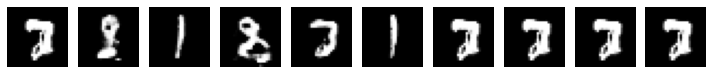

16500 [D loss: 0.028255, acc.: 99.22%] [G loss: 4.144305]
16501 [D loss: 0.004106, acc.: 100.00%] [G loss: 4.111170]
16502 [D loss: 0.013709, acc.: 100.00%] [G loss: 3.419813]
16503 [D loss: 0.021930, acc.: 99.22%] [G loss: 3.512769]
16504 [D loss: 0.041063, acc.: 96.88%] [G loss: 4.539810]
16505 [D loss: 0.030376, acc.: 97.66%] [G loss: 4.632501]
16506 [D loss: 0.048373, acc.: 97.66%] [G loss: 4.796559]
16507 [D loss: 0.029097, acc.: 99.22%] [G loss: 5.133212]
16508 [D loss: 0.028031, acc.: 98.44%] [G loss: 4.617801]
16509 [D loss: 0.014767, acc.: 100.00%] [G loss: 4.251556]
16510 [D loss: 0.011749, acc.: 100.00%] [G loss: 4.732723]
16511 [D loss: 0.062688, acc.: 98.44%] [G loss: 4.034768]
16512 [D loss: 0.041142, acc.: 98.44%] [G loss: 3.507059]
16513 [D loss: 0.011155, acc.: 100.00%] [G loss: 3.126990]
16514 [D loss: 0.021694, acc.: 99.22%] [G loss: 2.565862]
16515 [D loss: 0.020273, acc.: 99.22%] [G loss: 2.745274]
16516 [D loss: 0.017980, acc.: 100.00%] [G loss: 2.617120]
16517 [D

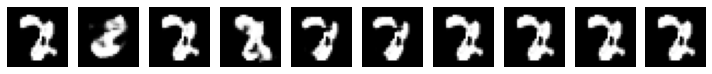

16600 [D loss: 0.004695, acc.: 100.00%] [G loss: 7.062903]
16601 [D loss: 0.014315, acc.: 99.22%] [G loss: 8.802624]
16602 [D loss: 0.016286, acc.: 99.22%] [G loss: 8.496398]
16603 [D loss: 0.004806, acc.: 100.00%] [G loss: 9.540266]
16604 [D loss: 0.103479, acc.: 98.44%] [G loss: 8.990118]
16605 [D loss: 0.014034, acc.: 99.22%] [G loss: 8.549085]
16606 [D loss: 0.021694, acc.: 99.22%] [G loss: 7.625406]
16607 [D loss: 0.058141, acc.: 99.22%] [G loss: 7.916140]
16608 [D loss: 0.038290, acc.: 98.44%] [G loss: 7.199428]
16609 [D loss: 0.016978, acc.: 99.22%] [G loss: 8.453062]
16610 [D loss: 0.021794, acc.: 99.22%] [G loss: 9.962052]
16611 [D loss: 0.105391, acc.: 97.66%] [G loss: 9.422956]
16612 [D loss: 0.014164, acc.: 99.22%] [G loss: 8.531328]
16613 [D loss: 0.003313, acc.: 100.00%] [G loss: 8.164247]
16614 [D loss: 0.048125, acc.: 98.44%] [G loss: 7.182198]
16615 [D loss: 0.036472, acc.: 98.44%] [G loss: 7.417483]
16616 [D loss: 0.009410, acc.: 100.00%] [G loss: 7.998880]
16617 [D l

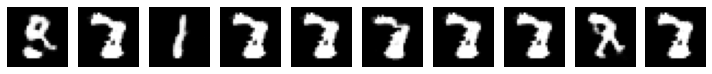

16700 [D loss: 0.027036, acc.: 98.44%] [G loss: 6.454150]
16701 [D loss: 0.015049, acc.: 100.00%] [G loss: 6.468386]
16702 [D loss: 0.036452, acc.: 98.44%] [G loss: 6.457792]
16703 [D loss: 0.013780, acc.: 99.22%] [G loss: 6.007382]
16704 [D loss: 0.016704, acc.: 100.00%] [G loss: 5.706412]
16705 [D loss: 0.031465, acc.: 99.22%] [G loss: 5.266480]
16706 [D loss: 0.007078, acc.: 100.00%] [G loss: 4.718522]
16707 [D loss: 0.018225, acc.: 99.22%] [G loss: 4.239022]
16708 [D loss: 0.018950, acc.: 98.44%] [G loss: 4.303180]
16709 [D loss: 0.045970, acc.: 99.22%] [G loss: 4.428351]
16710 [D loss: 0.016116, acc.: 99.22%] [G loss: 5.554668]
16711 [D loss: 0.045283, acc.: 98.44%] [G loss: 5.659113]
16712 [D loss: 0.004658, acc.: 100.00%] [G loss: 5.325657]
16713 [D loss: 0.004124, acc.: 100.00%] [G loss: 5.408025]
16714 [D loss: 0.074849, acc.: 99.22%] [G loss: 5.534904]
16715 [D loss: 0.036582, acc.: 97.66%] [G loss: 5.429154]
16716 [D loss: 0.031025, acc.: 98.44%] [G loss: 5.092239]
16717 [D 

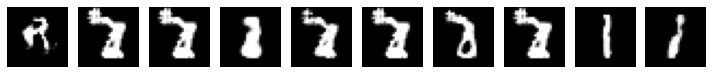

16800 [D loss: 0.036040, acc.: 99.22%] [G loss: 4.800464]
16801 [D loss: 0.033726, acc.: 99.22%] [G loss: 5.403623]
16802 [D loss: 0.020381, acc.: 99.22%] [G loss: 5.781188]
16803 [D loss: 0.008259, acc.: 100.00%] [G loss: 5.852139]
16804 [D loss: 0.014744, acc.: 99.22%] [G loss: 6.086947]
16805 [D loss: 0.058927, acc.: 96.88%] [G loss: 5.695144]
16806 [D loss: 0.034205, acc.: 99.22%] [G loss: 5.511610]
16807 [D loss: 0.017530, acc.: 100.00%] [G loss: 6.387596]
16808 [D loss: 0.032291, acc.: 98.44%] [G loss: 6.220028]
16809 [D loss: 0.030445, acc.: 98.44%] [G loss: 7.428786]
16810 [D loss: 0.004512, acc.: 100.00%] [G loss: 7.732215]
16811 [D loss: 0.020991, acc.: 98.44%] [G loss: 7.937496]
16812 [D loss: 0.026027, acc.: 97.66%] [G loss: 6.792567]
16813 [D loss: 0.013241, acc.: 99.22%] [G loss: 6.673528]
16814 [D loss: 0.033886, acc.: 98.44%] [G loss: 5.492426]
16815 [D loss: 0.049956, acc.: 97.66%] [G loss: 5.085926]
16816 [D loss: 0.008854, acc.: 100.00%] [G loss: 5.160508]
16817 [D l

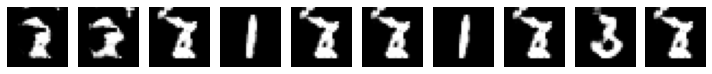

16900 [D loss: 0.002985, acc.: 100.00%] [G loss: 7.423691]
16901 [D loss: 0.034968, acc.: 99.22%] [G loss: 8.087231]
16902 [D loss: 0.059979, acc.: 99.22%] [G loss: 8.127504]
16903 [D loss: 0.059041, acc.: 97.66%] [G loss: 7.833223]
16904 [D loss: 0.002029, acc.: 100.00%] [G loss: 7.688597]
16905 [D loss: 0.057785, acc.: 98.44%] [G loss: 7.090611]
16906 [D loss: 0.034519, acc.: 99.22%] [G loss: 6.498542]
16907 [D loss: 0.059229, acc.: 97.66%] [G loss: 5.867175]
16908 [D loss: 0.048452, acc.: 98.44%] [G loss: 5.413543]
16909 [D loss: 0.017057, acc.: 100.00%] [G loss: 5.171251]
16910 [D loss: 0.094181, acc.: 96.88%] [G loss: 4.632103]
16911 [D loss: 0.049480, acc.: 96.88%] [G loss: 4.601806]
16912 [D loss: 0.018637, acc.: 100.00%] [G loss: 5.239610]
16913 [D loss: 0.042373, acc.: 96.88%] [G loss: 5.407184]
16914 [D loss: 0.010773, acc.: 100.00%] [G loss: 5.341058]
16915 [D loss: 0.020935, acc.: 99.22%] [G loss: 5.477997]
16916 [D loss: 0.026806, acc.: 99.22%] [G loss: 5.233528]
16917 [D 

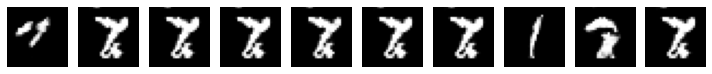

17000 [D loss: 0.034415, acc.: 99.22%] [G loss: 6.193926]
17001 [D loss: 0.031188, acc.: 98.44%] [G loss: 6.543189]
17002 [D loss: 0.078984, acc.: 97.66%] [G loss: 6.652286]
17003 [D loss: 0.028726, acc.: 99.22%] [G loss: 5.770872]
17004 [D loss: 0.045100, acc.: 98.44%] [G loss: 4.876371]
17005 [D loss: 0.092832, acc.: 95.31%] [G loss: 3.205632]
17006 [D loss: 0.100812, acc.: 96.88%] [G loss: 3.148685]
17007 [D loss: 0.028940, acc.: 99.22%] [G loss: 5.211053]
17008 [D loss: 0.025647, acc.: 98.44%] [G loss: 7.821201]
17009 [D loss: 0.018655, acc.: 98.44%] [G loss: 8.735800]
17010 [D loss: 0.163582, acc.: 95.31%] [G loss: 7.745486]
17011 [D loss: 0.019246, acc.: 99.22%] [G loss: 6.827971]
17012 [D loss: 0.007840, acc.: 100.00%] [G loss: 5.960695]
17013 [D loss: 0.030507, acc.: 99.22%] [G loss: 5.796984]
17014 [D loss: 0.090170, acc.: 97.66%] [G loss: 5.821595]
17015 [D loss: 0.026070, acc.: 99.22%] [G loss: 6.958601]
17016 [D loss: 0.013892, acc.: 99.22%] [G loss: 7.386068]
17017 [D loss

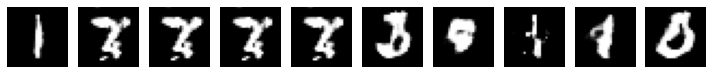

17100 [D loss: 0.027260, acc.: 99.22%] [G loss: 4.832469]
17101 [D loss: 0.019688, acc.: 99.22%] [G loss: 5.594581]
17102 [D loss: 0.021037, acc.: 99.22%] [G loss: 5.851900]
17103 [D loss: 0.011031, acc.: 100.00%] [G loss: 5.859247]
17104 [D loss: 0.033360, acc.: 98.44%] [G loss: 5.086729]
17105 [D loss: 0.001967, acc.: 100.00%] [G loss: 4.533179]
17106 [D loss: 0.024727, acc.: 98.44%] [G loss: 4.039346]
17107 [D loss: 0.050536, acc.: 98.44%] [G loss: 3.189055]
17108 [D loss: 0.023965, acc.: 99.22%] [G loss: 3.655926]
17109 [D loss: 0.036743, acc.: 99.22%] [G loss: 5.154815]
17110 [D loss: 0.012043, acc.: 99.22%] [G loss: 5.947653]
17111 [D loss: 0.043087, acc.: 97.66%] [G loss: 6.335515]
17112 [D loss: 0.016359, acc.: 99.22%] [G loss: 6.138648]
17113 [D loss: 0.011215, acc.: 99.22%] [G loss: 5.466364]
17114 [D loss: 0.049970, acc.: 99.22%] [G loss: 5.098125]
17115 [D loss: 0.075553, acc.: 95.31%] [G loss: 5.303533]
17116 [D loss: 0.043101, acc.: 97.66%] [G loss: 5.518971]
17117 [D los

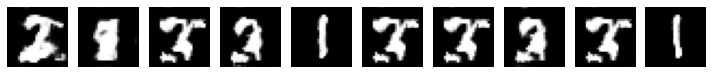

17200 [D loss: 0.043191, acc.: 98.44%] [G loss: 4.362377]
17201 [D loss: 0.049318, acc.: 97.66%] [G loss: 4.853022]
17202 [D loss: 0.016849, acc.: 99.22%] [G loss: 4.727356]
17203 [D loss: 0.040598, acc.: 98.44%] [G loss: 4.025391]
17204 [D loss: 0.078890, acc.: 97.66%] [G loss: 4.101828]
17205 [D loss: 0.079526, acc.: 97.66%] [G loss: 4.331657]
17206 [D loss: 0.015101, acc.: 100.00%] [G loss: 4.629938]
17207 [D loss: 0.087792, acc.: 95.31%] [G loss: 4.380496]
17208 [D loss: 0.064734, acc.: 98.44%] [G loss: 4.358858]
17209 [D loss: 0.012137, acc.: 99.22%] [G loss: 4.473487]
17210 [D loss: 0.023709, acc.: 99.22%] [G loss: 4.427089]
17211 [D loss: 0.032667, acc.: 99.22%] [G loss: 4.431726]
17212 [D loss: 0.049398, acc.: 96.88%] [G loss: 4.431578]
17213 [D loss: 0.012806, acc.: 100.00%] [G loss: 4.328622]
17214 [D loss: 0.030169, acc.: 99.22%] [G loss: 4.001616]
17215 [D loss: 0.071610, acc.: 97.66%] [G loss: 3.401519]
17216 [D loss: 0.032011, acc.: 99.22%] [G loss: 2.784941]
17217 [D los

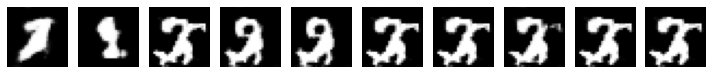

17300 [D loss: 0.079039, acc.: 95.31%] [G loss: 5.729016]
17301 [D loss: 0.063996, acc.: 97.66%] [G loss: 6.551738]
17302 [D loss: 0.009730, acc.: 100.00%] [G loss: 6.873252]
17303 [D loss: 0.038203, acc.: 98.44%] [G loss: 6.414708]
17304 [D loss: 0.021285, acc.: 99.22%] [G loss: 6.745648]
17305 [D loss: 0.077204, acc.: 97.66%] [G loss: 6.237955]
17306 [D loss: 0.034755, acc.: 99.22%] [G loss: 5.876060]
17307 [D loss: 0.090197, acc.: 96.88%] [G loss: 5.584724]
17308 [D loss: 0.040733, acc.: 99.22%] [G loss: 4.538609]
17309 [D loss: 0.044463, acc.: 98.44%] [G loss: 4.455734]
17310 [D loss: 0.030452, acc.: 97.66%] [G loss: 5.352123]
17311 [D loss: 0.037051, acc.: 98.44%] [G loss: 4.487325]
17312 [D loss: 0.070424, acc.: 98.44%] [G loss: 4.651711]
17313 [D loss: 0.068653, acc.: 97.66%] [G loss: 5.459025]
17314 [D loss: 0.019523, acc.: 99.22%] [G loss: 5.833002]
17315 [D loss: 0.052666, acc.: 97.66%] [G loss: 6.308040]
17316 [D loss: 0.026013, acc.: 99.22%] [G loss: 5.226276]
17317 [D loss

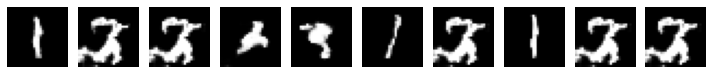

17400 [D loss: 0.009685, acc.: 100.00%] [G loss: 3.630957]
17401 [D loss: 0.030987, acc.: 97.66%] [G loss: 4.148069]
17402 [D loss: 0.052820, acc.: 98.44%] [G loss: 4.053442]
17403 [D loss: 0.028703, acc.: 98.44%] [G loss: 5.205704]
17404 [D loss: 0.041280, acc.: 98.44%] [G loss: 5.676337]
17405 [D loss: 0.024288, acc.: 98.44%] [G loss: 5.819299]
17406 [D loss: 0.020029, acc.: 99.22%] [G loss: 6.495825]
17407 [D loss: 0.008268, acc.: 100.00%] [G loss: 6.847686]
17408 [D loss: 0.010387, acc.: 100.00%] [G loss: 6.155049]
17409 [D loss: 0.110428, acc.: 95.31%] [G loss: 6.187832]
17410 [D loss: 0.039522, acc.: 98.44%] [G loss: 5.562256]
17411 [D loss: 0.106197, acc.: 96.09%] [G loss: 4.952762]
17412 [D loss: 0.027319, acc.: 98.44%] [G loss: 3.838051]
17413 [D loss: 0.017897, acc.: 99.22%] [G loss: 4.277281]
17414 [D loss: 0.041689, acc.: 99.22%] [G loss: 4.108184]
17415 [D loss: 0.076615, acc.: 97.66%] [G loss: 3.988002]
17416 [D loss: 0.037125, acc.: 98.44%] [G loss: 3.444684]
17417 [D lo

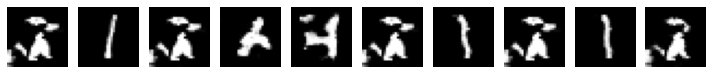

17500 [D loss: 0.010266, acc.: 100.00%] [G loss: 4.808367]
17501 [D loss: 0.037052, acc.: 98.44%] [G loss: 4.604820]
17502 [D loss: 0.060807, acc.: 97.66%] [G loss: 3.991864]
17503 [D loss: 0.032324, acc.: 99.22%] [G loss: 5.154865]
17504 [D loss: 0.026658, acc.: 98.44%] [G loss: 5.994555]
17505 [D loss: 0.060763, acc.: 96.09%] [G loss: 4.352916]
17506 [D loss: 0.023812, acc.: 98.44%] [G loss: 3.728347]
17507 [D loss: 0.017582, acc.: 100.00%] [G loss: 3.588671]
17508 [D loss: 0.044283, acc.: 97.66%] [G loss: 3.406745]
17509 [D loss: 0.080617, acc.: 96.09%] [G loss: 4.079667]
17510 [D loss: 0.048177, acc.: 98.44%] [G loss: 4.776457]
17511 [D loss: 0.052340, acc.: 98.44%] [G loss: 4.393245]
17512 [D loss: 0.020742, acc.: 99.22%] [G loss: 3.643679]
17513 [D loss: 0.012988, acc.: 100.00%] [G loss: 4.066106]
17514 [D loss: 0.072371, acc.: 97.66%] [G loss: 3.153554]
17515 [D loss: 0.064899, acc.: 98.44%] [G loss: 3.593040]
17516 [D loss: 0.046048, acc.: 99.22%] [G loss: 4.795987]
17517 [D lo

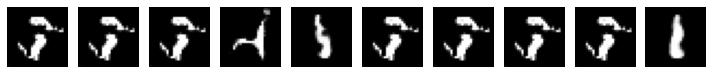

17600 [D loss: 0.022394, acc.: 100.00%] [G loss: 3.710194]
17601 [D loss: 0.106393, acc.: 96.88%] [G loss: 4.301871]
17602 [D loss: 0.048677, acc.: 99.22%] [G loss: 5.108656]
17603 [D loss: 0.020313, acc.: 99.22%] [G loss: 6.151837]
17604 [D loss: 0.062914, acc.: 97.66%] [G loss: 6.013599]
17605 [D loss: 0.028118, acc.: 99.22%] [G loss: 5.076234]
17606 [D loss: 0.026579, acc.: 98.44%] [G loss: 4.062168]
17607 [D loss: 0.033755, acc.: 99.22%] [G loss: 3.851069]
17608 [D loss: 0.073937, acc.: 96.88%] [G loss: 2.755037]
17609 [D loss: 0.019951, acc.: 99.22%] [G loss: 3.568207]
17610 [D loss: 0.038015, acc.: 98.44%] [G loss: 3.625810]
17611 [D loss: 0.006998, acc.: 100.00%] [G loss: 4.839295]
17612 [D loss: 0.019164, acc.: 99.22%] [G loss: 5.106761]
17613 [D loss: 0.021704, acc.: 98.44%] [G loss: 5.156869]
17614 [D loss: 0.035521, acc.: 98.44%] [G loss: 4.401814]
17615 [D loss: 0.028770, acc.: 99.22%] [G loss: 5.380116]
17616 [D loss: 0.030679, acc.: 99.22%] [G loss: 5.954416]
17617 [D los

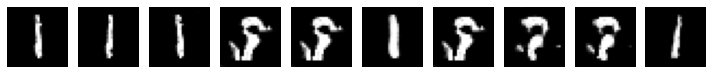

17700 [D loss: 0.077442, acc.: 96.88%] [G loss: 4.829052]
17701 [D loss: 0.153880, acc.: 94.53%] [G loss: 3.676600]
17702 [D loss: 0.131262, acc.: 95.31%] [G loss: 3.691485]
17703 [D loss: 0.066216, acc.: 96.88%] [G loss: 4.624777]
17704 [D loss: 0.016007, acc.: 100.00%] [G loss: 5.806935]
17705 [D loss: 0.044422, acc.: 96.88%] [G loss: 6.888271]
17706 [D loss: 0.031034, acc.: 99.22%] [G loss: 6.987188]
17707 [D loss: 0.035335, acc.: 99.22%] [G loss: 7.035820]
17708 [D loss: 0.062312, acc.: 97.66%] [G loss: 5.960360]
17709 [D loss: 0.077533, acc.: 97.66%] [G loss: 4.655857]
17710 [D loss: 0.020292, acc.: 99.22%] [G loss: 3.791290]
17711 [D loss: 0.080092, acc.: 98.44%] [G loss: 4.243573]
17712 [D loss: 0.026679, acc.: 99.22%] [G loss: 5.945252]
17713 [D loss: 0.022231, acc.: 99.22%] [G loss: 7.050797]
17714 [D loss: 0.032387, acc.: 99.22%] [G loss: 7.198604]
17715 [D loss: 0.020697, acc.: 99.22%] [G loss: 7.311527]
17716 [D loss: 0.077705, acc.: 96.88%] [G loss: 6.961959]
17717 [D loss

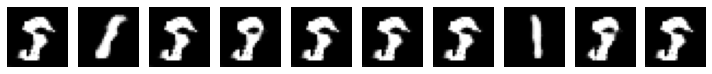

17800 [D loss: 0.028550, acc.: 99.22%] [G loss: 7.081217]
17801 [D loss: 0.012388, acc.: 100.00%] [G loss: 7.769560]
17802 [D loss: 0.040260, acc.: 98.44%] [G loss: 7.424857]
17803 [D loss: 0.039394, acc.: 98.44%] [G loss: 6.708216]
17804 [D loss: 0.039748, acc.: 98.44%] [G loss: 5.791871]
17805 [D loss: 0.037362, acc.: 98.44%] [G loss: 4.979705]
17806 [D loss: 0.035449, acc.: 98.44%] [G loss: 4.115822]
17807 [D loss: 0.061142, acc.: 97.66%] [G loss: 3.765309]
17808 [D loss: 0.089412, acc.: 98.44%] [G loss: 4.839862]
17809 [D loss: 0.030483, acc.: 98.44%] [G loss: 5.810398]
17810 [D loss: 0.036964, acc.: 98.44%] [G loss: 6.908466]
17811 [D loss: 0.036045, acc.: 96.88%] [G loss: 7.241087]
17812 [D loss: 0.041396, acc.: 98.44%] [G loss: 6.588305]
17813 [D loss: 0.071690, acc.: 97.66%] [G loss: 5.833848]
17814 [D loss: 0.026985, acc.: 98.44%] [G loss: 5.006368]
17815 [D loss: 0.116445, acc.: 96.09%] [G loss: 3.899546]
17816 [D loss: 0.111920, acc.: 95.31%] [G loss: 4.263988]
17817 [D loss

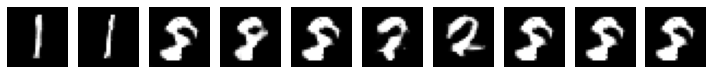

17900 [D loss: 0.061685, acc.: 99.22%] [G loss: 7.128768]
17901 [D loss: 0.036704, acc.: 98.44%] [G loss: 6.922508]
17902 [D loss: 0.005557, acc.: 100.00%] [G loss: 6.281758]
17903 [D loss: 0.022108, acc.: 99.22%] [G loss: 6.299134]
17904 [D loss: 0.084848, acc.: 96.88%] [G loss: 5.063096]
17905 [D loss: 0.065935, acc.: 97.66%] [G loss: 4.718817]
17906 [D loss: 0.060833, acc.: 97.66%] [G loss: 5.189470]
17907 [D loss: 0.039101, acc.: 99.22%] [G loss: 6.308023]
17908 [D loss: 0.023387, acc.: 98.44%] [G loss: 7.480213]
17909 [D loss: 0.038236, acc.: 98.44%] [G loss: 6.685641]
17910 [D loss: 0.074020, acc.: 97.66%] [G loss: 5.741338]
17911 [D loss: 0.048708, acc.: 98.44%] [G loss: 5.118667]
17912 [D loss: 0.030408, acc.: 99.22%] [G loss: 4.418171]
17913 [D loss: 0.062346, acc.: 96.88%] [G loss: 4.784083]
17914 [D loss: 0.040944, acc.: 97.66%] [G loss: 5.897346]
17915 [D loss: 0.067635, acc.: 96.88%] [G loss: 5.952411]
17916 [D loss: 0.027556, acc.: 99.22%] [G loss: 6.089943]
17917 [D loss

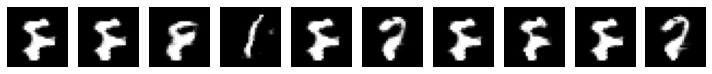

18000 [D loss: 0.047119, acc.: 97.66%] [G loss: 4.773388]
18001 [D loss: 0.052104, acc.: 97.66%] [G loss: 6.385640]
18002 [D loss: 0.011623, acc.: 100.00%] [G loss: 8.190533]
18003 [D loss: 0.058966, acc.: 96.88%] [G loss: 7.890632]
18004 [D loss: 0.009174, acc.: 100.00%] [G loss: 8.139722]
18005 [D loss: 0.009917, acc.: 100.00%] [G loss: 7.874074]
18006 [D loss: 0.005183, acc.: 100.00%] [G loss: 7.329126]
18007 [D loss: 0.073941, acc.: 97.66%] [G loss: 6.835124]
18008 [D loss: 0.048677, acc.: 98.44%] [G loss: 5.775815]
18009 [D loss: 0.007735, acc.: 100.00%] [G loss: 5.606879]
18010 [D loss: 0.045860, acc.: 98.44%] [G loss: 5.264441]
18011 [D loss: 0.014128, acc.: 100.00%] [G loss: 6.207522]
18012 [D loss: 0.066239, acc.: 95.31%] [G loss: 7.595822]
18013 [D loss: 0.019765, acc.: 99.22%] [G loss: 8.068567]
18014 [D loss: 0.014887, acc.: 99.22%] [G loss: 9.215600]
18015 [D loss: 0.057008, acc.: 97.66%] [G loss: 9.050002]
18016 [D loss: 0.020555, acc.: 98.44%] [G loss: 8.547472]
18017 [D

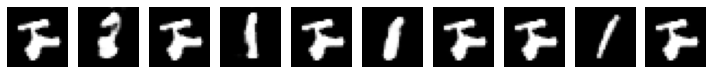

18100 [D loss: 0.026308, acc.: 98.44%] [G loss: 5.666509]
18101 [D loss: 0.020123, acc.: 99.22%] [G loss: 5.461175]
18102 [D loss: 0.057532, acc.: 98.44%] [G loss: 5.030479]
18103 [D loss: 0.042552, acc.: 97.66%] [G loss: 4.520248]
18104 [D loss: 0.070465, acc.: 96.88%] [G loss: 4.435064]
18105 [D loss: 0.036798, acc.: 98.44%] [G loss: 4.245099]
18106 [D loss: 0.037320, acc.: 99.22%] [G loss: 4.327725]
18107 [D loss: 0.054363, acc.: 97.66%] [G loss: 5.250173]
18108 [D loss: 0.024913, acc.: 98.44%] [G loss: 5.761424]
18109 [D loss: 0.038701, acc.: 98.44%] [G loss: 5.126409]
18110 [D loss: 0.039035, acc.: 98.44%] [G loss: 5.721482]
18111 [D loss: 0.035248, acc.: 97.66%] [G loss: 5.850252]
18112 [D loss: 0.037425, acc.: 98.44%] [G loss: 5.981226]
18113 [D loss: 0.026011, acc.: 98.44%] [G loss: 6.075373]
18114 [D loss: 0.042672, acc.: 97.66%] [G loss: 6.114448]
18115 [D loss: 0.020485, acc.: 98.44%] [G loss: 6.074320]
18116 [D loss: 0.059335, acc.: 97.66%] [G loss: 6.934596]
18117 [D loss:

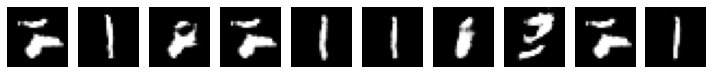

18200 [D loss: 0.073360, acc.: 97.66%] [G loss: 6.690733]
18201 [D loss: 0.006634, acc.: 100.00%] [G loss: 6.899989]
18202 [D loss: 0.012843, acc.: 100.00%] [G loss: 7.273579]
18203 [D loss: 0.035675, acc.: 97.66%] [G loss: 6.498626]
18204 [D loss: 0.044921, acc.: 98.44%] [G loss: 6.119344]
18205 [D loss: 0.065303, acc.: 97.66%] [G loss: 6.783813]
18206 [D loss: 0.009677, acc.: 100.00%] [G loss: 7.399340]
18207 [D loss: 0.007241, acc.: 100.00%] [G loss: 8.557001]
18208 [D loss: 0.021365, acc.: 99.22%] [G loss: 8.623817]
18209 [D loss: 0.021581, acc.: 99.22%] [G loss: 8.478434]
18210 [D loss: 0.074362, acc.: 95.31%] [G loss: 8.267702]
18211 [D loss: 0.065176, acc.: 97.66%] [G loss: 8.168863]
18212 [D loss: 0.063386, acc.: 97.66%] [G loss: 8.575586]
18213 [D loss: 0.059812, acc.: 98.44%] [G loss: 9.019275]
18214 [D loss: 0.067141, acc.: 96.88%] [G loss: 8.887377]
18215 [D loss: 0.140754, acc.: 95.31%] [G loss: 7.041464]
18216 [D loss: 0.085087, acc.: 96.09%] [G loss: 4.944351]
18217 [D l

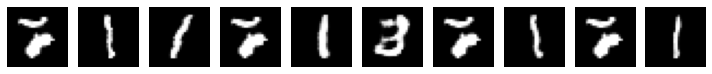

18300 [D loss: 0.055789, acc.: 96.88%] [G loss: 5.647104]
18301 [D loss: 0.031695, acc.: 98.44%] [G loss: 6.030726]
18302 [D loss: 0.026766, acc.: 99.22%] [G loss: 5.911386]
18303 [D loss: 0.064250, acc.: 98.44%] [G loss: 5.639660]
18304 [D loss: 0.033064, acc.: 98.44%] [G loss: 6.243190]
18305 [D loss: 0.017884, acc.: 99.22%] [G loss: 6.379502]
18306 [D loss: 0.006405, acc.: 100.00%] [G loss: 6.435621]
18307 [D loss: 0.012934, acc.: 99.22%] [G loss: 6.169643]
18308 [D loss: 0.056384, acc.: 96.88%] [G loss: 5.601189]
18309 [D loss: 0.047809, acc.: 98.44%] [G loss: 5.650622]
18310 [D loss: 0.022624, acc.: 99.22%] [G loss: 5.980034]
18311 [D loss: 0.102926, acc.: 97.66%] [G loss: 5.835386]
18312 [D loss: 0.055205, acc.: 97.66%] [G loss: 5.180657]
18313 [D loss: 0.034522, acc.: 99.22%] [G loss: 5.515856]
18314 [D loss: 0.017534, acc.: 99.22%] [G loss: 5.569099]
18315 [D loss: 0.009379, acc.: 99.22%] [G loss: 5.775223]
18316 [D loss: 0.046621, acc.: 98.44%] [G loss: 5.860223]
18317 [D loss

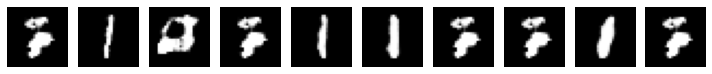

18400 [D loss: 0.004210, acc.: 100.00%] [G loss: 6.930866]
18401 [D loss: 0.042858, acc.: 98.44%] [G loss: 6.158498]
18402 [D loss: 0.048049, acc.: 98.44%] [G loss: 5.282523]
18403 [D loss: 0.032460, acc.: 98.44%] [G loss: 4.662220]
18404 [D loss: 0.026041, acc.: 100.00%] [G loss: 4.053578]
18405 [D loss: 0.082485, acc.: 96.09%] [G loss: 4.798444]
18406 [D loss: 0.035910, acc.: 98.44%] [G loss: 5.356013]
18407 [D loss: 0.074657, acc.: 97.66%] [G loss: 6.417278]
18408 [D loss: 0.087470, acc.: 97.66%] [G loss: 6.049253]
18409 [D loss: 0.021142, acc.: 99.22%] [G loss: 5.416077]
18410 [D loss: 0.062863, acc.: 98.44%] [G loss: 4.935593]
18411 [D loss: 0.009735, acc.: 100.00%] [G loss: 5.096592]
18412 [D loss: 0.022097, acc.: 99.22%] [G loss: 4.879973]
18413 [D loss: 0.027491, acc.: 100.00%] [G loss: 4.911112]
18414 [D loss: 0.018750, acc.: 99.22%] [G loss: 5.243599]
18415 [D loss: 0.017950, acc.: 99.22%] [G loss: 5.021016]
18416 [D loss: 0.017032, acc.: 99.22%] [G loss: 6.039683]
18417 [D l

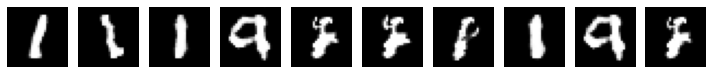

18500 [D loss: 0.051070, acc.: 97.66%] [G loss: 4.771292]
18501 [D loss: 0.046225, acc.: 98.44%] [G loss: 4.874457]
18502 [D loss: 0.038096, acc.: 98.44%] [G loss: 4.980849]
18503 [D loss: 0.018411, acc.: 100.00%] [G loss: 5.144786]
18504 [D loss: 0.065106, acc.: 99.22%] [G loss: 5.335725]
18505 [D loss: 0.075618, acc.: 97.66%] [G loss: 4.893251]
18506 [D loss: 0.008407, acc.: 100.00%] [G loss: 5.662311]
18507 [D loss: 0.011337, acc.: 100.00%] [G loss: 6.153308]
18508 [D loss: 0.049144, acc.: 97.66%] [G loss: 4.942437]
18509 [D loss: 0.038296, acc.: 99.22%] [G loss: 3.943576]
18510 [D loss: 0.061636, acc.: 97.66%] [G loss: 2.740828]
18511 [D loss: 0.076630, acc.: 98.44%] [G loss: 1.999749]
18512 [D loss: 0.053782, acc.: 98.44%] [G loss: 2.623086]
18513 [D loss: 0.046233, acc.: 97.66%] [G loss: 3.596939]
18514 [D loss: 0.028941, acc.: 99.22%] [G loss: 4.818510]
18515 [D loss: 0.019746, acc.: 99.22%] [G loss: 5.471478]
18516 [D loss: 0.076220, acc.: 96.88%] [G loss: 4.791406]
18517 [D lo

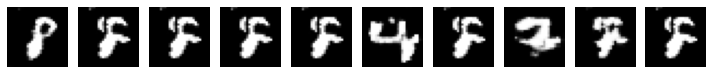

18600 [D loss: 0.043495, acc.: 99.22%] [G loss: 5.092003]
18601 [D loss: 0.019668, acc.: 99.22%] [G loss: 5.245034]
18602 [D loss: 0.060945, acc.: 98.44%] [G loss: 5.423799]
18603 [D loss: 0.046355, acc.: 98.44%] [G loss: 5.141818]
18604 [D loss: 0.111174, acc.: 95.31%] [G loss: 5.595259]
18605 [D loss: 0.026604, acc.: 99.22%] [G loss: 4.308532]
18606 [D loss: 0.110773, acc.: 96.88%] [G loss: 3.253222]
18607 [D loss: 0.157759, acc.: 92.97%] [G loss: 3.744663]
18608 [D loss: 0.019600, acc.: 100.00%] [G loss: 6.071283]
18609 [D loss: 0.033912, acc.: 99.22%] [G loss: 6.818986]
18610 [D loss: 0.127363, acc.: 95.31%] [G loss: 6.641186]
18611 [D loss: 0.098948, acc.: 96.88%] [G loss: 4.165006]
18612 [D loss: 0.048216, acc.: 98.44%] [G loss: 2.871336]
18613 [D loss: 0.171263, acc.: 91.41%] [G loss: 2.492493]
18614 [D loss: 0.062614, acc.: 99.22%] [G loss: 3.486599]
18615 [D loss: 0.082987, acc.: 96.88%] [G loss: 3.546213]
18616 [D loss: 0.023778, acc.: 98.44%] [G loss: 3.562572]
18617 [D loss

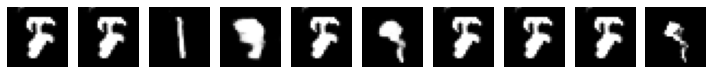

18700 [D loss: 0.026470, acc.: 99.22%] [G loss: 6.715139]
18701 [D loss: 0.062052, acc.: 96.88%] [G loss: 6.330425]
18702 [D loss: 0.107125, acc.: 96.88%] [G loss: 4.625770]
18703 [D loss: 0.041440, acc.: 98.44%] [G loss: 4.459129]
18704 [D loss: 0.026785, acc.: 99.22%] [G loss: 5.388267]
18705 [D loss: 0.037105, acc.: 98.44%] [G loss: 4.987595]
18706 [D loss: 0.057442, acc.: 98.44%] [G loss: 5.490544]
18707 [D loss: 0.069739, acc.: 96.09%] [G loss: 7.242595]
18708 [D loss: 0.028962, acc.: 98.44%] [G loss: 6.953120]
18709 [D loss: 0.044059, acc.: 99.22%] [G loss: 7.089849]
18710 [D loss: 0.020090, acc.: 98.44%] [G loss: 6.568604]
18711 [D loss: 0.021514, acc.: 99.22%] [G loss: 5.031283]
18712 [D loss: 0.006619, acc.: 100.00%] [G loss: 4.864420]
18713 [D loss: 0.081592, acc.: 97.66%] [G loss: 4.342410]
18714 [D loss: 0.007470, acc.: 100.00%] [G loss: 3.153816]
18715 [D loss: 0.092400, acc.: 95.31%] [G loss: 2.713510]
18716 [D loss: 0.032398, acc.: 99.22%] [G loss: 3.704184]
18717 [D los

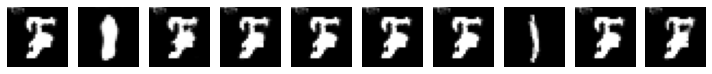

18800 [D loss: 0.015885, acc.: 100.00%] [G loss: 3.068605]
18801 [D loss: 0.025608, acc.: 98.44%] [G loss: 3.182852]
18802 [D loss: 0.015764, acc.: 99.22%] [G loss: 2.874162]
18803 [D loss: 0.044756, acc.: 97.66%] [G loss: 2.877891]
18804 [D loss: 0.056674, acc.: 96.88%] [G loss: 2.288921]
18805 [D loss: 0.036426, acc.: 99.22%] [G loss: 3.490325]
18806 [D loss: 0.043674, acc.: 99.22%] [G loss: 4.141717]
18807 [D loss: 0.049310, acc.: 99.22%] [G loss: 3.133348]
18808 [D loss: 0.025240, acc.: 98.44%] [G loss: 3.150120]
18809 [D loss: 0.024341, acc.: 99.22%] [G loss: 3.022757]
18810 [D loss: 0.065775, acc.: 97.66%] [G loss: 1.994161]
18811 [D loss: 0.036140, acc.: 99.22%] [G loss: 3.531558]
18812 [D loss: 0.026768, acc.: 98.44%] [G loss: 4.337286]
18813 [D loss: 0.023530, acc.: 99.22%] [G loss: 4.881541]
18814 [D loss: 0.084556, acc.: 97.66%] [G loss: 4.415809]
18815 [D loss: 0.046933, acc.: 97.66%] [G loss: 4.078278]
18816 [D loss: 0.020211, acc.: 100.00%] [G loss: 3.618591]
18817 [D los

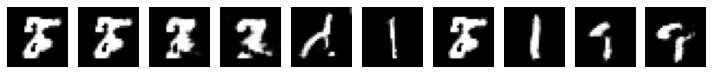

18900 [D loss: 0.025281, acc.: 99.22%] [G loss: 5.164837]
18901 [D loss: 0.019962, acc.: 99.22%] [G loss: 4.462954]
18902 [D loss: 0.035141, acc.: 98.44%] [G loss: 4.130657]
18903 [D loss: 0.048081, acc.: 98.44%] [G loss: 4.361701]
18904 [D loss: 0.063528, acc.: 96.88%] [G loss: 3.568196]
18905 [D loss: 0.039012, acc.: 98.44%] [G loss: 3.826666]
18906 [D loss: 0.027050, acc.: 98.44%] [G loss: 4.882339]
18907 [D loss: 0.042800, acc.: 99.22%] [G loss: 6.056581]
18908 [D loss: 0.020653, acc.: 99.22%] [G loss: 6.369361]
18909 [D loss: 0.015883, acc.: 100.00%] [G loss: 6.389323]
18910 [D loss: 0.010269, acc.: 100.00%] [G loss: 6.765144]
18911 [D loss: 0.029771, acc.: 99.22%] [G loss: 6.262208]
18912 [D loss: 0.021143, acc.: 100.00%] [G loss: 6.312778]
18913 [D loss: 0.010388, acc.: 100.00%] [G loss: 5.339238]
18914 [D loss: 0.006533, acc.: 100.00%] [G loss: 5.091913]
18915 [D loss: 0.092642, acc.: 96.88%] [G loss: 3.674088]
18916 [D loss: 0.037848, acc.: 99.22%] [G loss: 3.501499]
18917 [D 

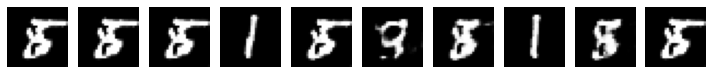

19000 [D loss: 0.022891, acc.: 99.22%] [G loss: 3.643437]
19001 [D loss: 0.055288, acc.: 97.66%] [G loss: 2.924180]
19002 [D loss: 0.064462, acc.: 96.88%] [G loss: 3.359058]
19003 [D loss: 0.019515, acc.: 99.22%] [G loss: 3.900066]
19004 [D loss: 0.032580, acc.: 97.66%] [G loss: 3.597245]
19005 [D loss: 0.052657, acc.: 98.44%] [G loss: 3.339931]
19006 [D loss: 0.017330, acc.: 100.00%] [G loss: 3.393672]
19007 [D loss: 0.067141, acc.: 97.66%] [G loss: 2.950321]
19008 [D loss: 0.047974, acc.: 98.44%] [G loss: 2.605733]
19009 [D loss: 0.018897, acc.: 99.22%] [G loss: 2.438606]
19010 [D loss: 0.073184, acc.: 98.44%] [G loss: 2.588390]
19011 [D loss: 0.019370, acc.: 99.22%] [G loss: 2.741232]
19012 [D loss: 0.052533, acc.: 97.66%] [G loss: 3.181473]
19013 [D loss: 0.051696, acc.: 96.88%] [G loss: 2.791943]
19014 [D loss: 0.048424, acc.: 99.22%] [G loss: 2.653563]
19015 [D loss: 0.017027, acc.: 100.00%] [G loss: 3.641567]
19016 [D loss: 0.090084, acc.: 97.66%] [G loss: 3.917560]
19017 [D los

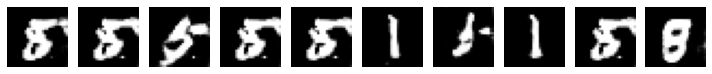

19100 [D loss: 0.088145, acc.: 96.88%] [G loss: 5.461664]
19101 [D loss: 0.056868, acc.: 98.44%] [G loss: 5.298357]
19102 [D loss: 0.025732, acc.: 100.00%] [G loss: 4.979715]
19103 [D loss: 0.088087, acc.: 96.09%] [G loss: 5.143783]
19104 [D loss: 0.010921, acc.: 100.00%] [G loss: 5.329912]
19105 [D loss: 0.030144, acc.: 98.44%] [G loss: 6.219741]
19106 [D loss: 0.062747, acc.: 96.88%] [G loss: 6.947310]
19107 [D loss: 0.004132, acc.: 100.00%] [G loss: 7.667546]
19108 [D loss: 0.078799, acc.: 96.88%] [G loss: 7.412825]
19109 [D loss: 0.019369, acc.: 99.22%] [G loss: 6.581930]
19110 [D loss: 0.036679, acc.: 98.44%] [G loss: 4.918262]
19111 [D loss: 0.062698, acc.: 98.44%] [G loss: 3.879956]
19112 [D loss: 0.025357, acc.: 99.22%] [G loss: 3.346241]
19113 [D loss: 0.088805, acc.: 96.09%] [G loss: 3.405451]
19114 [D loss: 0.052631, acc.: 96.88%] [G loss: 4.534241]
19115 [D loss: 0.014700, acc.: 100.00%] [G loss: 4.750212]
19116 [D loss: 0.014603, acc.: 99.22%] [G loss: 4.899867]
19117 [D l

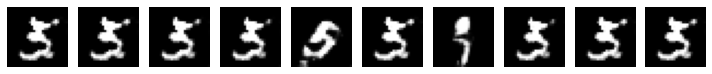

19200 [D loss: 0.054115, acc.: 98.44%] [G loss: 3.456904]
19201 [D loss: 0.032632, acc.: 99.22%] [G loss: 3.586136]
19202 [D loss: 0.033333, acc.: 99.22%] [G loss: 5.039854]
19203 [D loss: 0.005206, acc.: 100.00%] [G loss: 6.480834]
19204 [D loss: 0.118749, acc.: 96.88%] [G loss: 5.879521]
19205 [D loss: 0.006374, acc.: 100.00%] [G loss: 5.765353]
19206 [D loss: 0.026861, acc.: 99.22%] [G loss: 5.573199]
19207 [D loss: 0.049573, acc.: 98.44%] [G loss: 5.049819]
19208 [D loss: 0.068166, acc.: 98.44%] [G loss: 4.895710]
19209 [D loss: 0.009869, acc.: 100.00%] [G loss: 4.887267]
19210 [D loss: 0.023038, acc.: 99.22%] [G loss: 4.855483]
19211 [D loss: 0.034394, acc.: 98.44%] [G loss: 5.872775]
19212 [D loss: 0.025913, acc.: 99.22%] [G loss: 5.998682]
19213 [D loss: 0.077518, acc.: 96.88%] [G loss: 5.244595]
19214 [D loss: 0.032233, acc.: 99.22%] [G loss: 4.152010]
19215 [D loss: 0.107068, acc.: 96.09%] [G loss: 4.479428]
19216 [D loss: 0.037860, acc.: 98.44%] [G loss: 4.300129]
19217 [D lo

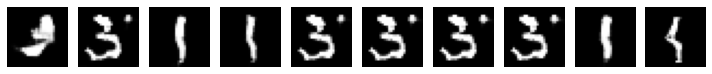

19300 [D loss: 0.043617, acc.: 97.66%] [G loss: 3.631603]
19301 [D loss: 0.070211, acc.: 98.44%] [G loss: 3.902744]
19302 [D loss: 0.098518, acc.: 95.31%] [G loss: 4.152243]
19303 [D loss: 0.026410, acc.: 99.22%] [G loss: 4.500732]
19304 [D loss: 0.075298, acc.: 96.09%] [G loss: 4.148621]
19305 [D loss: 0.052470, acc.: 98.44%] [G loss: 4.124094]
19306 [D loss: 0.029983, acc.: 99.22%] [G loss: 5.000566]
19307 [D loss: 0.018112, acc.: 99.22%] [G loss: 4.403043]
19308 [D loss: 0.087963, acc.: 98.44%] [G loss: 4.169036]
19309 [D loss: 0.048574, acc.: 98.44%] [G loss: 3.025541]
19310 [D loss: 0.037278, acc.: 98.44%] [G loss: 3.500202]
19311 [D loss: 0.068620, acc.: 96.88%] [G loss: 4.854483]
19312 [D loss: 0.065303, acc.: 97.66%] [G loss: 5.278112]
19313 [D loss: 0.086299, acc.: 96.88%] [G loss: 5.294645]
19314 [D loss: 0.069755, acc.: 99.22%] [G loss: 4.218244]
19315 [D loss: 0.041302, acc.: 99.22%] [G loss: 3.673046]
19316 [D loss: 0.044789, acc.: 98.44%] [G loss: 3.702712]
19317 [D loss:

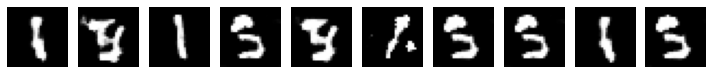

19400 [D loss: 0.024066, acc.: 100.00%] [G loss: 5.297733]
19401 [D loss: 0.024907, acc.: 99.22%] [G loss: 5.941450]
19402 [D loss: 0.045377, acc.: 97.66%] [G loss: 6.035583]
19403 [D loss: 0.026218, acc.: 98.44%] [G loss: 5.634784]
19404 [D loss: 0.018300, acc.: 100.00%] [G loss: 5.433959]
19405 [D loss: 0.023722, acc.: 99.22%] [G loss: 5.793316]
19406 [D loss: 0.009823, acc.: 100.00%] [G loss: 6.431528]
19407 [D loss: 0.015523, acc.: 100.00%] [G loss: 7.422772]
19408 [D loss: 0.024521, acc.: 99.22%] [G loss: 7.210353]
19409 [D loss: 0.026889, acc.: 97.66%] [G loss: 7.729589]
19410 [D loss: 0.006147, acc.: 100.00%] [G loss: 6.437809]
19411 [D loss: 0.085687, acc.: 96.88%] [G loss: 7.034461]
19412 [D loss: 0.103634, acc.: 96.88%] [G loss: 5.684342]
19413 [D loss: 0.078002, acc.: 98.44%] [G loss: 7.307492]
19414 [D loss: 0.028615, acc.: 99.22%] [G loss: 8.445654]
19415 [D loss: 0.060280, acc.: 97.66%] [G loss: 9.023423]
19416 [D loss: 0.035976, acc.: 97.66%] [G loss: 8.279957]
19417 [D 

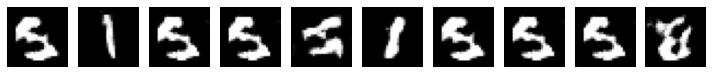

19500 [D loss: 0.067135, acc.: 96.88%] [G loss: 5.161504]
19501 [D loss: 0.047503, acc.: 98.44%] [G loss: 6.639840]
19502 [D loss: 0.007250, acc.: 100.00%] [G loss: 7.829894]
19503 [D loss: 0.103759, acc.: 97.66%] [G loss: 8.897352]
19504 [D loss: 0.003706, acc.: 100.00%] [G loss: 8.773499]
19505 [D loss: 0.011116, acc.: 100.00%] [G loss: 9.952265]
19506 [D loss: 0.020939, acc.: 99.22%] [G loss: 9.376003]
19507 [D loss: 0.075197, acc.: 97.66%] [G loss: 7.811794]
19508 [D loss: 0.023570, acc.: 98.44%] [G loss: 6.337653]
19509 [D loss: 0.055134, acc.: 96.09%] [G loss: 5.519449]
19510 [D loss: 0.036054, acc.: 98.44%] [G loss: 4.419935]
19511 [D loss: 0.010970, acc.: 99.22%] [G loss: 4.884585]
19512 [D loss: 0.007488, acc.: 100.00%] [G loss: 4.610682]
19513 [D loss: 0.019987, acc.: 99.22%] [G loss: 5.507630]
19514 [D loss: 0.007374, acc.: 100.00%] [G loss: 5.479300]
19515 [D loss: 0.015340, acc.: 99.22%] [G loss: 5.539834]
19516 [D loss: 0.062689, acc.: 97.66%] [G loss: 5.373830]
19517 [D 

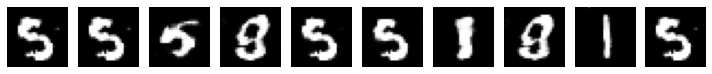

19600 [D loss: 0.022573, acc.: 99.22%] [G loss: 6.230763]
19601 [D loss: 0.006837, acc.: 100.00%] [G loss: 7.247394]
19602 [D loss: 0.028458, acc.: 99.22%] [G loss: 7.652937]
19603 [D loss: 0.060530, acc.: 97.66%] [G loss: 7.040204]
19604 [D loss: 0.094274, acc.: 96.09%] [G loss: 7.217022]
19605 [D loss: 0.089632, acc.: 99.22%] [G loss: 6.006023]
19606 [D loss: 0.135064, acc.: 95.31%] [G loss: 4.582951]
19607 [D loss: 0.092089, acc.: 97.66%] [G loss: 5.030981]
19608 [D loss: 0.012164, acc.: 100.00%] [G loss: 5.565677]
19609 [D loss: 0.017520, acc.: 99.22%] [G loss: 5.582404]
19610 [D loss: 0.004965, acc.: 100.00%] [G loss: 5.614511]
19611 [D loss: 0.053751, acc.: 96.88%] [G loss: 5.388310]
19612 [D loss: 0.052646, acc.: 97.66%] [G loss: 4.399463]
19613 [D loss: 0.043069, acc.: 98.44%] [G loss: 4.230419]
19614 [D loss: 0.012153, acc.: 100.00%] [G loss: 3.753664]
19615 [D loss: 0.006986, acc.: 100.00%] [G loss: 4.713486]
19616 [D loss: 0.049977, acc.: 97.66%] [G loss: 5.776747]
19617 [D 

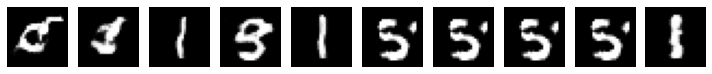

19700 [D loss: 0.033768, acc.: 98.44%] [G loss: 4.934636]
19701 [D loss: 0.011286, acc.: 100.00%] [G loss: 4.310737]
19702 [D loss: 0.041455, acc.: 98.44%] [G loss: 3.286276]
19703 [D loss: 0.018530, acc.: 99.22%] [G loss: 4.063280]
19704 [D loss: 0.018466, acc.: 99.22%] [G loss: 4.742484]
19705 [D loss: 0.009336, acc.: 99.22%] [G loss: 5.420921]
19706 [D loss: 0.021902, acc.: 99.22%] [G loss: 5.186343]
19707 [D loss: 0.031275, acc.: 98.44%] [G loss: 5.457798]
19708 [D loss: 0.063485, acc.: 97.66%] [G loss: 4.395879]
19709 [D loss: 0.015560, acc.: 99.22%] [G loss: 3.849923]
19710 [D loss: 0.031614, acc.: 98.44%] [G loss: 3.797655]
19711 [D loss: 0.032347, acc.: 98.44%] [G loss: 3.725047]
19712 [D loss: 0.015205, acc.: 99.22%] [G loss: 4.534910]
19713 [D loss: 0.005055, acc.: 100.00%] [G loss: 4.565833]
19714 [D loss: 0.008021, acc.: 100.00%] [G loss: 4.700271]
19715 [D loss: 0.042137, acc.: 98.44%] [G loss: 4.353169]
19716 [D loss: 0.027536, acc.: 99.22%] [G loss: 4.391206]
19717 [D lo

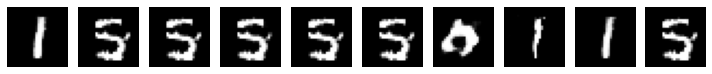

19800 [D loss: 0.057186, acc.: 98.44%] [G loss: 4.672218]
19801 [D loss: 0.009326, acc.: 99.22%] [G loss: 5.406114]
19802 [D loss: 0.016954, acc.: 99.22%] [G loss: 5.165722]
19803 [D loss: 0.041269, acc.: 98.44%] [G loss: 6.185390]
19804 [D loss: 0.006365, acc.: 100.00%] [G loss: 6.753175]
19805 [D loss: 0.001311, acc.: 100.00%] [G loss: 7.271265]
19806 [D loss: 0.045585, acc.: 97.66%] [G loss: 6.308730]
19807 [D loss: 0.022846, acc.: 99.22%] [G loss: 5.873011]
19808 [D loss: 0.076372, acc.: 97.66%] [G loss: 4.765640]
19809 [D loss: 0.059434, acc.: 96.88%] [G loss: 5.578891]
19810 [D loss: 0.031870, acc.: 97.66%] [G loss: 5.407440]
19811 [D loss: 0.025268, acc.: 99.22%] [G loss: 5.433887]
19812 [D loss: 0.038881, acc.: 97.66%] [G loss: 5.490477]
19813 [D loss: 0.128160, acc.: 95.31%] [G loss: 4.478718]
19814 [D loss: 0.080119, acc.: 96.88%] [G loss: 3.496454]
19815 [D loss: 0.051098, acc.: 98.44%] [G loss: 4.607715]
19816 [D loss: 0.028484, acc.: 99.22%] [G loss: 6.063378]
19817 [D los

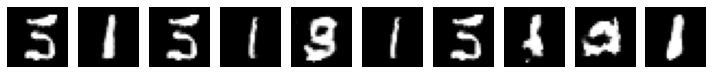

19900 [D loss: 0.053487, acc.: 96.09%] [G loss: 6.818736]
19901 [D loss: 0.044445, acc.: 97.66%] [G loss: 5.954278]
19902 [D loss: 0.110637, acc.: 97.66%] [G loss: 5.607349]
19903 [D loss: 0.042002, acc.: 97.66%] [G loss: 5.483303]
19904 [D loss: 0.100245, acc.: 97.66%] [G loss: 5.879800]
19905 [D loss: 0.007089, acc.: 100.00%] [G loss: 6.526521]
19906 [D loss: 0.037026, acc.: 96.88%] [G loss: 6.018028]
19907 [D loss: 0.100279, acc.: 97.66%] [G loss: 4.986825]
19908 [D loss: 0.047444, acc.: 98.44%] [G loss: 4.034845]
19909 [D loss: 0.029506, acc.: 99.22%] [G loss: 3.825025]
19910 [D loss: 0.011882, acc.: 100.00%] [G loss: 3.444424]
19911 [D loss: 0.073165, acc.: 97.66%] [G loss: 4.173285]
19912 [D loss: 0.097868, acc.: 97.66%] [G loss: 5.005696]
19913 [D loss: 0.083572, acc.: 97.66%] [G loss: 5.475430]
19914 [D loss: 0.034588, acc.: 99.22%] [G loss: 5.768447]
19915 [D loss: 0.034679, acc.: 98.44%] [G loss: 6.018260]
19916 [D loss: 0.105372, acc.: 95.31%] [G loss: 6.129826]
19917 [D los

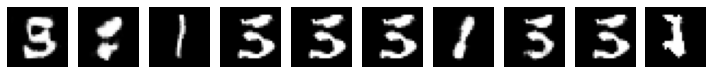

In [6]:
gan=DCGAN()
gan.train(epochs=20000)


In [33]:
(x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)
